### Human Activity Recognition

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).values
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).values

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    Y_train, Y_test = load_y('train'), load_y('test')
    return X_train, X_test, Y_train, Y_test


In [8]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

In [39]:
#Function to plot Train and cross validation loss
def plt_dynamic(x, vy, ty):
  plt.figure(figsize=(10,5))
  plt.plot(x, vy, 'b', label="Validation Loss")
  plt.plot(x, ty, 'r', label="Train Loss")
  plt.xlabel('Epochs') 
  plt.ylabel('categorical_crossentropy Loss')
  plt.title('\ncategorical_crossentropy Loss VS Epochs')
  plt.legend()
  plt.grid()
  plt.show()

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [13]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [14]:
# Initializing parameters
epochs = 1
batch_size = 16
n_hidden = 32

In [15]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [16]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [17]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7352, 128, 9)
(2947, 128, 9)
(7352, 6)
(2947, 6)


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [19]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

###  A. Tuning parameters using Grid search for 1 Layer LSTM

In [20]:
import numpy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

In [21]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import RandomizedSearchCV
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
from keras.layers import Bidirectional, CuDNNLSTM

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Tuning Batch size, Epochs, Dropout rate & n_hidden

In [22]:
def create_model(dropout_rate=0.0,n_hidden=32):
    # default values
    model = Sequential()
# Configuring the parameters
    model.add(CuDNNLSTM(n_hidden, input_shape=(timesteps, input_dim)))
#Adding batch normnalization
    model.add(BatchNormalization())
# Adding a dropout layer
    model.add(Dropout(dropout_rate))
# Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model,verbose=1)

# define the grid search parameters
batch_size = [32,64,128,256]
epochs = [10,30,50]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_hidden = [16,32,64,128]

param_distributions  = dict(batch_size=batch_size, epochs=epochs,dropout_rate=dropout_rate,n_hidden=n_hidden)

grid = RandomizedSearchCV(estimator=model, param_distributions =param_distributions ,cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\deepak\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
4901/4901 [==============================] - ETA: 4:04 - loss: 1.8630 - acc: 0.093 - ETA: 30s - loss: 1.8263 - acc: 0.183 - ETA: 14s - loss: 1.7764 - acc: 0.25 - ETA: 9s - loss: 1.7535 - acc: 0.2799 - ETA: 6s - loss: 1.7388 - acc: 0.281 - ETA: 5s - loss: 1.7251 - acc: 0.296 - ETA: 4s - loss: 1.6953 - acc: 0.317 - ETA: 3s - loss: 1.6716 - acc: 0.335 - ETA: 2s - loss: 1.6458 - acc: 0.344 - ETA: 2s - loss: 1.6145 - acc: 0.364 - ETA: 1s - loss: 1.5903 - acc: 0.377 - ETA: 1s - loss: 1.5707 - acc: 0.382 - ETA: 1s - loss: 1.5475 - acc: 0.394 - ETA: 0s - loss: 1.5331 - acc: 0.397 - ETA: 0s - loss: 1.5129 - acc: 0.409 - ETA: 0s - loss: 1.4923 - acc: 0.416 - ETA: 0s - loss: 1.4741 - acc: 0.425 - ETA: 0s - loss: 1.4604 - acc: 0.429 - 3s 527us/step - loss: 1.4441 - acc: 0.4344
Epoch 2/50
4901/4901 [============================

4901/4901 [==============================] - ETA: 1s - loss: 0.6332 - acc: 0.625 - ETA: 0s - loss: 0.7368 - acc: 0.694 - ETA: 0s - loss: 0.7136 - acc: 0.689 - ETA: 0s - loss: 0.7343 - acc: 0.682 - ETA: 0s - loss: 0.7343 - acc: 0.680 - ETA: 0s - loss: 0.7330 - acc: 0.679 - ETA: 0s - loss: 0.7286 - acc: 0.671 - ETA: 0s - loss: 0.7283 - acc: 0.672 - ETA: 0s - loss: 0.7294 - acc: 0.671 - ETA: 0s - loss: 0.7274 - acc: 0.673 - ETA: 0s - loss: 0.7326 - acc: 0.672 - ETA: 0s - loss: 0.7308 - acc: 0.666 - ETA: 0s - loss: 0.7327 - acc: 0.664 - ETA: 0s - loss: 0.7291 - acc: 0.664 - ETA: 0s - loss: 0.7280 - acc: 0.666 - ETA: 0s - loss: 0.7228 - acc: 0.666 - ETA: 0s - loss: 0.7207 - acc: 0.665 - ETA: 0s - loss: 0.7230 - acc: 0.664 - 1s 196us/step - loss: 0.7213 - acc: 0.6637
Epoch 21/50
4901/4901 [==============================] - ETA: 1s - loss: 1.1583 - acc: 0.500 - ETA: 0s - loss: 0.7807 - acc: 0.668 - ETA: 0s - loss: 0.7384 - acc: 0.677 - ETA: 0s - loss: 0.7540 - acc: 0.676 - ETA: 0s - loss: 0.7

4901/4901 [==============================] - ETA: 0s - loss: 0.4242 - acc: 0.812 - ETA: 0s - loss: 0.4971 - acc: 0.833 - ETA: 0s - loss: 0.5227 - acc: 0.828 - ETA: 0s - loss: 0.4811 - acc: 0.835 - ETA: 0s - loss: 0.4554 - acc: 0.844 - ETA: 0s - loss: 0.4483 - acc: 0.849 - ETA: 0s - loss: 0.4462 - acc: 0.853 - ETA: 0s - loss: 0.4378 - acc: 0.854 - ETA: 0s - loss: 0.4440 - acc: 0.854 - ETA: 0s - loss: 0.4414 - acc: 0.859 - ETA: 0s - loss: 0.4530 - acc: 0.857 - ETA: 0s - loss: 0.4563 - acc: 0.852 - ETA: 0s - loss: 0.4487 - acc: 0.855 - ETA: 0s - loss: 0.5304 - acc: 0.812 - ETA: 0s - loss: 0.6227 - acc: 0.762 - ETA: 0s - loss: 0.7024 - acc: 0.720 - ETA: 0s - loss: 0.7719 - acc: 0.684 - ETA: 0s - loss: 0.8267 - acc: 0.655 - 1s 195us/step - loss: 0.8525 - acc: 0.6419
Epoch 41/50
4901/4901 [==============================] - ETA: 1s - loss: 1.7918 - acc: 0.187 - ETA: 0s - loss: 1.7918 - acc: 0.156 - ETA: 0s - loss: 1.7918 - acc: 0.151 - ETA: 0s - loss: 1.7918 - acc: 0.156 - ETA: 0s - loss: 1.7

4901/4901 [==============================] - ETA: 0s - loss: 0.8475 - acc: 0.562 - ETA: 0s - loss: 0.8632 - acc: 0.597 - ETA: 0s - loss: 0.8592 - acc: 0.604 - ETA: 0s - loss: 0.8589 - acc: 0.601 - ETA: 0s - loss: 0.8541 - acc: 0.597 - ETA: 0s - loss: 0.8470 - acc: 0.598 - ETA: 0s - loss: 0.8399 - acc: 0.605 - ETA: 0s - loss: 0.8425 - acc: 0.604 - ETA: 0s - loss: 0.8370 - acc: 0.601 - ETA: 0s - loss: 0.8342 - acc: 0.604 - ETA: 0s - loss: 0.8345 - acc: 0.605 - ETA: 0s - loss: 0.8317 - acc: 0.611 - ETA: 0s - loss: 0.8311 - acc: 0.611 - ETA: 0s - loss: 0.8330 - acc: 0.610 - ETA: 0s - loss: 0.8343 - acc: 0.604 - ETA: 0s - loss: 0.8346 - acc: 0.606 - ETA: 0s - loss: 0.8363 - acc: 0.605 - ETA: 0s - loss: 0.8390 - acc: 0.602 - ETA: 0s - loss: 0.8387 - acc: 0.603 - 1s 198us/step - loss: 0.8386 - acc: 0.6031
Epoch 10/50
4901/4901 [==============================] - ETA: 1s - loss: 0.6945 - acc: 0.656 - ETA: 0s - loss: 0.8089 - acc: 0.614 - ETA: 0s - loss: 0.8019 - acc: 0.641 - ETA: 0s - loss: 0.8

4901/4901 [==============================] - ETA: 1s - loss: 0.3742 - acc: 0.937 - ETA: 0s - loss: 0.4634 - acc: 0.861 - ETA: 0s - loss: 0.4746 - acc: 0.845 - ETA: 0s - loss: 0.4702 - acc: 0.856 - ETA: 0s - loss: 0.4693 - acc: 0.861 - ETA: 0s - loss: 0.4688 - acc: 0.862 - ETA: 0s - loss: 0.4701 - acc: 0.858 - ETA: 0s - loss: 0.4651 - acc: 0.858 - ETA: 0s - loss: 0.4769 - acc: 0.856 - ETA: 0s - loss: 0.4676 - acc: 0.857 - ETA: 0s - loss: 0.4731 - acc: 0.855 - ETA: 0s - loss: 0.4724 - acc: 0.856 - ETA: 0s - loss: 0.4698 - acc: 0.855 - ETA: 0s - loss: 0.4680 - acc: 0.857 - ETA: 0s - loss: 0.4722 - acc: 0.853 - ETA: 0s - loss: 0.4703 - acc: 0.853 - ETA: 0s - loss: 0.4631 - acc: 0.856 - ETA: 0s - loss: 0.4619 - acc: 0.858 - ETA: 0s - loss: 0.4588 - acc: 0.859 - 1s 200us/step - loss: 0.4589 - acc: 0.8590
Epoch 30/50
4901/4901 [==============================] - ETA: 1s - loss: 0.4460 - acc: 0.843 - ETA: 0s - loss: 0.4237 - acc: 0.847 - ETA: 0s - loss: 0.4337 - acc: 0.847 - ETA: 0s - loss: 0.4

Epoch 49/50
4901/4901 [==============================] - ETA: 0s - loss: 1.7918 - acc: 0.250 - ETA: 0s - loss: 1.7918 - acc: 0.171 - ETA: 0s - loss: 1.7918 - acc: 0.180 - ETA: 0s - loss: 1.7918 - acc: 0.182 - ETA: 0s - loss: 1.7918 - acc: 0.184 - ETA: 0s - loss: 1.7918 - acc: 0.187 - ETA: 0s - loss: 1.7918 - acc: 0.186 - ETA: 0s - loss: 1.7918 - acc: 0.187 - ETA: 0s - loss: 1.7918 - acc: 0.188 - ETA: 0s - loss: 1.7918 - acc: 0.185 - ETA: 0s - loss: 1.7918 - acc: 0.184 - ETA: 0s - loss: 1.7918 - acc: 0.180 - ETA: 0s - loss: 1.7918 - acc: 0.181 - ETA: 0s - loss: 1.7918 - acc: 0.180 - ETA: 0s - loss: 1.7918 - acc: 0.177 - ETA: 0s - loss: 1.7918 - acc: 0.177 - ETA: 0s - loss: 1.7918 - acc: 0.176 - ETA: 0s - loss: 1.7918 - acc: 0.175 - 1s 197us/step - loss: 1.7914 - acc: 0.1736
Epoch 50/50
4901/4901 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 87us/step
Epoch 1/50
4902/4902 [==============================] - ETA: 56s - loss: 1

4902/4902 [==============================] - ETA: 1s - loss: 1.1686 - acc: 0.718 - ETA: 0s - loss: 0.6680 - acc: 0.711 - ETA: 0s - loss: 0.6774 - acc: 0.707 - ETA: 0s - loss: 0.6425 - acc: 0.726 - ETA: 0s - loss: 0.6686 - acc: 0.720 - ETA: 0s - loss: 0.6629 - acc: 0.716 - ETA: 0s - loss: 0.6530 - acc: 0.718 - ETA: 0s - loss: 0.6461 - acc: 0.723 - ETA: 0s - loss: 0.6412 - acc: 0.723 - ETA: 0s - loss: 0.6355 - acc: 0.725 - ETA: 0s - loss: 0.6313 - acc: 0.729 - ETA: 0s - loss: 0.6275 - acc: 0.734 - ETA: 0s - loss: 0.6262 - acc: 0.731 - ETA: 0s - loss: 0.6413 - acc: 0.727 - ETA: 0s - loss: 0.6410 - acc: 0.727 - ETA: 0s - loss: 0.6356 - acc: 0.728 - ETA: 0s - loss: 0.6368 - acc: 0.729 - ETA: 0s - loss: 0.6330 - acc: 0.730 - ETA: 0s - loss: 0.6363 - acc: 0.728 - 1s 199us/step - loss: 0.6360 - acc: 0.7289
Epoch 19/50
4902/4902 [==============================] - ETA: 1s - loss: 0.6083 - acc: 0.750 - ETA: 0s - loss: 0.5588 - acc: 0.770 - ETA: 0s - loss: 0.5711 - acc: 0.760 - ETA: 0s - loss: 0.5

4902/4902 [==============================] - ETA: 1s - loss: 1.7918 - acc: 0.156 - ETA: 0s - loss: 1.7918 - acc: 0.159 - ETA: 0s - loss: 1.7918 - acc: 0.163 - ETA: 0s - loss: 1.7918 - acc: 0.175 - ETA: 0s - loss: 1.7918 - acc: 0.177 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.169 - ETA: 0s - loss: 1.7918 - acc: 0.165 - ETA: 0s - loss: 1.7918 - acc: 0.166 - ETA: 0s - loss: 1.7918 - acc: 0.168 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.172 - ETA: 0s - loss: 1.7918 - acc: 0.172 - ETA: 0s - loss: 1.7918 - acc: 0.171 - ETA: 0s - loss: 1.7918 - acc: 0.176 - ETA: 0s - loss: 1.7918 - acc: 0.173 - ETA: 0s - loss: 1.7918 - acc: 0.172 - ETA: 0s - loss: 1.7918 - acc: 0.170 - 1s 197us/step - loss: 1.7918 - acc: 0.1703
Epoch 39/50
4902/4902 [==============================] - ETA: 1s - loss: 1.7918 - acc: 0.218 - ETA: 0s - loss: 1.7918 - acc: 0.190 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.179 - ETA: 0s - loss: 1.7

4901/4901 [==============================] - ETA: 0s - loss: 1.0420 - acc: 0.554 - ETA: 0s - loss: 1.0098 - acc: 0.560 - ETA: 0s - loss: 1.0126 - acc: 0.558 - ETA: 0s - loss: 1.0089 - acc: 0.558 - 0s 38us/step - loss: 1.0086 - acc: 0.5578
Epoch 24/30
4901/4901 [==============================] - ETA: 0s - loss: 1.0191 - acc: 0.519 - ETA: 0s - loss: 0.9965 - acc: 0.561 - ETA: 0s - loss: 0.9835 - acc: 0.579 - ETA: 0s - loss: 0.9909 - acc: 0.573 - 0s 38us/step - loss: 0.9916 - acc: 0.5736
Epoch 25/30
4901/4901 [==============================] - ETA: 0s - loss: 0.9820 - acc: 0.578 - ETA: 0s - loss: 0.9841 - acc: 0.565 - ETA: 0s - loss: 0.9863 - acc: 0.562 - ETA: 0s - loss: 0.9838 - acc: 0.569 - 0s 38us/step - loss: 0.9842 - acc: 0.5699
Epoch 26/30
4901/4901 [==============================] - ETA: 0s - loss: 0.9757 - acc: 0.566 - ETA: 0s - loss: 0.9877 - acc: 0.577 - ETA: 0s - loss: 0.9891 - acc: 0.567 - ETA: 0s - loss: 0.9842 - acc: 0.567 - 0s 38us/step - loss: 0.9847 - acc: 0.5670
Epoch 27

4902/4902 [==============================] - ETA: 0s - loss: 1.0087 - acc: 0.597 - ETA: 0s - loss: 0.9770 - acc: 0.597 - ETA: 0s - loss: 0.9863 - acc: 0.597 - ETA: 0s - loss: 0.9833 - acc: 0.593 - 0s 41us/step - loss: 0.9809 - acc: 0.5945
Epoch 28/30
4902/4902 [==============================] - ETA: 0s - loss: 0.9496 - acc: 0.628 - ETA: 0s - loss: 0.9699 - acc: 0.596 - ETA: 0s - loss: 0.9669 - acc: 0.599 - ETA: 0s - loss: 0.9732 - acc: 0.601 - 0s 39us/step - loss: 0.9724 - acc: 0.6022
Epoch 29/30
4902/4902 [==============================] - ETA: 0s - loss: 0.9508 - acc: 0.605 - ETA: 0s - loss: 0.9714 - acc: 0.614 - ETA: 0s - loss: 0.9669 - acc: 0.606 - ETA: 0s - loss: 0.9605 - acc: 0.606 - 0s 39us/step - loss: 0.9605 - acc: 0.6061
Epoch 30/30
4902/4902 [==============================] - ETA:  - ETA:  - 0s 19us/step
Epoch 1/50
4901/4901 [==============================] - ETA: 9s - loss: 1.8081 - acc: 0.175 - ETA: 1s - loss: 1.8057 - acc: 0.195 - ETA: 0s - loss: 1.7868 - acc: 0.231 - ETA

4901/4901 [==============================] - ETA: 0s - loss: 1.2648 - acc: 0.527 - ETA: 0s - loss: 1.2347 - acc: 0.554 - ETA: 0s - loss: 1.2271 - acc: 0.561 - ETA: 0s - loss: 1.2184 - acc: 0.559 - 0s 38us/step - loss: 1.2185 - acc: 0.5599
Epoch 12/50
4901/4901 [==============================] - ETA: 0s - loss: 1.2191 - acc: 0.554 - ETA: 0s - loss: 1.1985 - acc: 0.573 - ETA: 0s - loss: 1.1926 - acc: 0.575 - ETA: 0s - loss: 1.1864 - acc: 0.580 - 0s 38us/step - loss: 1.1861 - acc: 0.5819
Epoch 13/50
4901/4901 [==============================] - ETA: 0s - loss: 1.1719 - acc: 0.546 - ETA: 0s - loss: 1.1544 - acc: 0.589 - ETA: 0s - loss: 1.1531 - acc: 0.584 - ETA: 0s - loss: 1.1591 - acc: 0.582 - 0s 39us/step - loss: 1.1588 - acc: 0.5831
Epoch 14/50
4901/4901 [==============================] - ETA: 0s - loss: 1.2085 - acc: 0.535 - ETA: 0s - loss: 1.1578 - acc: 0.570 - ETA: 0s - loss: 1.1516 - acc: 0.579 - ETA: 0s - loss: 1.1454 - acc: 0.580 - 0s 38us/step - loss: 1.1458 - acc: 0.5801
Epoch 15

4902/4902 [==============================] - ETA: 0s - loss: 0.9951 - acc: 0.699 - ETA: 0s - loss: 1.0032 - acc: 0.651 - ETA: 0s - loss: 1.0091 - acc: 0.640 - ETA: 0s - loss: 1.0076 - acc: 0.639 - 0s 39us/step - loss: 1.0068 - acc: 0.6397
Epoch 26/50
4902/4902 [==============================] - ETA: 0s - loss: 0.9588 - acc: 0.660 - ETA: 0s - loss: 0.9869 - acc: 0.637 - ETA: 0s - loss: 0.9874 - acc: 0.645 - ETA: 0s - loss: 0.9838 - acc: 0.646 - 0s 38us/step - loss: 0.9848 - acc: 0.6457
Epoch 27/50
4902/4902 [==============================] - ETA: 0s - loss: 0.9978 - acc: 0.632 - ETA: 0s - loss: 0.9748 - acc: 0.647 - ETA: 0s - loss: 0.9929 - acc: 0.644 - ETA: 0s - loss: 0.9877 - acc: 0.643 - 0s 39us/step - loss: 0.9885 - acc: 0.6426
Epoch 28/50
4902/4902 [==============================] - ETA: 0s - loss: 0.9893 - acc: 0.632 - ETA: 0s - loss: 0.9790 - acc: 0.658 - ETA: 0s - loss: 0.9769 - acc: 0.656 - ETA: 0s - loss: 0.9715 - acc: 0.651 - 0s 39us/step - loss: 0.9726 - acc: 0.6514
Epoch 29

4901/4901 [==============================] - ETA: 0s - loss: 0.4277 - acc: 0.918 - ETA: 0s - loss: 0.5975 - acc: 0.853 - ETA: 0s - loss: 0.5087 - acc: 0.879 - ETA: 0s - loss: 0.4924 - acc: 0.875 - 0s 40us/step - loss: 0.4872 - acc: 0.8778
Epoch 10/30
4901/4901 [==============================] - ETA: 0s - loss: 0.4438 - acc: 0.898 - ETA: 0s - loss: 0.3852 - acc: 0.930 - ETA: 0s - loss: 0.3861 - acc: 0.923 - ETA: 0s - loss: 0.3951 - acc: 0.913 - 0s 39us/step - loss: 0.3954 - acc: 0.9137
Epoch 11/30
4901/4901 [==============================] - ETA: 0s - loss: 0.2997 - acc: 0.957 - ETA: 0s - loss: 0.3031 - acc: 0.953 - ETA: 0s - loss: 0.3172 - acc: 0.941 - ETA: 0s - loss: 0.3493 - acc: 0.923 - 0s 40us/step - loss: 0.3425 - acc: 0.9253
Epoch 12/30
4901/4901 [==============================] - ETA: 0s - loss: 0.2758 - acc: 0.937 - ETA: 0s - loss: 0.2907 - acc: 0.936 - ETA: 0s - loss: 0.2731 - acc: 0.944 - ETA: 0s - loss: 0.2865 - acc: 0.937 - 0s 44us/step - loss: 0.2904 - acc: 0.9347
Epoch 13

4901/4901 [==============================] - ETA:  - ETA:  - ETA:  - 0s 30us/step
Epoch 1/10
4901/4901 [==============================] - ETA: 31s - loss: 1.8084 - acc: 0.19 - ETA: 3s - loss: 1.7877 - acc: 0.1689 - ETA: 1s - loss: 1.7663 - acc: 0.213 - ETA: 0s - loss: 1.7496 - acc: 0.235 - ETA: 0s - loss: 1.7334 - acc: 0.257 - ETA: 0s - loss: 1.7150 - acc: 0.279 - 1s 235us/step - loss: 1.7103 - acc: 0.2857
Epoch 2/10
4901/4901 [==============================] - ETA: 0s - loss: 1.6218 - acc: 0.390 - ETA: 0s - loss: 1.6216 - acc: 0.386 - ETA: 0s - loss: 1.6073 - acc: 0.402 - ETA: 0s - loss: 1.5934 - acc: 0.413 - ETA: 0s - loss: 1.5796 - acc: 0.420 - ETA: 0s - loss: 1.5648 - acc: 0.428 - 0s 61us/step - loss: 1.5620 - acc: 0.4285
Epoch 3/10
4901/4901 [==============================] - ETA: 0s - loss: 1.4945 - acc: 0.468 - ETA: 0s - loss: 1.4841 - acc: 0.484 - ETA: 0s - loss: 1.4694 - acc: 0.495 - ETA: 0s - loss: 1.4568 - acc: 0.497 - ETA: 0s - loss: 1.4512 - acc: 0.500 - ETA: 0s - loss: 1.

4901/4901 [==============================] - ETA: 0s - loss: 0.9554 - acc: 0.582 - ETA: 0s - loss: 0.9375 - acc: 0.591 - ETA: 0s - loss: 0.9512 - acc: 0.592 - ETA: 0s - loss: 0.9350 - acc: 0.597 - 0s 41us/step - loss: 0.9314 - acc: 0.6015
Epoch 7/30
4901/4901 [==============================] - ETA: 0s - loss: 0.8488 - acc: 0.574 - ETA: 0s - loss: 0.8744 - acc: 0.610 - ETA: 0s - loss: 0.8837 - acc: 0.606 - ETA: 0s - loss: 0.8757 - acc: 0.611 - 0s 41us/step - loss: 0.8716 - acc: 0.6127
Epoch 8/30
4901/4901 [==============================] - ETA: 0s - loss: 0.8359 - acc: 0.597 - ETA: 0s - loss: 0.8479 - acc: 0.631 - ETA: 0s - loss: 0.8509 - acc: 0.631 - ETA: 0s - loss: 0.8472 - acc: 0.628 - 0s 40us/step - loss: 0.8471 - acc: 0.6258
Epoch 9/30
4901/4901 [==============================] - ETA: 0s - loss: 0.8452 - acc: 0.621 - ETA: 0s - loss: 0.8396 - acc: 0.611 - ETA: 0s - loss: 0.8227 - acc: 0.626 - ETA: 0s - loss: 0.8199 - acc: 0.630 - 0s 40us/step - loss: 0.8228 - acc: 0.6274
Epoch 10/30

4901/4901 [==============================] - ETA: 0s - loss: 0.8548 - acc: 0.718 - ETA: 0s - loss: 0.9478 - acc: 0.670 - ETA: 0s - loss: 0.9354 - acc: 0.669 - ETA: 0s - loss: 0.9340 - acc: 0.669 - ETA: 0s - loss: 0.9349 - acc: 0.670 - ETA: 0s - loss: 0.9244 - acc: 0.675 - ETA: 0s - loss: 0.9181 - acc: 0.675 - ETA: 0s - loss: 0.9088 - acc: 0.681 - ETA: 0s - loss: 0.9028 - acc: 0.682 - ETA: 0s - loss: 0.8992 - acc: 0.679 - 1s 105us/step - loss: 0.8948 - acc: 0.6829
Epoch 6/10
4901/4901 [==============================] - ETA: 0s - loss: 0.8260 - acc: 0.687 - ETA: 0s - loss: 0.7843 - acc: 0.734 - ETA: 0s - loss: 0.7890 - acc: 0.720 - ETA: 0s - loss: 0.7972 - acc: 0.710 - ETA: 0s - loss: 0.7984 - acc: 0.706 - ETA: 0s - loss: 0.7955 - acc: 0.701 - ETA: 0s - loss: 0.7991 - acc: 0.692 - ETA: 0s - loss: 0.7921 - acc: 0.696 - ETA: 0s - loss: 0.7834 - acc: 0.699 - ETA: 0s - loss: 0.7783 - acc: 0.699 - 1s 105us/step - loss: 0.7770 - acc: 0.6990
Epoch 7/10
4901/4901 [==============================]

4901/4901 [==============================] - ETA: 0s - loss: 0.3496 - acc: 0.937 - ETA: 0s - loss: 0.3733 - acc: 0.913 - ETA: 0s - loss: 0.3747 - acc: 0.911 - ETA: 0s - loss: 0.3692 - acc: 0.913 - ETA: 0s - loss: 0.3777 - acc: 0.907 - ETA: 0s - loss: 0.3761 - acc: 0.905 - ETA: 0s - loss: 0.3643 - acc: 0.908 - ETA: 0s - loss: 0.3579 - acc: 0.912 - ETA: 0s - loss: 0.3566 - acc: 0.913 - ETA: 0s - loss: 0.3538 - acc: 0.913 - 1s 105us/step - loss: 0.3630 - acc: 0.9117
Epoch 8/50
4901/4901 [==============================] - ETA: 0s - loss: 0.7841 - acc: 0.781 - ETA: 0s - loss: 0.5354 - acc: 0.836 - ETA: 0s - loss: 0.4616 - acc: 0.861 - ETA: 0s - loss: 0.4197 - acc: 0.873 - ETA: 0s - loss: 0.3999 - acc: 0.873 - ETA: 0s - loss: 0.3862 - acc: 0.880 - ETA: 0s - loss: 0.3730 - acc: 0.885 - ETA: 0s - loss: 0.4048 - acc: 0.877 - ETA: 0s - loss: 0.4216 - acc: 0.872 - ETA: 0s - loss: 0.4188 - acc: 0.873 - 1s 106us/step - loss: 0.4139 - acc: 0.8753
Epoch 9/50
4901/4901 [==============================]

4901/4901 [==============================] - ETA: 0s - loss: 0.1207 - acc: 0.968 - ETA: 0s - loss: 0.1539 - acc: 0.937 - ETA: 0s - loss: 0.1288 - acc: 0.949 - ETA: 0s - loss: 0.1281 - acc: 0.948 - ETA: 0s - loss: 0.1277 - acc: 0.949 - ETA: 0s - loss: 0.1271 - acc: 0.949 - ETA: 0s - loss: 0.1275 - acc: 0.949 - ETA: 0s - loss: 0.1368 - acc: 0.945 - ETA: 0s - loss: 0.1367 - acc: 0.945 - ETA: 0s - loss: 0.1369 - acc: 0.945 - 1s 106us/step - loss: 0.1386 - acc: 0.9443
Epoch 42/50
4901/4901 [==============================] - ETA: 0s - loss: 0.0875 - acc: 0.968 - ETA: 0s - loss: 0.1046 - acc: 0.960 - ETA: 0s - loss: 0.1215 - acc: 0.954 - ETA: 0s - loss: 0.1238 - acc: 0.950 - ETA: 0s - loss: 0.1350 - acc: 0.944 - ETA: 0s - loss: 0.1373 - acc: 0.941 - ETA: 0s - loss: 0.1356 - acc: 0.943 - ETA: 0s - loss: 0.1305 - acc: 0.946 - ETA: 0s - loss: 0.1371 - acc: 0.945 - ETA: 0s - loss: 0.1328 - acc: 0.947 - 1s 105us/step - loss: 0.1320 - acc: 0.9480
Epoch 43/50
4901/4901 [=============================

4901/4901 [==============================] - ETA: 0s - loss: 0.0724 - acc: 0.984 - ETA: 0s - loss: 0.1470 - acc: 0.944 - ETA: 0s - loss: 0.1232 - acc: 0.955 - ETA: 0s - loss: 0.1444 - acc: 0.947 - ETA: 0s - loss: 0.1414 - acc: 0.948 - ETA: 0s - loss: 0.1367 - acc: 0.950 - ETA: 0s - loss: 0.1369 - acc: 0.952 - ETA: 0s - loss: 0.1373 - acc: 0.951 - ETA: 0s - loss: 0.1334 - acc: 0.952 - ETA: 0s - loss: 0.1304 - acc: 0.952 - 1s 108us/step - loss: 0.1294 - acc: 0.9533
Epoch 25/50
4901/4901 [==============================] - ETA: 0s - loss: 0.1100 - acc: 0.953 - ETA: 0s - loss: 0.1483 - acc: 0.937 - ETA: 0s - loss: 0.1297 - acc: 0.943 - ETA: 0s - loss: 0.1239 - acc: 0.945 - ETA: 0s - loss: 0.1171 - acc: 0.948 - ETA: 0s - loss: 0.1207 - acc: 0.948 - ETA: 0s - loss: 0.1300 - acc: 0.947 - ETA: 0s - loss: 0.1317 - acc: 0.946 - ETA: 0s - loss: 0.1280 - acc: 0.948 - ETA: 0s - loss: 0.1282 - acc: 0.948 - 1s 106us/step - loss: 0.1262 - acc: 0.9492
Epoch 26/50
4901/4901 [=============================

4902/4902 [==============================] - ETA: 0s - loss: 0.3774 - acc: 0.890 - ETA: 0s - loss: 0.3980 - acc: 0.892 - ETA: 0s - loss: 0.4099 - acc: 0.886 - ETA: 0s - loss: 0.4016 - acc: 0.887 - ETA: 0s - loss: 0.3961 - acc: 0.886 - ETA: 0s - loss: 0.3976 - acc: 0.882 - ETA: 0s - loss: 0.3895 - acc: 0.884 - ETA: 0s - loss: 0.3890 - acc: 0.887 - ETA: 0s - loss: 0.3900 - acc: 0.886 - ETA: 0s - loss: 0.3946 - acc: 0.881 - 1s 107us/step - loss: 0.3916 - acc: 0.8829
Epoch 8/50
4902/4902 [==============================] - ETA: 0s - loss: 0.3543 - acc: 0.906 - ETA: 0s - loss: 0.3335 - acc: 0.895 - ETA: 0s - loss: 0.3219 - acc: 0.901 - ETA: 0s - loss: 0.3249 - acc: 0.905 - ETA: 0s - loss: 0.3230 - acc: 0.908 - ETA: 0s - loss: 0.3168 - acc: 0.910 - ETA: 0s - loss: 0.3293 - acc: 0.906 - ETA: 0s - loss: 0.3274 - acc: 0.906 - ETA: 0s - loss: 0.3264 - acc: 0.905 - ETA: 0s - loss: 0.3205 - acc: 0.906 - 1s 106us/step - loss: 0.3209 - acc: 0.9051
Epoch 9/50
4902/4902 [==============================]

4902/4902 [==============================] - ETA: 0s - loss: 0.1101 - acc: 0.937 - ETA: 0s - loss: 0.1049 - acc: 0.954 - ETA: 0s - loss: 0.1386 - acc: 0.944 - ETA: 0s - loss: 0.1277 - acc: 0.946 - ETA: 0s - loss: 0.1352 - acc: 0.942 - ETA: 0s - loss: 0.1358 - acc: 0.943 - ETA: 0s - loss: 0.1326 - acc: 0.946 - ETA: 0s - loss: 0.1319 - acc: 0.945 - ETA: 0s - loss: 0.1308 - acc: 0.943 - ETA: 0s - loss: 0.1260 - acc: 0.945 - 1s 107us/step - loss: 0.1241 - acc: 0.9461
Epoch 42/50
4902/4902 [==============================] - ETA: 0s - loss: 0.1388 - acc: 0.937 - ETA: 0s - loss: 0.1569 - acc: 0.928 - ETA: 0s - loss: 0.1356 - acc: 0.939 - ETA: 0s - loss: 0.1223 - acc: 0.948 - ETA: 0s - loss: 0.1215 - acc: 0.947 - ETA: 0s - loss: 0.1188 - acc: 0.948 - ETA: 0s - loss: 0.1247 - acc: 0.948 - ETA: 0s - loss: 0.1236 - acc: 0.947 - ETA: 0s - loss: 0.1249 - acc: 0.946 - ETA: 0s - loss: 0.1228 - acc: 0.946 - 1s 109us/step - loss: 0.1234 - acc: 0.9453
Epoch 43/50
4902/4902 [=============================

Epoch 14/50
4901/4901 [==============================] - ETA: 0s - loss: 0.6672 - acc: 0.730 - ETA: 0s - loss: 0.6419 - acc: 0.793 - ETA: 0s - loss: 0.6396 - acc: 0.791 - ETA: 0s - loss: 0.6446 - acc: 0.787 - 0s 41us/step - loss: 0.6442 - acc: 0.7870
Epoch 15/50
4901/4901 [==============================] - ETA: 0s - loss: 0.6054 - acc: 0.793 - ETA: 0s - loss: 0.6257 - acc: 0.800 - ETA: 0s - loss: 0.6370 - acc: 0.797 - ETA: 0s - loss: 0.6364 - acc: 0.799 - 0s 40us/step - loss: 0.6331 - acc: 0.8007
Epoch 16/50
4901/4901 [==============================] - ETA: 0s - loss: 0.6712 - acc: 0.761 - ETA: 0s - loss: 0.6077 - acc: 0.813 - ETA: 0s - loss: 0.5988 - acc: 0.817 - ETA: 0s - loss: 0.5925 - acc: 0.813 - 0s 38us/step - loss: 0.5933 - acc: 0.8139
Epoch 17/50
4901/4901 [==============================] - ETA: 0s - loss: 0.6663 - acc: 0.734 - ETA: 0s - loss: 0.5908 - acc: 0.794 - ETA: 0s - loss: 0.5738 - acc: 0.807 - ETA: 0s - loss: 0.5678 - acc: 0.813 - 0s 38us/step - loss: 0.5689 - acc: 0.8

4901/4901 [==============================] - ETA: 0s - loss: 0.3638 - acc: 0.871 - ETA: 0s - loss: 0.4010 - acc: 0.834 - ETA: 0s - loss: 0.4098 - acc: 0.838 - ETA: 0s - loss: 0.4225 - acc: 0.834 - 0s 40us/step - loss: 0.4227 - acc: 0.8341
Epoch 29/50
4901/4901 [==============================] - ETA: 0s - loss: 0.4814 - acc: 0.839 - ETA: 0s - loss: 0.4458 - acc: 0.837 - ETA: 0s - loss: 0.4215 - acc: 0.838 - ETA: 0s - loss: 0.4117 - acc: 0.840 - 0s 39us/step - loss: 0.4112 - acc: 0.8400
Epoch 30/50
4901/4901 [==============================] - ETA: 0s - loss: 0.4704 - acc: 0.828 - ETA: 0s - loss: 0.4169 - acc: 0.839 - ETA: 0s - loss: 0.4225 - acc: 0.839 - ETA: 0s - loss: 0.4099 - acc: 0.844 - 0s 40us/step - loss: 0.4068 - acc: 0.8451
Epoch 31/50
4901/4901 [==============================] - ETA: 0s - loss: 0.4645 - acc: 0.835 - ETA: 0s - loss: 0.3853 - acc: 0.848 - ETA: 0s - loss: 0.3773 - acc: 0.853 - ETA: 0s - loss: 0.3734 - acc: 0.859 - 0s 39us/step - loss: 0.3733 - acc: 0.8592
Epoch 32

4902/4902 [==============================] - ETA: 0s - loss: 0.3503 - acc: 0.824 - ETA: 0s - loss: 0.3380 - acc: 0.820 - ETA: 0s - loss: 0.3490 - acc: 0.816 - ETA: 0s - loss: 0.3524 - acc: 0.811 - 0s 38us/step - loss: 0.3520 - acc: 0.8121
Epoch 43/50
4902/4902 [==============================] - ETA: 0s - loss: 0.3167 - acc: 0.835 - ETA: 0s - loss: 0.4021 - acc: 0.804 - ETA: 0s - loss: 0.3615 - acc: 0.818 - ETA: 0s - loss: 0.3529 - acc: 0.821 - 0s 38us/step - loss: 0.3522 - acc: 0.8219
Epoch 44/50
4902/4902 [==============================] - ETA: 0s - loss: 0.3150 - acc: 0.828 - ETA: 0s - loss: 0.3304 - acc: 0.834 - ETA: 0s - loss: 0.3329 - acc: 0.821 - ETA: 0s - loss: 0.3281 - acc: 0.823 - 0s 38us/step - loss: 0.3274 - acc: 0.8233
Epoch 45/50
4902/4902 [==============================] - ETA: 0s - loss: 0.3926 - acc: 0.800 - ETA: 0s - loss: 0.3192 - acc: 0.828 - ETA: 0s - loss: 0.3082 - acc: 0.830 - ETA: 0s - loss: 0.3096 - acc: 0.826 - 0s 39us/step - loss: 0.3103 - acc: 0.8254
Epoch 46

4901/4901 [==============================] - ETA: 1s - loss: 0.6024 - acc: 0.781 - ETA: 1s - loss: 0.4817 - acc: 0.850 - ETA: 0s - loss: 0.4313 - acc: 0.875 - ETA: 0s - loss: 0.4137 - acc: 0.877 - ETA: 0s - loss: 0.3812 - acc: 0.893 - ETA: 0s - loss: 0.3956 - acc: 0.891 - ETA: 0s - loss: 0.3964 - acc: 0.891 - ETA: 0s - loss: 0.3915 - acc: 0.892 - ETA: 0s - loss: 0.3896 - acc: 0.891 - ETA: 0s - loss: 0.3827 - acc: 0.894 - ETA: 0s - loss: 0.3789 - acc: 0.895 - ETA: 0s - loss: 0.3686 - acc: 0.899 - ETA: 0s - loss: 0.3643 - acc: 0.900 - ETA: 0s - loss: 0.3578 - acc: 0.903 - ETA: 0s - loss: 0.3544 - acc: 0.904 - ETA: 0s - loss: 0.3493 - acc: 0.904 - ETA: 0s - loss: 0.3452 - acc: 0.905 - ETA: 0s - loss: 0.3424 - acc: 0.905 - ETA: 0s - loss: 0.3372 - acc: 0.907 - ETA: 0s - loss: 0.3340 - acc: 0.908 - 1s 222us/step - loss: 0.3402 - acc: 0.9072
Epoch 7/10
4901/4901 [==============================] - ETA: 1s - loss: 0.3107 - acc: 0.906 - ETA: 1s - loss: 0.3191 - acc: 0.902 - ETA: 0s - loss: 0.26

7352/7352 [==============================] - ETA: 1s - loss: 0.4867 - acc: 0.843 - ETA: 0s - loss: 0.4781 - acc: 0.841 - ETA: 0s - loss: 0.4661 - acc: 0.858 - ETA: 0s - loss: 0.4854 - acc: 0.850 - ETA: 0s - loss: 0.4786 - acc: 0.852 - ETA: 0s - loss: 0.4758 - acc: 0.852 - ETA: 0s - loss: 0.4773 - acc: 0.849 - ETA: 0s - loss: 0.4701 - acc: 0.853 - ETA: 0s - loss: 0.4677 - acc: 0.852 - ETA: 0s - loss: 0.4617 - acc: 0.854 - ETA: 0s - loss: 0.4591 - acc: 0.855 - ETA: 0s - loss: 0.4549 - acc: 0.855 - ETA: 0s - loss: 0.4532 - acc: 0.854 - ETA: 0s - loss: 0.4499 - acc: 0.856 - ETA: 0s - loss: 0.4478 - acc: 0.855 - ETA: 0s - loss: 0.4440 - acc: 0.858 - ETA: 0s - loss: 0.4415 - acc: 0.859 - 1s 119us/step - loss: 0.4429 - acc: 0.8585
Epoch 5/50
7352/7352 [==============================] - ETA: 0s - loss: 0.4943 - acc: 0.843 - ETA: 0s - loss: 0.4209 - acc: 0.869 - ETA: 0s - loss: 0.3826 - acc: 0.883 - ETA: 0s - loss: 0.3760 - acc: 0.886 - ETA: 0s - loss: 0.3766 - acc: 0.884 - ETA: 0s - loss: 0.38

Epoch 26/50
7352/7352 [==============================] - ETA: 0s - loss: 0.1028 - acc: 0.906 - ETA: 0s - loss: 0.1185 - acc: 0.953 - ETA: 0s - loss: 0.1266 - acc: 0.945 - ETA: 0s - loss: 0.1282 - acc: 0.946 - ETA: 0s - loss: 0.1365 - acc: 0.941 - ETA: 0s - loss: 0.1352 - acc: 0.943 - ETA: 0s - loss: 0.1356 - acc: 0.943 - ETA: 0s - loss: 0.1401 - acc: 0.943 - ETA: 0s - loss: 0.1403 - acc: 0.943 - ETA: 0s - loss: 0.1468 - acc: 0.941 - ETA: 0s - loss: 0.1483 - acc: 0.942 - ETA: 0s - loss: 0.1526 - acc: 0.941 - ETA: 0s - loss: 0.1521 - acc: 0.941 - ETA: 0s - loss: 0.1513 - acc: 0.942 - ETA: 0s - loss: 0.1506 - acc: 0.943 - ETA: 0s - loss: 0.1503 - acc: 0.944 - ETA: 0s - loss: 0.1477 - acc: 0.945 - 1s 116us/step - loss: 0.1473 - acc: 0.9453
Epoch 27/50
7352/7352 [==============================] - ETA: 0s - loss: 0.1859 - acc: 0.937 - ETA: 0s - loss: 0.1503 - acc: 0.943 - ETA: 0s - loss: 0.1463 - acc: 0.947 - ETA: 0s - loss: 0.1302 - acc: 0.953 - ETA: 0s - loss: 0.1284 - acc: 0.954 - ETA: 0s

Epoch 37/50
7352/7352 [==============================] - ETA: 0s - loss: 0.1445 - acc: 0.921 - ETA: 0s - loss: 0.2784 - acc: 0.834 - ETA: 0s - loss: 0.2461 - acc: 0.857 - ETA: 0s - loss: 0.2301 - acc: 0.869 - ETA: 0s - loss: 0.2211 - acc: 0.872 - ETA: 0s - loss: 0.2132 - acc: 0.874 - ETA: 0s - loss: 0.2022 - acc: 0.883 - ETA: 0s - loss: 0.1972 - acc: 0.886 - ETA: 0s - loss: 0.1881 - acc: 0.894 - ETA: 0s - loss: 0.1848 - acc: 0.897 - ETA: 0s - loss: 0.1817 - acc: 0.899 - ETA: 0s - loss: 0.1812 - acc: 0.901 - ETA: 0s - loss: 0.1795 - acc: 0.904 - ETA: 0s - loss: 0.1752 - acc: 0.908 - ETA: 0s - loss: 0.1751 - acc: 0.909 - ETA: 0s - loss: 0.1760 - acc: 0.911 - ETA: 0s - loss: 0.1756 - acc: 0.912 - 1s 117us/step - loss: 0.1757 - acc: 0.9128
Epoch 38/50
7352/7352 [==============================] - ETA: 0s - loss: 0.0752 - acc: 0.953 - ETA: 0s - loss: 0.1406 - acc: 0.945 - ETA: 0s - loss: 0.1551 - acc: 0.937 - ETA: 0s - loss: 0.1445 - acc: 0.938 - ETA: 0s - loss: 0.1407 - acc: 0.940 - ETA: 0s

Epoch 48/50
7352/7352 [==============================] - ETA: 1s - loss: 0.1481 - acc: 0.937 - ETA: 0s - loss: 0.1198 - acc: 0.951 - ETA: 0s - loss: 0.1266 - acc: 0.947 - ETA: 0s - loss: 0.1249 - acc: 0.949 - ETA: 0s - loss: 0.1185 - acc: 0.951 - ETA: 0s - loss: 0.1163 - acc: 0.952 - ETA: 0s - loss: 0.1172 - acc: 0.953 - ETA: 0s - loss: 0.1194 - acc: 0.950 - ETA: 0s - loss: 0.1170 - acc: 0.951 - ETA: 0s - loss: 0.1179 - acc: 0.950 - ETA: 0s - loss: 0.1214 - acc: 0.950 - ETA: 0s - loss: 0.1205 - acc: 0.950 - ETA: 0s - loss: 0.1224 - acc: 0.950 - ETA: 0s - loss: 0.1228 - acc: 0.948 - ETA: 0s - loss: 0.1208 - acc: 0.949 - ETA: 0s - loss: 0.1202 - acc: 0.950 - ETA: 0s - loss: 0.1227 - acc: 0.949 - 1s 116us/step - loss: 0.1229 - acc: 0.9491
Epoch 49/50
7352/7352 [==============================] - ETA: 0s - loss: 0.1561 - acc: 0.937 - ETA: 0s - loss: 0.1275 - acc: 0.945 - ETA: 0s - loss: 0.1183 - acc: 0.947 - ETA: 0s - loss: 0.1261 - acc: 0.946 - ETA: 0s - loss: 0.1207 - acc: 0.948 - ETA: 0s

In [27]:
n_hidden=32
epochs=50
batch_size=64

In [29]:
model = Sequential()
# Configuring the parameters
model.add(CuDNNLSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(BatchNormalization())
# Adding a dropout layer
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes,kernel_initializer='uniform' ,activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_32 (CuDNNLSTM)    (None, 32)                5504      
_________________________________________________________________
batch_normalization_33 (Batc (None, 32)                128       
_________________________________________________________________
dropout_34 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 198       
Total params: 5,830
Trainable params: 5,766
Non-trainable params: 64
_________________________________________________________________


In [30]:
 model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [31]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - ETA: 3:33 - loss: 1.7230 - acc: 0.312 - ETA: 29s - loss: 1.5756 - acc: 0.484 - ETA: 15s - loss: 1.5304 - acc: 0.49 - ETA: 9s - loss: 1.4583 - acc: 0.5039 - ETA: 6s - loss: 1.4106 - acc: 0.519 - ETA: 5s - loss: 1.3596 - acc: 0.525 - ETA: 3s - loss: 1.3230 - acc: 0.526 - ETA: 3s - loss: 1.2863 - acc: 0.541 - ETA: 2s - loss: 1.2585 - acc: 0.548 - ETA: 2s - loss: 1.2288 - acc: 0.556 - ETA: 1s - loss: 1.2014 - acc: 0.561 - ETA: 1s - loss: 1.1813 - acc: 0.565 - ETA: 1s - loss: 1.1531 - acc: 0.576 - ETA: 0s - loss: 1.1300 - acc: 0.583 - ETA: 0s - loss: 1.1096 - acc: 0.586 - ETA: 0s - loss: 1.0923 - acc: 0.592 - ETA: 0s - loss: 1.0698 - acc: 0.598 - ETA: 0s - loss: 1.0555 - acc: 0.600 - 3s 445us/step - loss: 1.0497 - acc: 0.6032 - val_loss: 0.8017 - val_acc: 0.6498
Epoch 2/50
7352/7352 [==============================] - ETA: 0s - loss: 0.5994 - acc: 0.734 - ETA: 0s - loss: 0.7656 - acc: 0.64

7352/7352 [==============================] - ETA: 1s - loss: 0.2092 - acc: 0.890 - ETA: 0s - loss: 0.1226 - acc: 0.948 - ETA: 0s - loss: 0.1202 - acc: 0.947 - ETA: 0s - loss: 0.1177 - acc: 0.947 - ETA: 0s - loss: 0.1188 - acc: 0.949 - ETA: 0s - loss: 0.1162 - acc: 0.951 - ETA: 0s - loss: 0.1257 - acc: 0.948 - ETA: 0s - loss: 0.1233 - acc: 0.949 - ETA: 0s - loss: 0.1206 - acc: 0.950 - ETA: 0s - loss: 0.1206 - acc: 0.950 - ETA: 0s - loss: 0.1183 - acc: 0.952 - ETA: 0s - loss: 0.1197 - acc: 0.951 - ETA: 0s - loss: 0.1198 - acc: 0.951 - ETA: 0s - loss: 0.1184 - acc: 0.951 - ETA: 0s - loss: 0.1195 - acc: 0.951 - ETA: 0s - loss: 0.1193 - acc: 0.950 - ETA: 0s - loss: 0.1190 - acc: 0.951 - 1s 145us/step - loss: 0.1176 - acc: 0.9523 - val_loss: 0.3682 - val_acc: 0.8911
Epoch 22/50
7352/7352 [==============================] - ETA: 1s - loss: 0.1324 - acc: 0.937 - ETA: 0s - loss: 0.1395 - acc: 0.941 - ETA: 0s - loss: 0.1603 - acc: 0.943 - ETA: 0s - loss: 0.1471 - acc: 0.950 - ETA: 0s - loss: 0.13

7352/7352 [==============================] - ETA: 0s - loss: 0.0924 - acc: 0.953 - ETA: 0s - loss: 0.1102 - acc: 0.949 - ETA: 0s - loss: 0.1243 - acc: 0.949 - ETA: 0s - loss: 0.1225 - acc: 0.947 - ETA: 0s - loss: 0.1151 - acc: 0.951 - ETA: 0s - loss: 0.1105 - acc: 0.951 - ETA: 0s - loss: 0.1116 - acc: 0.951 - ETA: 0s - loss: 0.1114 - acc: 0.950 - ETA: 0s - loss: 0.1080 - acc: 0.951 - ETA: 0s - loss: 0.1075 - acc: 0.951 - ETA: 0s - loss: 0.1106 - acc: 0.950 - ETA: 0s - loss: 0.1143 - acc: 0.951 - ETA: 0s - loss: 0.1129 - acc: 0.952 - ETA: 0s - loss: 0.1115 - acc: 0.952 - ETA: 0s - loss: 0.1118 - acc: 0.952 - ETA: 0s - loss: 0.1101 - acc: 0.953 - ETA: 0s - loss: 0.1098 - acc: 0.953 - 1s 143us/step - loss: 0.1099 - acc: 0.9539 - val_loss: 0.3233 - val_acc: 0.9091
Epoch 42/50
7352/7352 [==============================] - ETA: 0s - loss: 0.0941 - acc: 0.984 - ETA: 0s - loss: 0.0999 - acc: 0.959 - ETA: 0s - loss: 0.1125 - acc: 0.954 - ETA: 0s - loss: 0.1098 - acc: 0.953 - ETA: 0s - loss: 0.10

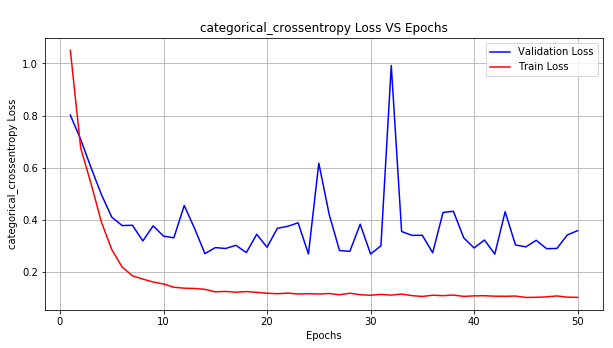

In [40]:
# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,51))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

In [35]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  0      357       133        0                   0   
STANDING                 0       60       472        0                   0   
WALKING                  0        0         1      472                  14   
WALKING_DOWNSTAIRS       0        0         0        1                 417   
WALKING_UPSTAIRS         0        0         0        9                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            1  
STANDING                           0  
WALKING                            9  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 444  


In [36]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 117us/step


In [37]:
score

[0.3591722217254519, 0.9155072955548015]

### 2. Trying 2  LSTM layer

In [42]:
batch_size=64

In [50]:
def create_model(dropout_rate=0.0,n_hidden=32):
    # default values
    model = Sequential()
# Configuring the parameters
    model.add(CuDNNLSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
#Adding batch normnalization
    model.add(BatchNormalization())
# Adding a dropout layer
    model.add(Dropout(0.1))
#adding 2nd lstm layer
    model.add(CuDNNLSTM(n_hidden))
    model.add(Dropout(dropout_rate))
# Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model,verbose=1)

# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_hidden = [16,32,64,128]
epochs=[30,40,50]

param_distributions  = dict(dropout_rate=dropout_rate,n_hidden=n_hidden,epochs=epochs)

grid = RandomizedSearchCV(estimator=model, param_distributions =param_distributions ,cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
4901/4901 [==============================] - ETA: 5:48 - loss: 1.7566 - acc: 0.093 - ETA: 1:09 - loss: 1.5530 - acc: 0.431 - ETA: 38s - loss: 1.4320 - acc: 0.513 - ETA: 26s - loss: 1.3590 - acc: 0.53 - ETA: 18s - loss: 1.2824 - acc: 0.55 - ETA: 14s - loss: 1.2058 - acc: 0.58 - ETA: 12s - loss: 1.1696 - acc: 0.59 - ETA: 10s - loss: 1.1259 - acc: 0.60 - ETA: 8s - loss: 1.0889 - acc: 0.6174 - ETA: 7s - loss: 1.0566 - acc: 0.626 - ETA: 6s - loss: 1.0219 - acc: 0.639 - ETA: 5s - loss: 0.9918 - acc: 0.652 - ETA: 5s - loss: 0.9659 - acc: 0.663 - ETA: 4s - loss: 0.9422 - acc: 0.671 - ETA: 3s - loss: 0.9321 - acc: 0.668 - ETA: 3s - loss: 0.9263 - acc: 0.669 - ETA: 3s - loss: 0.9145 - acc: 0.674 - ETA: 2s - loss: 0.9096 - acc: 0.676 - ETA: 2s - loss: 0.8913 - acc: 0.686 - ETA: 2s - loss: 0.8766 - acc: 0.692 - ETA: 2s - loss: 0.8581 - acc: 0.699 - ETA: 1s - loss: 0.8383 - acc: 0.708 - ETA: 1s - loss: 0.8246 - acc: 0.713 - ETA: 1s - loss: 0.8094 - acc: 0.719 - ETA: 1s - loss: 0.7943 - a

4901/4901 [==============================] - ETA: 1s - loss: 0.1317 - acc: 0.906 - ETA: 1s - loss: 0.1171 - acc: 0.942 - ETA: 1s - loss: 0.1114 - acc: 0.954 - ETA: 1s - loss: 0.1238 - acc: 0.955 - ETA: 1s - loss: 0.1152 - acc: 0.959 - ETA: 1s - loss: 0.1174 - acc: 0.956 - ETA: 1s - loss: 0.1206 - acc: 0.952 - ETA: 1s - loss: 0.1216 - acc: 0.951 - ETA: 1s - loss: 0.1209 - acc: 0.953 - ETA: 1s - loss: 0.1208 - acc: 0.952 - ETA: 1s - loss: 0.1199 - acc: 0.953 - ETA: 1s - loss: 0.1183 - acc: 0.953 - ETA: 1s - loss: 0.1154 - acc: 0.953 - ETA: 1s - loss: 0.1154 - acc: 0.952 - ETA: 1s - loss: 0.1133 - acc: 0.954 - ETA: 0s - loss: 0.1137 - acc: 0.954 - ETA: 0s - loss: 0.1108 - acc: 0.956 - ETA: 0s - loss: 0.1096 - acc: 0.957 - ETA: 0s - loss: 0.1129 - acc: 0.955 - ETA: 0s - loss: 0.1139 - acc: 0.954 - ETA: 0s - loss: 0.1130 - acc: 0.954 - ETA: 0s - loss: 0.1129 - acc: 0.953 - ETA: 0s - loss: 0.1156 - acc: 0.952 - ETA: 0s - loss: 0.1152 - acc: 0.952 - ETA: 0s - loss: 0.1145 - acc: 0.952 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1816 - acc: 0.937 - ETA: 1s - loss: 0.0711 - acc: 0.968 - ETA: 1s - loss: 0.0589 - acc: 0.978 - ETA: 1s - loss: 0.0839 - acc: 0.968 - ETA: 1s - loss: 0.0851 - acc: 0.968 - ETA: 1s - loss: 0.0866 - acc: 0.967 - ETA: 1s - loss: 0.0918 - acc: 0.966 - ETA: 1s - loss: 0.0963 - acc: 0.966 - ETA: 1s - loss: 0.0945 - acc: 0.966 - ETA: 1s - loss: 0.0998 - acc: 0.964 - ETA: 1s - loss: 0.1009 - acc: 0.962 - ETA: 1s - loss: 0.1005 - acc: 0.960 - ETA: 1s - loss: 0.1013 - acc: 0.959 - ETA: 1s - loss: 0.1002 - acc: 0.961 - ETA: 1s - loss: 0.1034 - acc: 0.960 - ETA: 1s - loss: 0.1048 - acc: 0.959 - ETA: 1s - loss: 0.1053 - acc: 0.959 - ETA: 0s - loss: 0.1033 - acc: 0.959 - ETA: 0s - loss: 0.1000 - acc: 0.961 - ETA: 0s - loss: 0.0995 - acc: 0.961 - ETA: 0s - loss: 0.0994 - acc: 0.960 - ETA: 0s - loss: 0.1017 - acc: 0.960 - ETA: 0s - loss: 0.1001 - acc: 0.961 - ETA: 0s - loss: 0.1020 - acc: 0.960 - ETA: 0s - loss: 0.1023 - acc: 0.960 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1768 - acc: 0.937 - ETA: 1s - loss: 0.0800 - acc: 0.968 - ETA: 1s - loss: 0.0794 - acc: 0.968 - ETA: 1s - loss: 0.0708 - acc: 0.974 - ETA: 1s - loss: 0.0765 - acc: 0.971 - ETA: 1s - loss: 0.0700 - acc: 0.974 - ETA: 1s - loss: 0.0812 - acc: 0.970 - ETA: 1s - loss: 0.0844 - acc: 0.969 - ETA: 1s - loss: 0.0849 - acc: 0.968 - ETA: 1s - loss: 0.0847 - acc: 0.968 - ETA: 1s - loss: 0.0894 - acc: 0.964 - ETA: 1s - loss: 0.0895 - acc: 0.964 - ETA: 1s - loss: 0.0853 - acc: 0.966 - ETA: 1s - loss: 0.0888 - acc: 0.965 - ETA: 1s - loss: 0.0883 - acc: 0.964 - ETA: 0s - loss: 0.0865 - acc: 0.964 - ETA: 0s - loss: 0.0852 - acc: 0.965 - ETA: 0s - loss: 0.0871 - acc: 0.965 - ETA: 0s - loss: 0.0870 - acc: 0.965 - ETA: 0s - loss: 0.0888 - acc: 0.964 - ETA: 0s - loss: 0.0873 - acc: 0.965 - ETA: 0s - loss: 0.0879 - acc: 0.964 - ETA: 0s - loss: 0.0874 - acc: 0.964 - ETA: 0s - loss: 0.0868 - acc: 0.963 - ETA: 0s - loss: 0.0883 - acc: 0.963 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.4131 - acc: 0.875 - ETA: 1s - loss: 0.1517 - acc: 0.943 - ETA: 1s - loss: 0.1174 - acc: 0.951 - ETA: 1s - loss: 0.1010 - acc: 0.954 - ETA: 1s - loss: 0.0886 - acc: 0.961 - ETA: 1s - loss: 0.0893 - acc: 0.961 - ETA: 1s - loss: 0.0807 - acc: 0.966 - ETA: 1s - loss: 0.0751 - acc: 0.968 - ETA: 1s - loss: 0.0751 - acc: 0.968 - ETA: 1s - loss: 0.0784 - acc: 0.967 - ETA: 1s - loss: 0.0747 - acc: 0.969 - ETA: 1s - loss: 0.0824 - acc: 0.968 - ETA: 1s - loss: 0.0813 - acc: 0.967 - ETA: 1s - loss: 0.0842 - acc: 0.966 - ETA: 1s - loss: 0.0836 - acc: 0.967 - ETA: 1s - loss: 0.0840 - acc: 0.965 - ETA: 1s - loss: 0.0839 - acc: 0.964 - ETA: 1s - loss: 0.0827 - acc: 0.965 - ETA: 1s - loss: 0.0810 - acc: 0.966 - ETA: 1s - loss: 0.0802 - acc: 0.965 - ETA: 0s - loss: 0.0805 - acc: 0.966 - ETA: 0s - loss: 0.0808 - acc: 0.965 - ETA: 0s - loss: 0.0834 - acc: 0.965 - ETA: 0s - loss: 0.0823 - acc: 0.966 - ETA: 0s - loss: 0.0831 - acc: 0.966 - ETA: 

Epoch 3/50
4901/4901 [==============================] - ETA: 2s - loss: 0.2113 - acc: 0.906 - ETA: 2s - loss: 0.1708 - acc: 0.937 - ETA: 1s - loss: 0.1892 - acc: 0.930 - ETA: 1s - loss: 0.1834 - acc: 0.925 - ETA: 1s - loss: 0.1790 - acc: 0.935 - ETA: 1s - loss: 0.1769 - acc: 0.939 - ETA: 1s - loss: 0.1733 - acc: 0.942 - ETA: 1s - loss: 0.1708 - acc: 0.944 - ETA: 1s - loss: 0.1705 - acc: 0.941 - ETA: 1s - loss: 0.1713 - acc: 0.941 - ETA: 1s - loss: 0.1916 - acc: 0.936 - ETA: 1s - loss: 0.1866 - acc: 0.938 - ETA: 1s - loss: 0.1766 - acc: 0.942 - ETA: 1s - loss: 0.1775 - acc: 0.941 - ETA: 1s - loss: 0.1748 - acc: 0.942 - ETA: 1s - loss: 0.1709 - acc: 0.944 - ETA: 1s - loss: 0.1697 - acc: 0.944 - ETA: 1s - loss: 0.1686 - acc: 0.945 - ETA: 1s - loss: 0.1694 - acc: 0.945 - ETA: 1s - loss: 0.1685 - acc: 0.946 - ETA: 0s - loss: 0.1675 - acc: 0.946 - ETA: 0s - loss: 0.1665 - acc: 0.947 - ETA: 0s - loss: 0.1673 - acc: 0.947 - ETA: 0s - loss: 0.1682 - acc: 0.947 - ETA: 0s - loss: 0.1673 - acc: 0.

4901/4901 [==============================] - ETA: 1s - loss: 0.0655 - acc: 0.968 - ETA: 1s - loss: 0.1402 - acc: 0.943 - ETA: 1s - loss: 0.1260 - acc: 0.954 - ETA: 1s - loss: 0.1375 - acc: 0.954 - ETA: 1s - loss: 0.1378 - acc: 0.946 - ETA: 1s - loss: 0.1427 - acc: 0.942 - ETA: 1s - loss: 0.1337 - acc: 0.950 - ETA: 1s - loss: 0.1300 - acc: 0.950 - ETA: 1s - loss: 0.1268 - acc: 0.950 - ETA: 1s - loss: 0.1200 - acc: 0.952 - ETA: 1s - loss: 0.1237 - acc: 0.951 - ETA: 1s - loss: 0.1253 - acc: 0.949 - ETA: 1s - loss: 0.1239 - acc: 0.951 - ETA: 1s - loss: 0.1208 - acc: 0.952 - ETA: 1s - loss: 0.1174 - acc: 0.953 - ETA: 1s - loss: 0.1210 - acc: 0.952 - ETA: 1s - loss: 0.1201 - acc: 0.953 - ETA: 1s - loss: 0.1154 - acc: 0.955 - ETA: 1s - loss: 0.1151 - acc: 0.955 - ETA: 1s - loss: 0.1120 - acc: 0.956 - ETA: 0s - loss: 0.1118 - acc: 0.956 - ETA: 0s - loss: 0.1145 - acc: 0.955 - ETA: 0s - loss: 0.1154 - acc: 0.955 - ETA: 0s - loss: 0.1147 - acc: 0.955 - ETA: 0s - loss: 0.1157 - acc: 0.955 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.1005 - acc: 0.968 - ETA: 2s - loss: 0.0873 - acc: 0.968 - ETA: 2s - loss: 0.1184 - acc: 0.937 - ETA: 1s - loss: 0.1016 - acc: 0.944 - ETA: 1s - loss: 0.0987 - acc: 0.950 - ETA: 1s - loss: 0.0957 - acc: 0.953 - ETA: 1s - loss: 0.0932 - acc: 0.957 - ETA: 1s - loss: 0.1066 - acc: 0.954 - ETA: 1s - loss: 0.0983 - acc: 0.959 - ETA: 1s - loss: 0.1101 - acc: 0.955 - ETA: 1s - loss: 0.1114 - acc: 0.955 - ETA: 1s - loss: 0.1083 - acc: 0.955 - ETA: 1s - loss: 0.1105 - acc: 0.953 - ETA: 1s - loss: 0.1085 - acc: 0.953 - ETA: 1s - loss: 0.1076 - acc: 0.953 - ETA: 1s - loss: 0.1043 - acc: 0.955 - ETA: 1s - loss: 0.1060 - acc: 0.956 - ETA: 1s - loss: 0.1058 - acc: 0.956 - ETA: 1s - loss: 0.1110 - acc: 0.955 - ETA: 1s - loss: 0.1128 - acc: 0.955 - ETA: 0s - loss: 0.1113 - acc: 0.956 - ETA: 0s - loss: 0.1085 - acc: 0.958 - ETA: 0s - loss: 0.1106 - acc: 0.957 - ETA: 0s - loss: 0.1079 - acc: 0.958 - ETA: 0s - loss: 0.1073 - acc: 0.959 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0584 - acc: 0.968 - ETA: 1s - loss: 0.0926 - acc: 0.956 - ETA: 1s - loss: 0.0705 - acc: 0.968 - ETA: 1s - loss: 0.0795 - acc: 0.963 - ETA: 1s - loss: 0.0853 - acc: 0.957 - ETA: 1s - loss: 0.0760 - acc: 0.962 - ETA: 1s - loss: 0.0751 - acc: 0.965 - ETA: 1s - loss: 0.0714 - acc: 0.967 - ETA: 1s - loss: 0.0706 - acc: 0.966 - ETA: 1s - loss: 0.0768 - acc: 0.964 - ETA: 1s - loss: 0.0807 - acc: 0.963 - ETA: 1s - loss: 0.0828 - acc: 0.962 - ETA: 1s - loss: 0.0878 - acc: 0.961 - ETA: 1s - loss: 0.0893 - acc: 0.959 - ETA: 1s - loss: 0.0876 - acc: 0.960 - ETA: 1s - loss: 0.0874 - acc: 0.959 - ETA: 1s - loss: 0.0870 - acc: 0.959 - ETA: 1s - loss: 0.0878 - acc: 0.959 - ETA: 1s - loss: 0.0891 - acc: 0.958 - ETA: 1s - loss: 0.0862 - acc: 0.960 - ETA: 0s - loss: 0.0845 - acc: 0.961 - ETA: 0s - loss: 0.0932 - acc: 0.959 - ETA: 0s - loss: 0.0943 - acc: 0.958 - ETA: 0s - loss: 0.0954 - acc: 0.958 - ETA: 0s - loss: 0.0982 - acc: 0.959 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1184 - acc: 0.937 - ETA: 1s - loss: 0.0688 - acc: 0.975 - ETA: 1s - loss: 0.0668 - acc: 0.975 - ETA: 1s - loss: 0.0784 - acc: 0.976 - ETA: 1s - loss: 0.0785 - acc: 0.976 - ETA: 1s - loss: 0.0990 - acc: 0.971 - ETA: 1s - loss: 0.0981 - acc: 0.968 - ETA: 1s - loss: 0.1021 - acc: 0.964 - ETA: 1s - loss: 0.0992 - acc: 0.963 - ETA: 1s - loss: 0.0964 - acc: 0.962 - ETA: 1s - loss: 0.0914 - acc: 0.964 - ETA: 1s - loss: 0.0877 - acc: 0.964 - ETA: 1s - loss: 0.0944 - acc: 0.964 - ETA: 1s - loss: 0.1063 - acc: 0.962 - ETA: 1s - loss: 0.1038 - acc: 0.963 - ETA: 1s - loss: 0.0988 - acc: 0.965 - ETA: 1s - loss: 0.1051 - acc: 0.965 - ETA: 1s - loss: 0.1089 - acc: 0.964 - ETA: 1s - loss: 0.1070 - acc: 0.964 - ETA: 1s - loss: 0.1043 - acc: 0.965 - ETA: 0s - loss: 0.1030 - acc: 0.964 - ETA: 0s - loss: 0.1027 - acc: 0.964 - ETA: 0s - loss: 0.1005 - acc: 0.964 - ETA: 0s - loss: 0.0980 - acc: 0.965 - ETA: 0s - loss: 0.0960 - acc: 0.966 - ETA: 

Epoch 3/50
4902/4902 [==============================] - ETA: 2s - loss: 0.1160 - acc: 0.968 - ETA: 2s - loss: 0.2107 - acc: 0.931 - ETA: 2s - loss: 0.2181 - acc: 0.916 - ETA: 1s - loss: 0.2083 - acc: 0.920 - ETA: 1s - loss: 0.1973 - acc: 0.926 - ETA: 1s - loss: 0.1847 - acc: 0.931 - ETA: 1s - loss: 0.1841 - acc: 0.930 - ETA: 1s - loss: 0.1866 - acc: 0.931 - ETA: 1s - loss: 0.1903 - acc: 0.930 - ETA: 1s - loss: 0.1934 - acc: 0.929 - ETA: 1s - loss: 0.1965 - acc: 0.928 - ETA: 1s - loss: 0.1908 - acc: 0.931 - ETA: 1s - loss: 0.1981 - acc: 0.931 - ETA: 1s - loss: 0.1923 - acc: 0.932 - ETA: 1s - loss: 0.1885 - acc: 0.932 - ETA: 1s - loss: 0.1885 - acc: 0.932 - ETA: 1s - loss: 0.2037 - acc: 0.931 - ETA: 1s - loss: 0.2129 - acc: 0.928 - ETA: 1s - loss: 0.2080 - acc: 0.930 - ETA: 1s - loss: 0.2042 - acc: 0.931 - ETA: 1s - loss: 0.2033 - acc: 0.932 - ETA: 0s - loss: 0.1995 - acc: 0.933 - ETA: 0s - loss: 0.1979 - acc: 0.934 - ETA: 0s - loss: 0.1951 - acc: 0.934 - ETA: 0s - loss: 0.1947 - acc: 0.

4902/4902 [==============================] - ETA: 1s - loss: 0.0785 - acc: 0.968 - ETA: 1s - loss: 0.0962 - acc: 0.956 - ETA: 1s - loss: 0.0923 - acc: 0.965 - ETA: 1s - loss: 0.0965 - acc: 0.961 - ETA: 1s - loss: 0.1191 - acc: 0.950 - ETA: 1s - loss: 0.1168 - acc: 0.949 - ETA: 1s - loss: 0.1132 - acc: 0.952 - ETA: 1s - loss: 0.1075 - acc: 0.955 - ETA: 1s - loss: 0.1057 - acc: 0.955 - ETA: 1s - loss: 0.1064 - acc: 0.955 - ETA: 1s - loss: 0.1102 - acc: 0.954 - ETA: 1s - loss: 0.1090 - acc: 0.952 - ETA: 1s - loss: 0.1095 - acc: 0.953 - ETA: 1s - loss: 0.1092 - acc: 0.951 - ETA: 1s - loss: 0.1108 - acc: 0.950 - ETA: 1s - loss: 0.1107 - acc: 0.950 - ETA: 1s - loss: 0.1112 - acc: 0.950 - ETA: 1s - loss: 0.1092 - acc: 0.950 - ETA: 1s - loss: 0.1103 - acc: 0.949 - ETA: 1s - loss: 0.1088 - acc: 0.949 - ETA: 0s - loss: 0.1084 - acc: 0.948 - ETA: 0s - loss: 0.1099 - acc: 0.948 - ETA: 0s - loss: 0.1093 - acc: 0.947 - ETA: 0s - loss: 0.1082 - acc: 0.947 - ETA: 0s - loss: 0.1077 - acc: 0.948 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.0278 - acc: 0.968 - ETA: 2s - loss: 0.0815 - acc: 0.968 - ETA: 1s - loss: 0.0896 - acc: 0.958 - ETA: 1s - loss: 0.0861 - acc: 0.961 - ETA: 1s - loss: 0.0912 - acc: 0.961 - ETA: 1s - loss: 0.0979 - acc: 0.962 - ETA: 1s - loss: 0.1058 - acc: 0.958 - ETA: 1s - loss: 0.1117 - acc: 0.952 - ETA: 1s - loss: 0.1206 - acc: 0.951 - ETA: 1s - loss: 0.1188 - acc: 0.952 - ETA: 1s - loss: 0.1230 - acc: 0.954 - ETA: 1s - loss: 0.1174 - acc: 0.955 - ETA: 1s - loss: 0.1183 - acc: 0.954 - ETA: 1s - loss: 0.1171 - acc: 0.955 - ETA: 1s - loss: 0.1156 - acc: 0.956 - ETA: 1s - loss: 0.1190 - acc: 0.953 - ETA: 1s - loss: 0.1189 - acc: 0.954 - ETA: 1s - loss: 0.1168 - acc: 0.955 - ETA: 1s - loss: 0.1135 - acc: 0.956 - ETA: 1s - loss: 0.1140 - acc: 0.955 - ETA: 1s - loss: 0.1150 - acc: 0.954 - ETA: 0s - loss: 0.1220 - acc: 0.952 - ETA: 0s - loss: 0.1197 - acc: 0.952 - ETA: 0s - loss: 0.1172 - acc: 0.954 - ETA: 0s - loss: 0.1166 - acc: 0.953 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.1474 - acc: 0.968 - ETA: 2s - loss: 0.1140 - acc: 0.962 - ETA: 1s - loss: 0.1109 - acc: 0.965 - ETA: 1s - loss: 0.0864 - acc: 0.973 - ETA: 1s - loss: 0.0775 - acc: 0.974 - ETA: 1s - loss: 0.0802 - acc: 0.973 - ETA: 1s - loss: 0.0923 - acc: 0.971 - ETA: 1s - loss: 0.1045 - acc: 0.965 - ETA: 1s - loss: 0.1000 - acc: 0.965 - ETA: 1s - loss: 0.0978 - acc: 0.965 - ETA: 1s - loss: 0.0978 - acc: 0.964 - ETA: 1s - loss: 0.1051 - acc: 0.961 - ETA: 1s - loss: 0.1006 - acc: 0.964 - ETA: 1s - loss: 0.0976 - acc: 0.964 - ETA: 1s - loss: 0.0965 - acc: 0.964 - ETA: 1s - loss: 0.0960 - acc: 0.963 - ETA: 1s - loss: 0.0981 - acc: 0.962 - ETA: 1s - loss: 0.0980 - acc: 0.963 - ETA: 1s - loss: 0.1002 - acc: 0.961 - ETA: 1s - loss: 0.1029 - acc: 0.961 - ETA: 0s - loss: 0.1026 - acc: 0.960 - ETA: 0s - loss: 0.1010 - acc: 0.961 - ETA: 0s - loss: 0.1058 - acc: 0.960 - ETA: 0s - loss: 0.1031 - acc: 0.960 - ETA: 0s - loss: 0.1015 - acc: 0.961 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.0734 - acc: 0.968 - ETA: 2s - loss: 0.0834 - acc: 0.975 - ETA: 1s - loss: 0.0970 - acc: 0.954 - ETA: 1s - loss: 0.0902 - acc: 0.954 - ETA: 1s - loss: 0.0887 - acc: 0.952 - ETA: 1s - loss: 0.0914 - acc: 0.949 - ETA: 1s - loss: 0.0908 - acc: 0.952 - ETA: 1s - loss: 0.0892 - acc: 0.953 - ETA: 1s - loss: 0.0852 - acc: 0.953 - ETA: 1s - loss: 0.0966 - acc: 0.951 - ETA: 1s - loss: 0.0943 - acc: 0.953 - ETA: 1s - loss: 0.0926 - acc: 0.953 - ETA: 1s - loss: 0.0942 - acc: 0.954 - ETA: 1s - loss: 0.0920 - acc: 0.953 - ETA: 1s - loss: 0.0976 - acc: 0.952 - ETA: 1s - loss: 0.0966 - acc: 0.951 - ETA: 1s - loss: 0.0956 - acc: 0.951 - ETA: 1s - loss: 0.0986 - acc: 0.952 - ETA: 1s - loss: 0.0973 - acc: 0.953 - ETA: 1s - loss: 0.0944 - acc: 0.953 - ETA: 0s - loss: 0.0919 - acc: 0.954 - ETA: 0s - loss: 0.0909 - acc: 0.954 - ETA: 0s - loss: 0.0880 - acc: 0.956 - ETA: 0s - loss: 0.0895 - acc: 0.956 - ETA: 0s - loss: 0.0886 - acc: 0.957 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.7786 - acc: 0.750 - ETA: 1s - loss: 0.7567 - acc: 0.812 - ETA: 1s - loss: 0.7297 - acc: 0.818 - ETA: 1s - loss: 0.7482 - acc: 0.816 - ETA: 1s - loss: 0.7196 - acc: 0.821 - ETA: 1s - loss: 0.7277 - acc: 0.816 - ETA: 1s - loss: 0.7273 - acc: 0.812 - ETA: 1s - loss: 0.7185 - acc: 0.812 - ETA: 1s - loss: 0.7187 - acc: 0.803 - ETA: 1s - loss: 0.7196 - acc: 0.800 - ETA: 1s - loss: 0.7148 - acc: 0.798 - ETA: 1s - loss: 0.7174 - acc: 0.798 - ETA: 1s - loss: 0.7187 - acc: 0.796 - ETA: 1s - loss: 0.7183 - acc: 0.796 - ETA: 1s - loss: 0.7192 - acc: 0.793 - ETA: 0s - loss: 0.7180 - acc: 0.793 - ETA: 0s - loss: 0.7208 - acc: 0.791 - ETA: 0s - loss: 0.7178 - acc: 0.792 - ETA: 0s - loss: 0.7164 - acc: 0.789 - ETA: 0s - loss: 0.7142 - acc: 0.790 - ETA: 0s - loss: 0.7139 - acc: 0.788 - ETA: 0s - loss: 0.7147 - acc: 0.786 - ETA: 0s - loss: 0.7153 - acc: 0.786 - ETA: 0s - loss: 0.7143 - acc: 0.786 - ETA: 0s - loss: 0.7131 - acc: 0.785 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2549 - acc: 0.906 - ETA: 1s - loss: 0.1765 - acc: 0.953 - ETA: 1s - loss: 0.1790 - acc: 0.954 - ETA: 1s - loss: 0.1765 - acc: 0.950 - ETA: 1s - loss: 0.1903 - acc: 0.950 - ETA: 1s - loss: 0.1945 - acc: 0.946 - ETA: 1s - loss: 0.1946 - acc: 0.942 - ETA: 1s - loss: 0.2047 - acc: 0.939 - ETA: 1s - loss: 0.2050 - acc: 0.935 - ETA: 1s - loss: 0.2060 - acc: 0.935 - ETA: 1s - loss: 0.2018 - acc: 0.938 - ETA: 1s - loss: 0.2030 - acc: 0.936 - ETA: 1s - loss: 0.2041 - acc: 0.938 - ETA: 1s - loss: 0.1985 - acc: 0.940 - ETA: 1s - loss: 0.1994 - acc: 0.941 - ETA: 1s - loss: 0.2029 - acc: 0.938 - ETA: 0s - loss: 0.2021 - acc: 0.939 - ETA: 0s - loss: 0.1994 - acc: 0.939 - ETA: 0s - loss: 0.2019 - acc: 0.938 - ETA: 0s - loss: 0.2017 - acc: 0.938 - ETA: 0s - loss: 0.2019 - acc: 0.937 - ETA: 0s - loss: 0.2047 - acc: 0.936 - ETA: 0s - loss: 0.2017 - acc: 0.938 - ETA: 0s - loss: 0.2025 - acc: 0.938 - ETA: 0s - loss: 0.2049 - acc: 0.936 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1034 - acc: 0.968 - ETA: 1s - loss: 0.1650 - acc: 0.942 - ETA: 1s - loss: 0.1537 - acc: 0.943 - ETA: 1s - loss: 0.1529 - acc: 0.947 - ETA: 1s - loss: 0.1520 - acc: 0.946 - ETA: 1s - loss: 0.1401 - acc: 0.954 - ETA: 1s - loss: 0.1386 - acc: 0.957 - ETA: 1s - loss: 0.1409 - acc: 0.956 - ETA: 1s - loss: 0.1429 - acc: 0.956 - ETA: 1s - loss: 0.1537 - acc: 0.952 - ETA: 1s - loss: 0.1667 - acc: 0.947 - ETA: 1s - loss: 0.1689 - acc: 0.945 - ETA: 1s - loss: 0.1668 - acc: 0.947 - ETA: 1s - loss: 0.1639 - acc: 0.949 - ETA: 1s - loss: 0.1672 - acc: 0.945 - ETA: 0s - loss: 0.1673 - acc: 0.944 - ETA: 0s - loss: 0.1658 - acc: 0.945 - ETA: 0s - loss: 0.1647 - acc: 0.945 - ETA: 0s - loss: 0.1657 - acc: 0.944 - ETA: 0s - loss: 0.1653 - acc: 0.944 - ETA: 0s - loss: 0.1666 - acc: 0.944 - ETA: 0s - loss: 0.1714 - acc: 0.945 - ETA: 0s - loss: 0.1710 - acc: 0.945 - ETA: 0s - loss: 0.1715 - acc: 0.945 - ETA: 0s - loss: 0.1682 - acc: 0.947 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2907 - acc: 0.875 - ETA: 1s - loss: 0.3262 - acc: 0.895 - ETA: 1s - loss: 0.3325 - acc: 0.896 - ETA: 1s - loss: 0.3369 - acc: 0.902 - ETA: 1s - loss: 0.3341 - acc: 0.900 - ETA: 1s - loss: 0.3203 - acc: 0.910 - ETA: 1s - loss: 0.3160 - acc: 0.911 - ETA: 1s - loss: 0.3030 - acc: 0.918 - ETA: 1s - loss: 0.3018 - acc: 0.920 - ETA: 1s - loss: 0.3105 - acc: 0.921 - ETA: 1s - loss: 0.3106 - acc: 0.920 - ETA: 1s - loss: 0.3122 - acc: 0.921 - ETA: 1s - loss: 0.3080 - acc: 0.923 - ETA: 1s - loss: 0.3151 - acc: 0.919 - ETA: 1s - loss: 0.3140 - acc: 0.920 - ETA: 1s - loss: 0.3104 - acc: 0.921 - ETA: 0s - loss: 0.3140 - acc: 0.920 - ETA: 0s - loss: 0.3124 - acc: 0.921 - ETA: 0s - loss: 0.3115 - acc: 0.922 - ETA: 0s - loss: 0.3128 - acc: 0.923 - ETA: 0s - loss: 0.3138 - acc: 0.922 - ETA: 0s - loss: 0.3204 - acc: 0.921 - ETA: 0s - loss: 0.3252 - acc: 0.918 - ETA: 0s - loss: 0.3271 - acc: 0.918 - ETA: 0s - loss: 0.3260 - acc: 0.918 - ETA: 

Epoch 18/30
4901/4901 [==============================] - ETA: 1s - loss: 0.1646 - acc: 0.968 - ETA: 1s - loss: 0.1290 - acc: 0.975 - ETA: 1s - loss: 0.1460 - acc: 0.968 - ETA: 1s - loss: 0.1864 - acc: 0.971 - ETA: 1s - loss: 0.1851 - acc: 0.967 - ETA: 1s - loss: 0.1705 - acc: 0.971 - ETA: 1s - loss: 0.1587 - acc: 0.972 - ETA: 1s - loss: 0.1739 - acc: 0.962 - ETA: 1s - loss: 0.1742 - acc: 0.962 - ETA: 1s - loss: 0.1735 - acc: 0.958 - ETA: 1s - loss: 0.1693 - acc: 0.959 - ETA: 1s - loss: 0.1783 - acc: 0.954 - ETA: 1s - loss: 0.1813 - acc: 0.955 - ETA: 1s - loss: 0.1828 - acc: 0.954 - ETA: 1s - loss: 0.1810 - acc: 0.953 - ETA: 1s - loss: 0.1788 - acc: 0.954 - ETA: 0s - loss: 0.1800 - acc: 0.951 - ETA: 0s - loss: 0.1787 - acc: 0.951 - ETA: 0s - loss: 0.1774 - acc: 0.952 - ETA: 0s - loss: 0.1755 - acc: 0.952 - ETA: 0s - loss: 0.1772 - acc: 0.951 - ETA: 0s - loss: 0.1781 - acc: 0.951 - ETA: 0s - loss: 0.1767 - acc: 0.951 - ETA: 0s - loss: 0.1766 - acc: 0.952 - ETA: 0s - loss: 0.1801 - acc: 0

Epoch 29/30
4901/4901 [==============================] - ETA: 1s - loss: 0.1421 - acc: 0.937 - ETA: 1s - loss: 0.1429 - acc: 0.947 - ETA: 1s - loss: 0.1314 - acc: 0.957 - ETA: 1s - loss: 0.1392 - acc: 0.954 - ETA: 1s - loss: 0.1401 - acc: 0.956 - ETA: 1s - loss: 0.1387 - acc: 0.955 - ETA: 1s - loss: 0.1302 - acc: 0.960 - ETA: 1s - loss: 0.1349 - acc: 0.956 - ETA: 1s - loss: 0.1321 - acc: 0.958 - ETA: 1s - loss: 0.1381 - acc: 0.956 - ETA: 1s - loss: 0.1353 - acc: 0.957 - ETA: 1s - loss: 0.1437 - acc: 0.953 - ETA: 1s - loss: 0.1550 - acc: 0.950 - ETA: 1s - loss: 0.1537 - acc: 0.950 - ETA: 1s - loss: 0.1518 - acc: 0.951 - ETA: 1s - loss: 0.1512 - acc: 0.951 - ETA: 0s - loss: 0.1484 - acc: 0.952 - ETA: 0s - loss: 0.1457 - acc: 0.952 - ETA: 0s - loss: 0.1443 - acc: 0.952 - ETA: 0s - loss: 0.1440 - acc: 0.952 - ETA: 0s - loss: 0.1423 - acc: 0.953 - ETA: 0s - loss: 0.1405 - acc: 0.953 - ETA: 0s - loss: 0.1460 - acc: 0.951 - ETA: 0s - loss: 0.1444 - acc: 0.951 - ETA: 0s - loss: 0.1459 - acc: 0

4902/4902 [==============================] - ETA: 1s - loss: 0.3357 - acc: 0.906 - ETA: 1s - loss: 0.3186 - acc: 0.906 - ETA: 1s - loss: 0.2946 - acc: 0.909 - ETA: 1s - loss: 0.2832 - acc: 0.906 - ETA: 1s - loss: 0.2691 - acc: 0.909 - ETA: 1s - loss: 0.2690 - acc: 0.916 - ETA: 1s - loss: 0.2652 - acc: 0.919 - ETA: 1s - loss: 0.2681 - acc: 0.922 - ETA: 1s - loss: 0.2697 - acc: 0.921 - ETA: 1s - loss: 0.2653 - acc: 0.921 - ETA: 1s - loss: 0.2619 - acc: 0.923 - ETA: 1s - loss: 0.2588 - acc: 0.926 - ETA: 1s - loss: 0.2562 - acc: 0.927 - ETA: 1s - loss: 0.2692 - acc: 0.921 - ETA: 1s - loss: 0.2675 - acc: 0.921 - ETA: 1s - loss: 0.2640 - acc: 0.922 - ETA: 1s - loss: 0.2635 - acc: 0.921 - ETA: 1s - loss: 0.2652 - acc: 0.918 - ETA: 0s - loss: 0.2620 - acc: 0.920 - ETA: 0s - loss: 0.2639 - acc: 0.919 - ETA: 0s - loss: 0.2614 - acc: 0.920 - ETA: 0s - loss: 0.2592 - acc: 0.921 - ETA: 0s - loss: 0.2602 - acc: 0.920 - ETA: 0s - loss: 0.2618 - acc: 0.920 - ETA: 0s - loss: 0.2598 - acc: 0.920 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1070 - acc: 0.937 - ETA: 1s - loss: 0.1192 - acc: 0.947 - ETA: 1s - loss: 0.1289 - acc: 0.946 - ETA: 1s - loss: 0.1601 - acc: 0.931 - ETA: 1s - loss: 0.1546 - acc: 0.937 - ETA: 1s - loss: 0.1646 - acc: 0.942 - ETA: 1s - loss: 0.1684 - acc: 0.941 - ETA: 1s - loss: 0.1617 - acc: 0.943 - ETA: 1s - loss: 0.1691 - acc: 0.941 - ETA: 1s - loss: 0.1715 - acc: 0.939 - ETA: 1s - loss: 0.1690 - acc: 0.939 - ETA: 1s - loss: 0.1685 - acc: 0.938 - ETA: 1s - loss: 0.1683 - acc: 0.938 - ETA: 1s - loss: 0.1681 - acc: 0.936 - ETA: 1s - loss: 0.1668 - acc: 0.937 - ETA: 1s - loss: 0.1697 - acc: 0.939 - ETA: 0s - loss: 0.1653 - acc: 0.941 - ETA: 0s - loss: 0.1612 - acc: 0.943 - ETA: 0s - loss: 0.1616 - acc: 0.943 - ETA: 0s - loss: 0.1578 - acc: 0.944 - ETA: 0s - loss: 0.1567 - acc: 0.944 - ETA: 0s - loss: 0.1595 - acc: 0.943 - ETA: 0s - loss: 0.1595 - acc: 0.942 - ETA: 0s - loss: 0.1594 - acc: 0.942 - ETA: 0s - loss: 0.1570 - acc: 0.943 - ETA: 

Epoch 30/30
4902/4902 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 175us/step
Epoch 1/50
4901/4901 [==============================] - ETA: 7:09 - loss: 1.7930 - acc: 0.250 - ETA: 1:10 - loss: 1.6836 - acc: 0.380 - ETA: 38s - loss: 1.6373 - acc: 0.417 - ETA: 27s - loss: 1.5974 - acc: 0.46 - ETA: 20s - loss: 1.5512 - acc: 0.50 - ETA: 15s - loss: 1.5197 - acc: 0.52 - ETA: 13s - loss: 1.4940 - acc: 0.53 - ETA: 11s - loss: 1.4808 - acc: 0.53 - ETA: 9s - loss: 1.4628 - acc: 0.5461 - ETA: 8s - loss: 1.4421 - acc: 0.554 - ETA: 7s - loss: 1.4260 - acc: 0.559 - ETA: 7s - loss: 1.4050 - acc: 0.568 - ETA: 6s - loss: 1.3872 - acc: 0.574 - ETA: 5s - loss: 1.3727 - acc: 0.579 - ETA: 5s - loss: 1.3627 - acc: 0.581 - ETA: 4s - loss: 1.3495 - acc: 0.584 - ETA: 4s - loss: 1.3387 - acc: 0.587 - ETA: 3s - loss: 1.3244 - acc: 0.595 - ETA: 3s - loss: 1.3142 - acc: 0.596 - ETA: 3s - loss: 1

4901/4901 [==============================] - ETA: 2s - loss: 0.1362 - acc: 0.968 - ETA: 1s - loss: 0.1519 - acc: 0.953 - ETA: 1s - loss: 0.1694 - acc: 0.946 - ETA: 1s - loss: 0.1678 - acc: 0.953 - ETA: 1s - loss: 0.1913 - acc: 0.947 - ETA: 1s - loss: 0.1869 - acc: 0.945 - ETA: 1s - loss: 0.1923 - acc: 0.943 - ETA: 1s - loss: 0.1876 - acc: 0.946 - ETA: 1s - loss: 0.1865 - acc: 0.950 - ETA: 1s - loss: 0.1822 - acc: 0.951 - ETA: 1s - loss: 0.1815 - acc: 0.950 - ETA: 1s - loss: 0.1873 - acc: 0.947 - ETA: 1s - loss: 0.1875 - acc: 0.947 - ETA: 1s - loss: 0.1874 - acc: 0.947 - ETA: 1s - loss: 0.1933 - acc: 0.944 - ETA: 1s - loss: 0.1954 - acc: 0.943 - ETA: 0s - loss: 0.1968 - acc: 0.944 - ETA: 0s - loss: 0.1969 - acc: 0.943 - ETA: 0s - loss: 0.1956 - acc: 0.944 - ETA: 0s - loss: 0.1954 - acc: 0.942 - ETA: 0s - loss: 0.1946 - acc: 0.942 - ETA: 0s - loss: 0.1971 - acc: 0.941 - ETA: 0s - loss: 0.1990 - acc: 0.939 - ETA: 0s - loss: 0.1981 - acc: 0.939 - ETA: 0s - loss: 0.1998 - acc: 0.938 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1846 - acc: 0.937 - ETA: 1s - loss: 0.1593 - acc: 0.937 - ETA: 1s - loss: 0.1340 - acc: 0.954 - ETA: 1s - loss: 0.1349 - acc: 0.953 - ETA: 1s - loss: 0.1414 - acc: 0.950 - ETA: 1s - loss: 0.1439 - acc: 0.948 - ETA: 1s - loss: 0.1470 - acc: 0.949 - ETA: 1s - loss: 0.1538 - acc: 0.943 - ETA: 1s - loss: 0.1545 - acc: 0.944 - ETA: 1s - loss: 0.1585 - acc: 0.940 - ETA: 1s - loss: 0.1631 - acc: 0.940 - ETA: 1s - loss: 0.1664 - acc: 0.936 - ETA: 1s - loss: 0.1637 - acc: 0.936 - ETA: 1s - loss: 0.1636 - acc: 0.937 - ETA: 1s - loss: 0.1601 - acc: 0.938 - ETA: 0s - loss: 0.1560 - acc: 0.939 - ETA: 0s - loss: 0.1557 - acc: 0.940 - ETA: 0s - loss: 0.1571 - acc: 0.939 - ETA: 0s - loss: 0.1551 - acc: 0.941 - ETA: 0s - loss: 0.1556 - acc: 0.940 - ETA: 0s - loss: 0.1591 - acc: 0.940 - ETA: 0s - loss: 0.1567 - acc: 0.941 - ETA: 0s - loss: 0.1552 - acc: 0.942 - ETA: 0s - loss: 0.1550 - acc: 0.942 - ETA: 0s - loss: 0.1521 - acc: 0.943 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0525 - acc: 0.968 - ETA: 1s - loss: 0.0914 - acc: 0.963 - ETA: 1s - loss: 0.1073 - acc: 0.960 - ETA: 1s - loss: 0.1236 - acc: 0.960 - ETA: 1s - loss: 0.1312 - acc: 0.950 - ETA: 1s - loss: 0.1354 - acc: 0.948 - ETA: 1s - loss: 0.1278 - acc: 0.951 - ETA: 1s - loss: 0.1238 - acc: 0.953 - ETA: 1s - loss: 0.1236 - acc: 0.953 - ETA: 1s - loss: 0.1237 - acc: 0.951 - ETA: 1s - loss: 0.1230 - acc: 0.950 - ETA: 1s - loss: 0.1239 - acc: 0.950 - ETA: 1s - loss: 0.1298 - acc: 0.948 - ETA: 1s - loss: 0.1279 - acc: 0.949 - ETA: 1s - loss: 0.1266 - acc: 0.949 - ETA: 0s - loss: 0.1294 - acc: 0.949 - ETA: 0s - loss: 0.1355 - acc: 0.947 - ETA: 0s - loss: 0.1362 - acc: 0.948 - ETA: 0s - loss: 0.1359 - acc: 0.948 - ETA: 0s - loss: 0.1351 - acc: 0.948 - ETA: 0s - loss: 0.1345 - acc: 0.949 - ETA: 0s - loss: 0.1330 - acc: 0.950 - ETA: 0s - loss: 0.1338 - acc: 0.949 - ETA: 0s - loss: 0.1363 - acc: 0.948 - ETA: 0s - loss: 0.1343 - acc: 0.949 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1028 - acc: 0.937 - ETA: 1s - loss: 0.0866 - acc: 0.958 - ETA: 1s - loss: 0.0929 - acc: 0.959 - ETA: 1s - loss: 0.1308 - acc: 0.957 - ETA: 1s - loss: 0.1259 - acc: 0.958 - ETA: 1s - loss: 0.1256 - acc: 0.960 - ETA: 1s - loss: 0.1239 - acc: 0.958 - ETA: 1s - loss: 0.1214 - acc: 0.956 - ETA: 1s - loss: 0.1211 - acc: 0.958 - ETA: 1s - loss: 0.1183 - acc: 0.958 - ETA: 1s - loss: 0.1157 - acc: 0.957 - ETA: 1s - loss: 0.1145 - acc: 0.956 - ETA: 1s - loss: 0.1145 - acc: 0.956 - ETA: 1s - loss: 0.1126 - acc: 0.957 - ETA: 1s - loss: 0.1173 - acc: 0.957 - ETA: 1s - loss: 0.1167 - acc: 0.958 - ETA: 1s - loss: 0.1178 - acc: 0.957 - ETA: 0s - loss: 0.1249 - acc: 0.956 - ETA: 0s - loss: 0.1247 - acc: 0.956 - ETA: 0s - loss: 0.1230 - acc: 0.957 - ETA: 0s - loss: 0.1205 - acc: 0.957 - ETA: 0s - loss: 0.1205 - acc: 0.957 - ETA: 0s - loss: 0.1175 - acc: 0.958 - ETA: 0s - loss: 0.1161 - acc: 0.959 - ETA: 0s - loss: 0.1146 - acc: 0.959 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.5749 - acc: 0.781 - ETA: 1s - loss: 0.5074 - acc: 0.859 - ETA: 1s - loss: 0.5028 - acc: 0.869 - ETA: 1s - loss: 0.5039 - acc: 0.853 - ETA: 1s - loss: 0.5170 - acc: 0.846 - ETA: 1s - loss: 0.5113 - acc: 0.853 - ETA: 1s - loss: 0.5155 - acc: 0.850 - ETA: 1s - loss: 0.5150 - acc: 0.849 - ETA: 1s - loss: 0.5104 - acc: 0.855 - ETA: 1s - loss: 0.5073 - acc: 0.859 - ETA: 1s - loss: 0.5065 - acc: 0.865 - ETA: 1s - loss: 0.5025 - acc: 0.866 - ETA: 1s - loss: 0.5050 - acc: 0.867 - ETA: 1s - loss: 0.5047 - acc: 0.866 - ETA: 1s - loss: 0.5059 - acc: 0.867 - ETA: 1s - loss: 0.5018 - acc: 0.869 - ETA: 1s - loss: 0.5018 - acc: 0.870 - ETA: 0s - loss: 0.5027 - acc: 0.871 - ETA: 0s - loss: 0.4953 - acc: 0.873 - ETA: 0s - loss: 0.4933 - acc: 0.874 - ETA: 0s - loss: 0.4898 - acc: 0.876 - ETA: 0s - loss: 0.4885 - acc: 0.877 - ETA: 0s - loss: 0.4811 - acc: 0.880 - ETA: 0s - loss: 0.4759 - acc: 0.882 - ETA: 0s - loss: 0.4724 - acc: 0.884 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0730 - acc: 1.000 - ETA: 1s - loss: 0.1228 - acc: 0.956 - ETA: 1s - loss: 0.1259 - acc: 0.950 - ETA: 1s - loss: 0.1237 - acc: 0.958 - ETA: 1s - loss: 0.1108 - acc: 0.965 - ETA: 1s - loss: 0.1090 - acc: 0.967 - ETA: 1s - loss: 0.1233 - acc: 0.962 - ETA: 1s - loss: 0.1345 - acc: 0.958 - ETA: 1s - loss: 0.1390 - acc: 0.955 - ETA: 1s - loss: 0.1418 - acc: 0.953 - ETA: 1s - loss: 0.1446 - acc: 0.951 - ETA: 1s - loss: 0.1425 - acc: 0.950 - ETA: 1s - loss: 0.1388 - acc: 0.952 - ETA: 1s - loss: 0.1366 - acc: 0.953 - ETA: 1s - loss: 0.1365 - acc: 0.953 - ETA: 0s - loss: 0.1347 - acc: 0.955 - ETA: 0s - loss: 0.1329 - acc: 0.956 - ETA: 0s - loss: 0.1306 - acc: 0.957 - ETA: 0s - loss: 0.1309 - acc: 0.958 - ETA: 0s - loss: 0.1326 - acc: 0.957 - ETA: 0s - loss: 0.1314 - acc: 0.957 - ETA: 0s - loss: 0.1315 - acc: 0.956 - ETA: 0s - loss: 0.1336 - acc: 0.955 - ETA: 0s - loss: 0.1355 - acc: 0.955 - ETA: 0s - loss: 0.1393 - acc: 0.954 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0725 - acc: 1.000 - ETA: 1s - loss: 0.1024 - acc: 0.963 - ETA: 1s - loss: 0.1178 - acc: 0.957 - ETA: 1s - loss: 0.1292 - acc: 0.951 - ETA: 1s - loss: 0.1366 - acc: 0.949 - ETA: 1s - loss: 0.1388 - acc: 0.947 - ETA: 1s - loss: 0.1376 - acc: 0.948 - ETA: 1s - loss: 0.1358 - acc: 0.948 - ETA: 1s - loss: 0.1401 - acc: 0.947 - ETA: 1s - loss: 0.1353 - acc: 0.949 - ETA: 1s - loss: 0.1304 - acc: 0.952 - ETA: 1s - loss: 0.1326 - acc: 0.953 - ETA: 1s - loss: 0.1279 - acc: 0.954 - ETA: 0s - loss: 0.1278 - acc: 0.955 - ETA: 0s - loss: 0.1251 - acc: 0.956 - ETA: 0s - loss: 0.1268 - acc: 0.953 - ETA: 0s - loss: 0.1269 - acc: 0.953 - ETA: 0s - loss: 0.1257 - acc: 0.953 - ETA: 0s - loss: 0.1242 - acc: 0.954 - ETA: 0s - loss: 0.1220 - acc: 0.954 - ETA: 0s - loss: 0.1206 - acc: 0.954 - ETA: 0s - loss: 0.1190 - acc: 0.955 - ETA: 0s - loss: 0.1176 - acc: 0.956 - ETA: 0s - loss: 0.1165 - acc: 0.956 - ETA: 0s - loss: 0.1169 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2091 - acc: 0.875 - ETA: 1s - loss: 0.1544 - acc: 0.942 - ETA: 1s - loss: 0.1430 - acc: 0.931 - ETA: 1s - loss: 0.1265 - acc: 0.939 - ETA: 1s - loss: 0.1166 - acc: 0.947 - ETA: 1s - loss: 0.1115 - acc: 0.950 - ETA: 1s - loss: 0.1044 - acc: 0.953 - ETA: 1s - loss: 0.1087 - acc: 0.955 - ETA: 1s - loss: 0.1075 - acc: 0.957 - ETA: 1s - loss: 0.1055 - acc: 0.957 - ETA: 1s - loss: 0.1100 - acc: 0.957 - ETA: 1s - loss: 0.1101 - acc: 0.957 - ETA: 1s - loss: 0.1057 - acc: 0.958 - ETA: 1s - loss: 0.1059 - acc: 0.957 - ETA: 0s - loss: 0.1103 - acc: 0.956 - ETA: 0s - loss: 0.1080 - acc: 0.956 - ETA: 0s - loss: 0.1192 - acc: 0.953 - ETA: 0s - loss: 0.1185 - acc: 0.953 - ETA: 0s - loss: 0.1160 - acc: 0.954 - ETA: 0s - loss: 0.1153 - acc: 0.954 - ETA: 0s - loss: 0.1139 - acc: 0.955 - ETA: 0s - loss: 0.1128 - acc: 0.955 - ETA: 0s - loss: 0.1104 - acc: 0.956 - ETA: 0s - loss: 0.1101 - acc: 0.956 - ETA: 0s - loss: 0.1096 - acc: 0.956 - ETA: 

4902/4902 [==============================] - ETA: 7:22 - loss: 1.8470 - acc: 0.187 - ETA: 1:27 - loss: 1.6533 - acc: 0.331 - ETA: 48s - loss: 1.6124 - acc: 0.361 - ETA: 33s - loss: 1.5696 - acc: 0.41 - ETA: 24s - loss: 1.5305 - acc: 0.44 - ETA: 18s - loss: 1.4890 - acc: 0.47 - ETA: 15s - loss: 1.4630 - acc: 0.48 - ETA: 12s - loss: 1.4419 - acc: 0.49 - ETA: 10s - loss: 1.4148 - acc: 0.50 - ETA: 9s - loss: 1.3936 - acc: 0.5076 - ETA: 8s - loss: 1.3798 - acc: 0.511 - ETA: 7s - loss: 1.3718 - acc: 0.515 - ETA: 6s - loss: 1.3563 - acc: 0.526 - ETA: 5s - loss: 1.3369 - acc: 0.533 - ETA: 4s - loss: 1.3188 - acc: 0.542 - ETA: 4s - loss: 1.3050 - acc: 0.545 - ETA: 3s - loss: 1.2921 - acc: 0.548 - ETA: 3s - loss: 1.2769 - acc: 0.556 - ETA: 3s - loss: 1.2662 - acc: 0.561 - ETA: 2s - loss: 1.2555 - acc: 0.564 - ETA: 2s - loss: 1.2429 - acc: 0.569 - ETA: 2s - loss: 1.2302 - acc: 0.573 - ETA: 1s - loss: 1.2190 - acc: 0.578 - ETA: 1s - loss: 1.2120 - acc: 0.580 - ETA: 1s - loss: 1.2012 - acc: 0.584 -

4902/4902 [==============================] - ETA: 1s - loss: 0.5159 - acc: 0.875 - ETA: 1s - loss: 0.2008 - acc: 0.947 - ETA: 1s - loss: 0.1693 - acc: 0.946 - ETA: 1s - loss: 0.1502 - acc: 0.949 - ETA: 1s - loss: 0.1633 - acc: 0.944 - ETA: 1s - loss: 0.1721 - acc: 0.941 - ETA: 1s - loss: 0.1779 - acc: 0.942 - ETA: 1s - loss: 0.1899 - acc: 0.941 - ETA: 1s - loss: 0.1870 - acc: 0.939 - ETA: 1s - loss: 0.1825 - acc: 0.940 - ETA: 1s - loss: 0.1806 - acc: 0.939 - ETA: 1s - loss: 0.1796 - acc: 0.938 - ETA: 1s - loss: 0.1790 - acc: 0.938 - ETA: 1s - loss: 0.1793 - acc: 0.938 - ETA: 0s - loss: 0.1767 - acc: 0.939 - ETA: 0s - loss: 0.1799 - acc: 0.937 - ETA: 0s - loss: 0.1802 - acc: 0.937 - ETA: 0s - loss: 0.1842 - acc: 0.936 - ETA: 0s - loss: 0.1872 - acc: 0.936 - ETA: 0s - loss: 0.1854 - acc: 0.937 - ETA: 0s - loss: 0.1840 - acc: 0.937 - ETA: 0s - loss: 0.1812 - acc: 0.939 - ETA: 0s - loss: 0.1781 - acc: 0.939 - ETA: 0s - loss: 0.1770 - acc: 0.939 - ETA: 0s - loss: 0.1779 - acc: 0.939 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0795 - acc: 0.968 - ETA: 1s - loss: 0.1076 - acc: 0.958 - ETA: 1s - loss: 0.0919 - acc: 0.968 - ETA: 1s - loss: 0.1174 - acc: 0.960 - ETA: 1s - loss: 0.1258 - acc: 0.957 - ETA: 1s - loss: 0.1182 - acc: 0.962 - ETA: 1s - loss: 0.1173 - acc: 0.960 - ETA: 1s - loss: 0.1163 - acc: 0.958 - ETA: 1s - loss: 0.1165 - acc: 0.956 - ETA: 1s - loss: 0.1185 - acc: 0.952 - ETA: 1s - loss: 0.1158 - acc: 0.954 - ETA: 1s - loss: 0.1184 - acc: 0.953 - ETA: 1s - loss: 0.1152 - acc: 0.953 - ETA: 1s - loss: 0.1131 - acc: 0.952 - ETA: 0s - loss: 0.1120 - acc: 0.953 - ETA: 0s - loss: 0.1124 - acc: 0.953 - ETA: 0s - loss: 0.1127 - acc: 0.952 - ETA: 0s - loss: 0.1113 - acc: 0.953 - ETA: 0s - loss: 0.1090 - acc: 0.954 - ETA: 0s - loss: 0.1098 - acc: 0.954 - ETA: 0s - loss: 0.1178 - acc: 0.952 - ETA: 0s - loss: 0.1191 - acc: 0.951 - ETA: 0s - loss: 0.1210 - acc: 0.949 - ETA: 0s - loss: 0.1202 - acc: 0.950 - ETA: 0s - loss: 0.1200 - acc: 0.949 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.1256 - acc: 0.937 - ETA: 1s - loss: 0.0714 - acc: 0.968 - ETA: 1s - loss: 0.0898 - acc: 0.957 - ETA: 1s - loss: 0.0957 - acc: 0.957 - ETA: 1s - loss: 0.0918 - acc: 0.961 - ETA: 1s - loss: 0.0957 - acc: 0.960 - ETA: 1s - loss: 0.1026 - acc: 0.956 - ETA: 1s - loss: 0.1073 - acc: 0.951 - ETA: 1s - loss: 0.1038 - acc: 0.955 - ETA: 1s - loss: 0.1001 - acc: 0.958 - ETA: 1s - loss: 0.0992 - acc: 0.958 - ETA: 1s - loss: 0.0971 - acc: 0.959 - ETA: 1s - loss: 0.0989 - acc: 0.960 - ETA: 1s - loss: 0.0993 - acc: 0.959 - ETA: 0s - loss: 0.1021 - acc: 0.959 - ETA: 0s - loss: 0.1005 - acc: 0.960 - ETA: 0s - loss: 0.1005 - acc: 0.960 - ETA: 0s - loss: 0.0988 - acc: 0.961 - ETA: 0s - loss: 0.1007 - acc: 0.960 - ETA: 0s - loss: 0.1001 - acc: 0.960 - ETA: 0s - loss: 0.0997 - acc: 0.960 - ETA: 0s - loss: 0.0991 - acc: 0.959 - ETA: 0s - loss: 0.0986 - acc: 0.959 - ETA: 0s - loss: 0.0998 - acc: 0.959 - ETA: 0s - loss: 0.1001 - acc: 0.958 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0214 - acc: 1.000 - ETA: 1s - loss: 0.0858 - acc: 0.968 - ETA: 1s - loss: 0.0835 - acc: 0.963 - ETA: 1s - loss: 0.0784 - acc: 0.964 - ETA: 1s - loss: 0.0781 - acc: 0.965 - ETA: 1s - loss: 0.0787 - acc: 0.963 - ETA: 1s - loss: 0.0856 - acc: 0.962 - ETA: 1s - loss: 0.0876 - acc: 0.962 - ETA: 1s - loss: 0.0957 - acc: 0.956 - ETA: 1s - loss: 0.0927 - acc: 0.958 - ETA: 1s - loss: 0.0919 - acc: 0.958 - ETA: 1s - loss: 0.0942 - acc: 0.957 - ETA: 1s - loss: 0.0937 - acc: 0.957 - ETA: 0s - loss: 0.0907 - acc: 0.958 - ETA: 0s - loss: 0.1031 - acc: 0.955 - ETA: 0s - loss: 0.1031 - acc: 0.955 - ETA: 0s - loss: 0.1046 - acc: 0.954 - ETA: 0s - loss: 0.1037 - acc: 0.955 - ETA: 0s - loss: 0.1052 - acc: 0.955 - ETA: 0s - loss: 0.1044 - acc: 0.955 - ETA: 0s - loss: 0.1036 - acc: 0.954 - ETA: 0s - loss: 0.1014 - acc: 0.955 - ETA: 0s - loss: 0.1026 - acc: 0.954 - ETA: 0s - loss: 0.1020 - acc: 0.954 - ETA: 0s - loss: 0.1002 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6220 - acc: 0.843 - ETA: 1s - loss: 0.7008 - acc: 0.796 - ETA: 1s - loss: 0.6878 - acc: 0.772 - ETA: 1s - loss: 0.6716 - acc: 0.791 - ETA: 1s - loss: 0.6609 - acc: 0.803 - ETA: 1s - loss: 0.6747 - acc: 0.799 - ETA: 1s - loss: 0.6705 - acc: 0.805 - ETA: 1s - loss: 0.6702 - acc: 0.811 - ETA: 1s - loss: 0.6742 - acc: 0.811 - ETA: 1s - loss: 0.6746 - acc: 0.806 - ETA: 1s - loss: 0.6854 - acc: 0.802 - ETA: 1s - loss: 0.6868 - acc: 0.802 - ETA: 1s - loss: 0.6877 - acc: 0.803 - ETA: 0s - loss: 0.6840 - acc: 0.807 - ETA: 0s - loss: 0.6909 - acc: 0.809 - ETA: 0s - loss: 0.6866 - acc: 0.809 - ETA: 0s - loss: 0.6875 - acc: 0.807 - ETA: 0s - loss: 0.6876 - acc: 0.807 - ETA: 0s - loss: 0.6897 - acc: 0.805 - ETA: 0s - loss: 0.7047 - acc: 0.802 - ETA: 0s - loss: 0.7062 - acc: 0.801 - ETA: 0s - loss: 0.7093 - acc: 0.800 - ETA: 0s - loss: 0.7099 - acc: 0.800 - ETA: 0s - loss: 0.7114 - acc: 0.799 - ETA: 0s - loss: 0.7083 - acc: 0.800 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.4657 - acc: 0.906 - ETA: 1s - loss: 0.4930 - acc: 0.864 - ETA: 1s - loss: 0.4781 - acc: 0.863 - ETA: 1s - loss: 0.4693 - acc: 0.861 - ETA: 1s - loss: 0.4836 - acc: 0.849 - ETA: 1s - loss: 0.5118 - acc: 0.834 - ETA: 1s - loss: 0.5159 - acc: 0.834 - ETA: 1s - loss: 0.5170 - acc: 0.835 - ETA: 1s - loss: 0.5227 - acc: 0.834 - ETA: 1s - loss: 0.5225 - acc: 0.828 - ETA: 1s - loss: 0.5210 - acc: 0.827 - ETA: 1s - loss: 0.5265 - acc: 0.824 - ETA: 1s - loss: 0.5195 - acc: 0.828 - ETA: 0s - loss: 0.5167 - acc: 0.829 - ETA: 0s - loss: 0.5131 - acc: 0.828 - ETA: 0s - loss: 0.5094 - acc: 0.830 - ETA: 0s - loss: 0.5083 - acc: 0.831 - ETA: 0s - loss: 0.5093 - acc: 0.830 - ETA: 0s - loss: 0.5062 - acc: 0.833 - ETA: 0s - loss: 0.5196 - acc: 0.832 - ETA: 0s - loss: 0.5238 - acc: 0.830 - ETA: 0s - loss: 0.5259 - acc: 0.829 - ETA: 0s - loss: 0.5298 - acc: 0.826 - ETA: 0s - loss: 0.5285 - acc: 0.825 - ETA: 0s - loss: 0.5293 - acc: 0.827 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 1.3136 - acc: 0.562 - ETA: 1s - loss: 1.0803 - acc: 0.666 - ETA: 1s - loss: 1.0862 - acc: 0.644 - ETA: 1s - loss: 1.0741 - acc: 0.623 - ETA: 1s - loss: 1.0733 - acc: 0.626 - ETA: 1s - loss: 1.0550 - acc: 0.643 - ETA: 1s - loss: 1.0478 - acc: 0.644 - ETA: 1s - loss: 1.0412 - acc: 0.646 - ETA: 1s - loss: 1.0301 - acc: 0.651 - ETA: 1s - loss: 1.0248 - acc: 0.649 - ETA: 1s - loss: 1.0287 - acc: 0.641 - ETA: 1s - loss: 1.0289 - acc: 0.642 - ETA: 1s - loss: 1.0318 - acc: 0.639 - ETA: 0s - loss: 1.0275 - acc: 0.639 - ETA: 0s - loss: 1.0234 - acc: 0.641 - ETA: 0s - loss: 1.0192 - acc: 0.641 - ETA: 0s - loss: 1.0108 - acc: 0.646 - ETA: 0s - loss: 1.0082 - acc: 0.646 - ETA: 0s - loss: 1.0057 - acc: 0.645 - ETA: 0s - loss: 1.0038 - acc: 0.648 - ETA: 0s - loss: 1.0023 - acc: 0.652 - ETA: 0s - loss: 1.0009 - acc: 0.651 - ETA: 0s - loss: 0.9984 - acc: 0.654 - ETA: 0s - loss: 0.9959 - acc: 0.657 - ETA: 0s - loss: 0.9934 - acc: 0.660 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8480 - acc: 0.843 - ETA: 1s - loss: 0.5697 - acc: 0.849 - ETA: 1s - loss: 0.5396 - acc: 0.858 - ETA: 1s - loss: 0.5278 - acc: 0.871 - ETA: 1s - loss: 0.5300 - acc: 0.864 - ETA: 1s - loss: 0.5252 - acc: 0.857 - ETA: 1s - loss: 0.5182 - acc: 0.858 - ETA: 1s - loss: 0.5185 - acc: 0.862 - ETA: 1s - loss: 0.5162 - acc: 0.867 - ETA: 1s - loss: 0.5132 - acc: 0.861 - ETA: 1s - loss: 0.5153 - acc: 0.860 - ETA: 1s - loss: 0.5105 - acc: 0.859 - ETA: 1s - loss: 0.5132 - acc: 0.856 - ETA: 0s - loss: 0.5147 - acc: 0.857 - ETA: 0s - loss: 0.5146 - acc: 0.856 - ETA: 0s - loss: 0.5228 - acc: 0.854 - ETA: 0s - loss: 0.5213 - acc: 0.855 - ETA: 0s - loss: 0.5225 - acc: 0.857 - ETA: 0s - loss: 0.5197 - acc: 0.857 - ETA: 0s - loss: 0.5205 - acc: 0.857 - ETA: 0s - loss: 0.5216 - acc: 0.856 - ETA: 0s - loss: 0.5243 - acc: 0.855 - ETA: 0s - loss: 0.5251 - acc: 0.854 - ETA: 0s - loss: 0.5232 - acc: 0.854 - ETA: 0s - loss: 0.5213 - acc: 0.854 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.3346 - acc: 0.906 - ETA: 1s - loss: 0.4215 - acc: 0.890 - ETA: 1s - loss: 0.4560 - acc: 0.860 - ETA: 1s - loss: 0.4515 - acc: 0.867 - ETA: 1s - loss: 0.4777 - acc: 0.860 - ETA: 1s - loss: 0.4797 - acc: 0.863 - ETA: 1s - loss: 0.4729 - acc: 0.860 - ETA: 1s - loss: 0.4660 - acc: 0.861 - ETA: 1s - loss: 0.4681 - acc: 0.859 - ETA: 1s - loss: 0.4527 - acc: 0.864 - ETA: 1s - loss: 0.4533 - acc: 0.862 - ETA: 1s - loss: 0.4594 - acc: 0.861 - ETA: 1s - loss: 0.4584 - acc: 0.858 - ETA: 0s - loss: 0.4529 - acc: 0.861 - ETA: 0s - loss: 0.4511 - acc: 0.863 - ETA: 0s - loss: 0.4513 - acc: 0.863 - ETA: 0s - loss: 0.4452 - acc: 0.866 - ETA: 0s - loss: 0.4458 - acc: 0.864 - ETA: 0s - loss: 0.4445 - acc: 0.865 - ETA: 0s - loss: 0.4426 - acc: 0.866 - ETA: 0s - loss: 0.4423 - acc: 0.866 - ETA: 0s - loss: 0.4407 - acc: 0.865 - ETA: 0s - loss: 0.4406 - acc: 0.866 - ETA: 0s - loss: 0.4408 - acc: 0.866 - ETA: 0s - loss: 0.4396 - acc: 0.864 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 1.0290 - acc: 0.687 - ETA: 1s - loss: 0.7576 - acc: 0.729 - ETA: 1s - loss: 0.8007 - acc: 0.687 - ETA: 1s - loss: 0.7983 - acc: 0.695 - ETA: 1s - loss: 0.7630 - acc: 0.711 - ETA: 1s - loss: 0.7601 - acc: 0.717 - ETA: 1s - loss: 0.7517 - acc: 0.722 - ETA: 1s - loss: 0.7527 - acc: 0.724 - ETA: 1s - loss: 0.7456 - acc: 0.728 - ETA: 1s - loss: 0.7398 - acc: 0.733 - ETA: 1s - loss: 0.7407 - acc: 0.734 - ETA: 1s - loss: 0.7326 - acc: 0.736 - ETA: 1s - loss: 0.7308 - acc: 0.737 - ETA: 0s - loss: 0.7322 - acc: 0.733 - ETA: 0s - loss: 0.7320 - acc: 0.731 - ETA: 0s - loss: 0.7349 - acc: 0.731 - ETA: 0s - loss: 0.7365 - acc: 0.735 - ETA: 0s - loss: 0.7379 - acc: 0.735 - ETA: 0s - loss: 0.7375 - acc: 0.736 - ETA: 0s - loss: 0.7344 - acc: 0.736 - ETA: 0s - loss: 0.7367 - acc: 0.734 - ETA: 0s - loss: 0.7347 - acc: 0.734 - ETA: 0s - loss: 0.7340 - acc: 0.737 - ETA: 0s - loss: 0.7333 - acc: 0.739 - ETA: 0s - loss: 0.7365 - acc: 0.735 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.2927 - acc: 0.906 - ETA: 1s - loss: 0.4726 - acc: 0.838 - ETA: 1s - loss: 0.5272 - acc: 0.821 - ETA: 1s - loss: 0.5210 - acc: 0.832 - ETA: 1s - loss: 0.4994 - acc: 0.845 - ETA: 1s - loss: 0.5066 - acc: 0.841 - ETA: 1s - loss: 0.5074 - acc: 0.842 - ETA: 1s - loss: 0.5111 - acc: 0.838 - ETA: 1s - loss: 0.5168 - acc: 0.837 - ETA: 1s - loss: 0.5115 - acc: 0.841 - ETA: 1s - loss: 0.5154 - acc: 0.841 - ETA: 1s - loss: 0.5173 - acc: 0.838 - ETA: 1s - loss: 0.5178 - acc: 0.839 - ETA: 0s - loss: 0.5190 - acc: 0.839 - ETA: 0s - loss: 0.5158 - acc: 0.839 - ETA: 0s - loss: 0.5211 - acc: 0.836 - ETA: 0s - loss: 0.5208 - acc: 0.835 - ETA: 0s - loss: 0.5217 - acc: 0.835 - ETA: 0s - loss: 0.5201 - acc: 0.835 - ETA: 0s - loss: 0.5211 - acc: 0.836 - ETA: 0s - loss: 0.5258 - acc: 0.833 - ETA: 0s - loss: 0.5271 - acc: 0.834 - ETA: 0s - loss: 0.5232 - acc: 0.833 - ETA: 0s - loss: 0.5245 - acc: 0.835 - ETA: 0s - loss: 0.5223 - acc: 0.835 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.7789 - acc: 0.750 - ETA: 1s - loss: 0.7283 - acc: 0.812 - ETA: 1s - loss: 0.7705 - acc: 0.781 - ETA: 1s - loss: 0.7299 - acc: 0.802 - ETA: 1s - loss: 0.7123 - acc: 0.806 - ETA: 1s - loss: 0.7231 - acc: 0.801 - ETA: 1s - loss: 0.7174 - acc: 0.804 - ETA: 1s - loss: 0.7105 - acc: 0.806 - ETA: 1s - loss: 0.7152 - acc: 0.804 - ETA: 1s - loss: 0.7078 - acc: 0.809 - ETA: 1s - loss: 0.7087 - acc: 0.805 - ETA: 1s - loss: 0.7011 - acc: 0.807 - ETA: 1s - loss: 0.6977 - acc: 0.811 - ETA: 0s - loss: 0.6935 - acc: 0.813 - ETA: 0s - loss: 0.6877 - acc: 0.815 - ETA: 0s - loss: 0.6880 - acc: 0.815 - ETA: 0s - loss: 0.6855 - acc: 0.814 - ETA: 0s - loss: 0.6784 - acc: 0.816 - ETA: 0s - loss: 0.6774 - acc: 0.817 - ETA: 0s - loss: 0.6781 - acc: 0.815 - ETA: 0s - loss: 0.6748 - acc: 0.816 - ETA: 0s - loss: 0.6716 - acc: 0.816 - ETA: 0s - loss: 0.6668 - acc: 0.818 - ETA: 0s - loss: 0.6663 - acc: 0.820 - ETA: 0s - loss: 0.6637 - acc: 0.821 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.4726 - acc: 0.906 - ETA: 1s - loss: 0.3014 - acc: 0.921 - ETA: 1s - loss: 0.2971 - acc: 0.911 - ETA: 1s - loss: 0.2756 - acc: 0.919 - ETA: 1s - loss: 0.2591 - acc: 0.921 - ETA: 1s - loss: 0.2606 - acc: 0.921 - ETA: 1s - loss: 0.2559 - acc: 0.920 - ETA: 1s - loss: 0.2517 - acc: 0.923 - ETA: 1s - loss: 0.2590 - acc: 0.919 - ETA: 1s - loss: 0.2544 - acc: 0.919 - ETA: 1s - loss: 0.2486 - acc: 0.922 - ETA: 1s - loss: 0.2456 - acc: 0.923 - ETA: 1s - loss: 0.2439 - acc: 0.924 - ETA: 0s - loss: 0.2495 - acc: 0.920 - ETA: 0s - loss: 0.2458 - acc: 0.922 - ETA: 0s - loss: 0.2444 - acc: 0.922 - ETA: 0s - loss: 0.2479 - acc: 0.922 - ETA: 0s - loss: 0.2508 - acc: 0.922 - ETA: 0s - loss: 0.2526 - acc: 0.922 - ETA: 0s - loss: 0.2548 - acc: 0.921 - ETA: 0s - loss: 0.2622 - acc: 0.919 - ETA: 0s - loss: 0.2640 - acc: 0.918 - ETA: 0s - loss: 0.2633 - acc: 0.920 - ETA: 0s - loss: 0.2670 - acc: 0.918 - ETA: 0s - loss: 0.2642 - acc: 0.919 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2554 - acc: 0.968 - ETA: 1s - loss: 0.2273 - acc: 0.921 - ETA: 1s - loss: 0.2107 - acc: 0.929 - ETA: 1s - loss: 0.1947 - acc: 0.931 - ETA: 1s - loss: 0.1748 - acc: 0.940 - ETA: 1s - loss: 0.1680 - acc: 0.947 - ETA: 1s - loss: 0.1750 - acc: 0.945 - ETA: 1s - loss: 0.1754 - acc: 0.944 - ETA: 1s - loss: 0.1847 - acc: 0.942 - ETA: 1s - loss: 0.1873 - acc: 0.939 - ETA: 1s - loss: 0.2016 - acc: 0.933 - ETA: 1s - loss: 0.2010 - acc: 0.934 - ETA: 1s - loss: 0.2037 - acc: 0.931 - ETA: 0s - loss: 0.2070 - acc: 0.929 - ETA: 0s - loss: 0.2071 - acc: 0.930 - ETA: 0s - loss: 0.2077 - acc: 0.930 - ETA: 0s - loss: 0.2098 - acc: 0.931 - ETA: 0s - loss: 0.2118 - acc: 0.929 - ETA: 0s - loss: 0.2193 - acc: 0.931 - ETA: 0s - loss: 0.2180 - acc: 0.932 - ETA: 0s - loss: 0.2184 - acc: 0.932 - ETA: 0s - loss: 0.2163 - acc: 0.931 - ETA: 0s - loss: 0.2163 - acc: 0.932 - ETA: 0s - loss: 0.2166 - acc: 0.932 - ETA: 0s - loss: 0.2148 - acc: 0.932 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2790 - acc: 0.937 - ETA: 1s - loss: 0.3342 - acc: 0.927 - ETA: 1s - loss: 0.3211 - acc: 0.929 - ETA: 1s - loss: 0.3109 - acc: 0.929 - ETA: 1s - loss: 0.3038 - acc: 0.930 - ETA: 1s - loss: 0.3127 - acc: 0.923 - ETA: 1s - loss: 0.3190 - acc: 0.918 - ETA: 1s - loss: 0.3231 - acc: 0.916 - ETA: 1s - loss: 0.3214 - acc: 0.918 - ETA: 1s - loss: 0.3268 - acc: 0.919 - ETA: 1s - loss: 0.3349 - acc: 0.916 - ETA: 1s - loss: 0.3361 - acc: 0.915 - ETA: 1s - loss: 0.3368 - acc: 0.916 - ETA: 1s - loss: 0.3333 - acc: 0.916 - ETA: 0s - loss: 0.3344 - acc: 0.915 - ETA: 0s - loss: 0.3336 - acc: 0.915 - ETA: 0s - loss: 0.3371 - acc: 0.916 - ETA: 0s - loss: 0.3332 - acc: 0.915 - ETA: 0s - loss: 0.3323 - acc: 0.915 - ETA: 0s - loss: 0.3301 - acc: 0.916 - ETA: 0s - loss: 0.3299 - acc: 0.916 - ETA: 0s - loss: 0.3287 - acc: 0.915 - ETA: 0s - loss: 0.3262 - acc: 0.916 - ETA: 0s - loss: 0.3239 - acc: 0.916 - ETA: 0s - loss: 0.3245 - acc: 0.916 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2265 - acc: 0.906 - ETA: 1s - loss: 0.2801 - acc: 0.937 - ETA: 1s - loss: 0.2369 - acc: 0.946 - ETA: 1s - loss: 0.2196 - acc: 0.945 - ETA: 1s - loss: 0.2084 - acc: 0.947 - ETA: 1s - loss: 0.2236 - acc: 0.943 - ETA: 1s - loss: 0.2489 - acc: 0.942 - ETA: 1s - loss: 0.2381 - acc: 0.942 - ETA: 1s - loss: 0.2216 - acc: 0.948 - ETA: 1s - loss: 0.2219 - acc: 0.946 - ETA: 1s - loss: 0.2195 - acc: 0.947 - ETA: 1s - loss: 0.2208 - acc: 0.944 - ETA: 1s - loss: 0.2164 - acc: 0.943 - ETA: 0s - loss: 0.2112 - acc: 0.942 - ETA: 0s - loss: 0.2109 - acc: 0.941 - ETA: 0s - loss: 0.2097 - acc: 0.942 - ETA: 0s - loss: 0.2148 - acc: 0.941 - ETA: 0s - loss: 0.2153 - acc: 0.939 - ETA: 0s - loss: 0.2173 - acc: 0.939 - ETA: 0s - loss: 0.2159 - acc: 0.939 - ETA: 0s - loss: 0.2132 - acc: 0.940 - ETA: 0s - loss: 0.2188 - acc: 0.940 - ETA: 0s - loss: 0.2167 - acc: 0.941 - ETA: 0s - loss: 0.2177 - acc: 0.940 - ETA: 0s - loss: 0.2172 - acc: 0.941 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.6808 - acc: 0.750 - ETA: 1s - loss: 0.7310 - acc: 0.791 - ETA: 1s - loss: 0.7572 - acc: 0.744 - ETA: 1s - loss: 0.7611 - acc: 0.757 - ETA: 1s - loss: 0.7610 - acc: 0.754 - ETA: 1s - loss: 0.7726 - acc: 0.742 - ETA: 1s - loss: 0.7574 - acc: 0.751 - ETA: 1s - loss: 0.7537 - acc: 0.750 - ETA: 1s - loss: 0.7475 - acc: 0.756 - ETA: 1s - loss: 0.7377 - acc: 0.759 - ETA: 1s - loss: 0.7418 - acc: 0.758 - ETA: 1s - loss: 0.7352 - acc: 0.765 - ETA: 1s - loss: 0.7349 - acc: 0.767 - ETA: 0s - loss: 0.7305 - acc: 0.767 - ETA: 0s - loss: 0.7270 - acc: 0.766 - ETA: 0s - loss: 0.7241 - acc: 0.767 - ETA: 0s - loss: 0.7240 - acc: 0.765 - ETA: 0s - loss: 0.7219 - acc: 0.768 - ETA: 0s - loss: 0.7197 - acc: 0.769 - ETA: 0s - loss: 0.7167 - acc: 0.772 - ETA: 0s - loss: 0.7132 - acc: 0.772 - ETA: 0s - loss: 0.7075 - acc: 0.776 - ETA: 0s - loss: 0.7085 - acc: 0.777 - ETA: 0s - loss: 0.7064 - acc: 0.778 - ETA: 0s - loss: 0.7028 - acc: 0.780 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1734 - acc: 0.937 - ETA: 1s - loss: 0.1914 - acc: 0.947 - ETA: 1s - loss: 0.2264 - acc: 0.929 - ETA: 1s - loss: 0.2466 - acc: 0.923 - ETA: 1s - loss: 0.2481 - acc: 0.922 - ETA: 1s - loss: 0.2377 - acc: 0.923 - ETA: 1s - loss: 0.2300 - acc: 0.925 - ETA: 1s - loss: 0.2307 - acc: 0.927 - ETA: 1s - loss: 0.2297 - acc: 0.929 - ETA: 1s - loss: 0.2335 - acc: 0.924 - ETA: 1s - loss: 0.2339 - acc: 0.925 - ETA: 1s - loss: 0.2375 - acc: 0.923 - ETA: 1s - loss: 0.2389 - acc: 0.923 - ETA: 0s - loss: 0.2526 - acc: 0.919 - ETA: 0s - loss: 0.2540 - acc: 0.920 - ETA: 0s - loss: 0.2531 - acc: 0.921 - ETA: 0s - loss: 0.2561 - acc: 0.920 - ETA: 0s - loss: 0.2555 - acc: 0.922 - ETA: 0s - loss: 0.2552 - acc: 0.923 - ETA: 0s - loss: 0.2568 - acc: 0.921 - ETA: 0s - loss: 0.2574 - acc: 0.920 - ETA: 0s - loss: 0.2529 - acc: 0.921 - ETA: 0s - loss: 0.2511 - acc: 0.921 - ETA: 0s - loss: 0.2503 - acc: 0.922 - ETA: 0s - loss: 0.2503 - acc: 0.922 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 1.7918 - acc: 0.125 - ETA: 1s - loss: 1.7918 - acc: 0.130 - ETA: 1s - loss: 1.7918 - acc: 0.150 - ETA: 1s - loss: 1.7918 - acc: 0.158 - ETA: 1s - loss: 1.7918 - acc: 0.168 - ETA: 1s - loss: 1.7918 - acc: 0.174 - ETA: 1s - loss: 1.7918 - acc: 0.178 - ETA: 1s - loss: 1.7918 - acc: 0.175 - ETA: 1s - loss: 1.7918 - acc: 0.177 - ETA: 1s - loss: 1.7918 - acc: 0.171 - ETA: 1s - loss: 1.7918 - acc: 0.169 - ETA: 1s - loss: 1.7918 - acc: 0.170 - ETA: 1s - loss: 1.7918 - acc: 0.171 - ETA: 1s - loss: 1.7918 - acc: 0.172 - ETA: 0s - loss: 1.7918 - acc: 0.171 - ETA: 0s - loss: 1.7918 - acc: 0.171 - ETA: 0s - loss: 1.7918 - acc: 0.173 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.176 - ETA: 0s - loss: 1.7918 - acc: 0.177 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 0s - loss: 1.7918 - acc: 0.174 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6027 - acc: 0.875 - ETA: 1s - loss: 0.5913 - acc: 0.822 - ETA: 1s - loss: 0.5701 - acc: 0.834 - ETA: 1s - loss: 0.5560 - acc: 0.841 - ETA: 1s - loss: 0.5497 - acc: 0.850 - ETA: 1s - loss: 0.5585 - acc: 0.838 - ETA: 1s - loss: 0.5634 - acc: 0.834 - ETA: 1s - loss: 0.5529 - acc: 0.840 - ETA: 1s - loss: 0.5573 - acc: 0.835 - ETA: 1s - loss: 0.5743 - acc: 0.829 - ETA: 1s - loss: 0.5744 - acc: 0.825 - ETA: 1s - loss: 0.5715 - acc: 0.827 - ETA: 1s - loss: 0.5678 - acc: 0.829 - ETA: 1s - loss: 0.5690 - acc: 0.829 - ETA: 0s - loss: 0.5643 - acc: 0.830 - ETA: 0s - loss: 0.5679 - acc: 0.830 - ETA: 0s - loss: 0.5728 - acc: 0.830 - ETA: 0s - loss: 0.5705 - acc: 0.830 - ETA: 0s - loss: 0.5702 - acc: 0.829 - ETA: 0s - loss: 0.5700 - acc: 0.830 - ETA: 0s - loss: 0.5661 - acc: 0.833 - ETA: 0s - loss: 0.5665 - acc: 0.832 - ETA: 0s - loss: 0.5664 - acc: 0.831 - ETA: 0s - loss: 0.5625 - acc: 0.833 - ETA: 0s - loss: 0.5594 - acc: 0.834 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2670 - acc: 1.000 - ETA: 1s - loss: 0.3342 - acc: 0.906 - ETA: 1s - loss: 0.3724 - acc: 0.900 - ETA: 1s - loss: 0.3661 - acc: 0.894 - ETA: 1s - loss: 0.3548 - acc: 0.898 - ETA: 1s - loss: 0.3644 - acc: 0.893 - ETA: 1s - loss: 0.3619 - acc: 0.892 - ETA: 1s - loss: 0.3643 - acc: 0.892 - ETA: 1s - loss: 0.3577 - acc: 0.891 - ETA: 1s - loss: 0.3623 - acc: 0.892 - ETA: 1s - loss: 0.3629 - acc: 0.890 - ETA: 1s - loss: 0.3734 - acc: 0.887 - ETA: 1s - loss: 0.3703 - acc: 0.887 - ETA: 0s - loss: 0.3700 - acc: 0.888 - ETA: 0s - loss: 0.3699 - acc: 0.889 - ETA: 0s - loss: 0.3696 - acc: 0.889 - ETA: 0s - loss: 0.3696 - acc: 0.889 - ETA: 0s - loss: 0.3714 - acc: 0.886 - ETA: 0s - loss: 0.3742 - acc: 0.886 - ETA: 0s - loss: 0.3738 - acc: 0.886 - ETA: 0s - loss: 0.3731 - acc: 0.886 - ETA: 0s - loss: 0.3704 - acc: 0.888 - ETA: 0s - loss: 0.3724 - acc: 0.888 - ETA: 0s - loss: 0.3736 - acc: 0.888 - ETA: 0s - loss: 0.3700 - acc: 0.890 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1595 - acc: 0.937 - ETA: 1s - loss: 0.2883 - acc: 0.906 - ETA: 1s - loss: 0.3067 - acc: 0.906 - ETA: 1s - loss: 0.3486 - acc: 0.902 - ETA: 1s - loss: 0.3327 - acc: 0.906 - ETA: 1s - loss: 0.3142 - acc: 0.914 - ETA: 1s - loss: 0.3147 - acc: 0.914 - ETA: 1s - loss: 0.3074 - acc: 0.916 - ETA: 1s - loss: 0.3106 - acc: 0.913 - ETA: 1s - loss: 0.3011 - acc: 0.916 - ETA: 1s - loss: 0.2985 - acc: 0.916 - ETA: 1s - loss: 0.2980 - acc: 0.912 - ETA: 1s - loss: 0.2970 - acc: 0.910 - ETA: 0s - loss: 0.2995 - acc: 0.910 - ETA: 0s - loss: 0.3040 - acc: 0.908 - ETA: 0s - loss: 0.3038 - acc: 0.906 - ETA: 0s - loss: 0.3006 - acc: 0.906 - ETA: 0s - loss: 0.2975 - acc: 0.908 - ETA: 0s - loss: 0.2959 - acc: 0.909 - ETA: 0s - loss: 0.3002 - acc: 0.909 - ETA: 0s - loss: 0.2982 - acc: 0.909 - ETA: 0s - loss: 0.3023 - acc: 0.909 - ETA: 0s - loss: 0.3022 - acc: 0.910 - ETA: 0s - loss: 0.3005 - acc: 0.911 - ETA: 0s - loss: 0.3022 - acc: 0.910 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.7371 - acc: 0.781 - ETA: 1s - loss: 0.7648 - acc: 0.776 - ETA: 1s - loss: 0.7670 - acc: 0.786 - ETA: 1s - loss: 0.7464 - acc: 0.796 - ETA: 1s - loss: 0.7563 - acc: 0.797 - ETA: 1s - loss: 0.7597 - acc: 0.802 - ETA: 1s - loss: 0.7642 - acc: 0.798 - ETA: 1s - loss: 0.7759 - acc: 0.796 - ETA: 1s - loss: 0.7694 - acc: 0.794 - ETA: 1s - loss: 0.7597 - acc: 0.796 - ETA: 1s - loss: 0.7567 - acc: 0.796 - ETA: 1s - loss: 0.7569 - acc: 0.799 - ETA: 1s - loss: 0.7506 - acc: 0.804 - ETA: 0s - loss: 0.7544 - acc: 0.804 - ETA: 0s - loss: 0.7573 - acc: 0.804 - ETA: 0s - loss: 0.7610 - acc: 0.804 - ETA: 0s - loss: 0.7633 - acc: 0.803 - ETA: 0s - loss: 0.7613 - acc: 0.804 - ETA: 0s - loss: 0.7623 - acc: 0.803 - ETA: 0s - loss: 0.7605 - acc: 0.804 - ETA: 0s - loss: 0.7597 - acc: 0.804 - ETA: 0s - loss: 0.7583 - acc: 0.805 - ETA: 0s - loss: 0.7579 - acc: 0.804 - ETA: 0s - loss: 0.7570 - acc: 0.804 - ETA: 0s - loss: 0.7558 - acc: 0.804 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.4102 - acc: 0.937 - ETA: 1s - loss: 0.4014 - acc: 0.885 - ETA: 1s - loss: 0.3639 - acc: 0.900 - ETA: 1s - loss: 0.3593 - acc: 0.904 - ETA: 1s - loss: 0.3646 - acc: 0.897 - ETA: 1s - loss: 0.3685 - acc: 0.895 - ETA: 1s - loss: 0.3615 - acc: 0.902 - ETA: 1s - loss: 0.3609 - acc: 0.901 - ETA: 1s - loss: 0.3636 - acc: 0.902 - ETA: 1s - loss: 0.3594 - acc: 0.902 - ETA: 1s - loss: 0.3610 - acc: 0.903 - ETA: 1s - loss: 0.3564 - acc: 0.906 - ETA: 1s - loss: 0.3614 - acc: 0.905 - ETA: 1s - loss: 0.3666 - acc: 0.904 - ETA: 0s - loss: 0.3652 - acc: 0.905 - ETA: 0s - loss: 0.3650 - acc: 0.907 - ETA: 0s - loss: 0.3642 - acc: 0.909 - ETA: 0s - loss: 0.3713 - acc: 0.907 - ETA: 0s - loss: 0.3684 - acc: 0.908 - ETA: 0s - loss: 0.3698 - acc: 0.906 - ETA: 0s - loss: 0.3713 - acc: 0.905 - ETA: 0s - loss: 0.3687 - acc: 0.907 - ETA: 0s - loss: 0.3681 - acc: 0.906 - ETA: 0s - loss: 0.3653 - acc: 0.908 - ETA: 0s - loss: 0.3644 - acc: 0.909 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.4111 - acc: 0.875 - ETA: 1s - loss: 0.3271 - acc: 0.895 - ETA: 1s - loss: 0.3283 - acc: 0.875 - ETA: 1s - loss: 0.3084 - acc: 0.888 - ETA: 1s - loss: 0.3016 - acc: 0.889 - ETA: 1s - loss: 0.2931 - acc: 0.899 - ETA: 1s - loss: 0.2999 - acc: 0.895 - ETA: 1s - loss: 0.3071 - acc: 0.897 - ETA: 1s - loss: 0.3095 - acc: 0.898 - ETA: 1s - loss: 0.3088 - acc: 0.900 - ETA: 1s - loss: 0.3031 - acc: 0.906 - ETA: 1s - loss: 0.2951 - acc: 0.908 - ETA: 1s - loss: 0.2917 - acc: 0.909 - ETA: 0s - loss: 0.2894 - acc: 0.909 - ETA: 0s - loss: 0.2918 - acc: 0.910 - ETA: 0s - loss: 0.3003 - acc: 0.907 - ETA: 0s - loss: 0.3031 - acc: 0.907 - ETA: 0s - loss: 0.3024 - acc: 0.910 - ETA: 0s - loss: 0.3128 - acc: 0.908 - ETA: 0s - loss: 0.3104 - acc: 0.909 - ETA: 0s - loss: 0.3152 - acc: 0.909 - ETA: 0s - loss: 0.3180 - acc: 0.909 - ETA: 0s - loss: 0.3171 - acc: 0.910 - ETA: 0s - loss: 0.3183 - acc: 0.909 - ETA: 0s - loss: 0.3218 - acc: 0.909 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 1.2575 - acc: 0.468 - ETA: 1s - loss: 1.2138 - acc: 0.609 - ETA: 1s - loss: 1.2302 - acc: 0.559 - ETA: 1s - loss: 1.2429 - acc: 0.548 - ETA: 1s - loss: 1.2322 - acc: 0.564 - ETA: 1s - loss: 1.2209 - acc: 0.579 - ETA: 1s - loss: 1.2048 - acc: 0.593 - ETA: 1s - loss: 1.2159 - acc: 0.585 - ETA: 1s - loss: 1.2131 - acc: 0.586 - ETA: 1s - loss: 1.1991 - acc: 0.596 - ETA: 1s - loss: 1.1901 - acc: 0.601 - ETA: 1s - loss: 1.1742 - acc: 0.610 - ETA: 1s - loss: 1.1717 - acc: 0.612 - ETA: 0s - loss: 1.1688 - acc: 0.612 - ETA: 0s - loss: 1.1672 - acc: 0.611 - ETA: 0s - loss: 1.1610 - acc: 0.614 - ETA: 0s - loss: 1.1585 - acc: 0.614 - ETA: 0s - loss: 1.1565 - acc: 0.614 - ETA: 0s - loss: 1.1518 - acc: 0.617 - ETA: 0s - loss: 1.1487 - acc: 0.619 - ETA: 0s - loss: 1.1453 - acc: 0.619 - ETA: 0s - loss: 1.1430 - acc: 0.619 - ETA: 0s - loss: 1.1406 - acc: 0.621 - ETA: 0s - loss: 1.1375 - acc: 0.621 - ETA: 0s - loss: 1.1363 - acc: 0.621 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.4350 - acc: 0.968 - ETA: 1s - loss: 0.3777 - acc: 0.921 - ETA: 1s - loss: 0.3994 - acc: 0.894 - ETA: 1s - loss: 0.3901 - acc: 0.900 - ETA: 1s - loss: 0.4051 - acc: 0.894 - ETA: 1s - loss: 0.4078 - acc: 0.889 - ETA: 1s - loss: 0.4014 - acc: 0.895 - ETA: 1s - loss: 0.3925 - acc: 0.898 - ETA: 1s - loss: 0.3892 - acc: 0.900 - ETA: 1s - loss: 0.3844 - acc: 0.898 - ETA: 1s - loss: 0.3837 - acc: 0.898 - ETA: 1s - loss: 0.3853 - acc: 0.896 - ETA: 1s - loss: 0.3831 - acc: 0.899 - ETA: 0s - loss: 0.3866 - acc: 0.898 - ETA: 0s - loss: 0.3989 - acc: 0.894 - ETA: 0s - loss: 0.4027 - acc: 0.894 - ETA: 0s - loss: 0.4014 - acc: 0.896 - ETA: 0s - loss: 0.4018 - acc: 0.896 - ETA: 0s - loss: 0.4049 - acc: 0.894 - ETA: 0s - loss: 0.4057 - acc: 0.894 - ETA: 0s - loss: 0.4074 - acc: 0.894 - ETA: 0s - loss: 0.4096 - acc: 0.893 - ETA: 0s - loss: 0.4099 - acc: 0.893 - ETA: 0s - loss: 0.4111 - acc: 0.893 - ETA: 0s - loss: 0.4104 - acc: 0.892 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1970 - acc: 0.968 - ETA: 1s - loss: 0.2414 - acc: 0.947 - ETA: 1s - loss: 0.2669 - acc: 0.948 - ETA: 1s - loss: 0.2843 - acc: 0.927 - ETA: 1s - loss: 0.2869 - acc: 0.927 - ETA: 1s - loss: 0.2846 - acc: 0.924 - ETA: 1s - loss: 0.2810 - acc: 0.924 - ETA: 1s - loss: 0.2886 - acc: 0.924 - ETA: 1s - loss: 0.2907 - acc: 0.921 - ETA: 1s - loss: 0.2919 - acc: 0.919 - ETA: 1s - loss: 0.2884 - acc: 0.919 - ETA: 1s - loss: 0.2924 - acc: 0.918 - ETA: 1s - loss: 0.2903 - acc: 0.919 - ETA: 1s - loss: 0.2917 - acc: 0.918 - ETA: 0s - loss: 0.2940 - acc: 0.916 - ETA: 0s - loss: 0.3013 - acc: 0.913 - ETA: 0s - loss: 0.2981 - acc: 0.914 - ETA: 0s - loss: 0.2960 - acc: 0.916 - ETA: 0s - loss: 0.2955 - acc: 0.916 - ETA: 0s - loss: 0.2945 - acc: 0.917 - ETA: 0s - loss: 0.2917 - acc: 0.919 - ETA: 0s - loss: 0.2911 - acc: 0.919 - ETA: 0s - loss: 0.2952 - acc: 0.918 - ETA: 0s - loss: 0.2944 - acc: 0.917 - ETA: 0s - loss: 0.2938 - acc: 0.917 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1641 - acc: 1.000 - ETA: 1s - loss: 0.1895 - acc: 0.968 - ETA: 1s - loss: 0.2293 - acc: 0.943 - ETA: 1s - loss: 0.2324 - acc: 0.945 - ETA: 1s - loss: 0.2328 - acc: 0.939 - ETA: 1s - loss: 0.2328 - acc: 0.933 - ETA: 1s - loss: 0.2414 - acc: 0.928 - ETA: 1s - loss: 0.2432 - acc: 0.927 - ETA: 1s - loss: 0.2530 - acc: 0.923 - ETA: 1s - loss: 0.2601 - acc: 0.923 - ETA: 1s - loss: 0.2570 - acc: 0.923 - ETA: 1s - loss: 0.2575 - acc: 0.922 - ETA: 1s - loss: 0.2653 - acc: 0.922 - ETA: 1s - loss: 0.2657 - acc: 0.922 - ETA: 0s - loss: 0.2657 - acc: 0.921 - ETA: 0s - loss: 0.2688 - acc: 0.920 - ETA: 0s - loss: 0.2661 - acc: 0.921 - ETA: 0s - loss: 0.2622 - acc: 0.922 - ETA: 0s - loss: 0.2658 - acc: 0.920 - ETA: 0s - loss: 0.2703 - acc: 0.919 - ETA: 0s - loss: 0.2751 - acc: 0.918 - ETA: 0s - loss: 0.2717 - acc: 0.919 - ETA: 0s - loss: 0.2712 - acc: 0.919 - ETA: 0s - loss: 0.2681 - acc: 0.919 - ETA: 0s - loss: 0.2679 - acc: 0.919 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 1.0586 - acc: 0.562 - ETA: 1s - loss: 0.9692 - acc: 0.583 - ETA: 1s - loss: 0.9970 - acc: 0.551 - ETA: 1s - loss: 0.9963 - acc: 0.546 - ETA: 1s - loss: 0.9855 - acc: 0.553 - ETA: 1s - loss: 0.9974 - acc: 0.545 - ETA: 1s - loss: 0.9909 - acc: 0.551 - ETA: 1s - loss: 0.9979 - acc: 0.549 - ETA: 1s - loss: 0.9917 - acc: 0.555 - ETA: 1s - loss: 0.9885 - acc: 0.557 - ETA: 1s - loss: 0.9991 - acc: 0.557 - ETA: 1s - loss: 0.9974 - acc: 0.559 - ETA: 1s - loss: 0.9953 - acc: 0.556 - ETA: 1s - loss: 0.9960 - acc: 0.558 - ETA: 0s - loss: 1.0271 - acc: 0.548 - ETA: 0s - loss: 1.0215 - acc: 0.552 - ETA: 0s - loss: 1.0197 - acc: 0.552 - ETA: 0s - loss: 1.0210 - acc: 0.552 - ETA: 0s - loss: 1.0192 - acc: 0.549 - ETA: 0s - loss: 1.0151 - acc: 0.551 - ETA: 0s - loss: 1.0134 - acc: 0.550 - ETA: 0s - loss: 1.0145 - acc: 0.549 - ETA: 0s - loss: 1.0114 - acc: 0.550 - ETA: 0s - loss: 1.0116 - acc: 0.549 - ETA: 0s - loss: 1.0095 - acc: 0.551 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8451 - acc: 0.718 - ETA: 1s - loss: 0.8816 - acc: 0.599 - ETA: 1s - loss: 0.8496 - acc: 0.573 - ETA: 1s - loss: 0.8780 - acc: 0.554 - ETA: 1s - loss: 0.8632 - acc: 0.565 - ETA: 1s - loss: 0.8562 - acc: 0.572 - ETA: 1s - loss: 0.8497 - acc: 0.581 - ETA: 1s - loss: 0.8558 - acc: 0.570 - ETA: 1s - loss: 0.8514 - acc: 0.561 - ETA: 1s - loss: 0.8479 - acc: 0.566 - ETA: 1s - loss: 0.8517 - acc: 0.570 - ETA: 1s - loss: 0.8518 - acc: 0.571 - ETA: 1s - loss: 0.8497 - acc: 0.571 - ETA: 1s - loss: 0.8561 - acc: 0.567 - ETA: 0s - loss: 0.8606 - acc: 0.564 - ETA: 0s - loss: 0.8641 - acc: 0.564 - ETA: 0s - loss: 0.8667 - acc: 0.562 - ETA: 0s - loss: 0.8742 - acc: 0.562 - ETA: 0s - loss: 0.8757 - acc: 0.558 - ETA: 0s - loss: 0.8735 - acc: 0.558 - ETA: 0s - loss: 0.8718 - acc: 0.559 - ETA: 0s - loss: 0.8646 - acc: 0.564 - ETA: 0s - loss: 0.8636 - acc: 0.565 - ETA: 0s - loss: 0.8652 - acc: 0.565 - ETA: 0s - loss: 0.8642 - acc: 0.562 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8332 - acc: 0.562 - ETA: 1s - loss: 0.7615 - acc: 0.552 - ETA: 1s - loss: 0.7573 - acc: 0.573 - ETA: 1s - loss: 0.7795 - acc: 0.589 - ETA: 1s - loss: 0.7808 - acc: 0.586 - ETA: 1s - loss: 0.7908 - acc: 0.581 - ETA: 1s - loss: 0.7958 - acc: 0.574 - ETA: 1s - loss: 0.7857 - acc: 0.585 - ETA: 1s - loss: 0.7963 - acc: 0.570 - ETA: 1s - loss: 0.7891 - acc: 0.566 - ETA: 1s - loss: 0.7990 - acc: 0.563 - ETA: 1s - loss: 0.7978 - acc: 0.563 - ETA: 1s - loss: 0.8011 - acc: 0.557 - ETA: 1s - loss: 0.8038 - acc: 0.556 - ETA: 0s - loss: 0.8098 - acc: 0.559 - ETA: 0s - loss: 0.8198 - acc: 0.558 - ETA: 0s - loss: 0.8196 - acc: 0.558 - ETA: 0s - loss: 0.8195 - acc: 0.556 - ETA: 0s - loss: 0.8186 - acc: 0.557 - ETA: 0s - loss: 0.8162 - acc: 0.557 - ETA: 0s - loss: 0.8205 - acc: 0.554 - ETA: 0s - loss: 0.8276 - acc: 0.554 - ETA: 0s - loss: 0.8257 - acc: 0.558 - ETA: 0s - loss: 0.8299 - acc: 0.561 - ETA: 0s - loss: 0.8281 - acc: 0.559 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 1.2098 - acc: 0.531 - ETA: 1s - loss: 1.1401 - acc: 0.510 - ETA: 1s - loss: 1.1228 - acc: 0.517 - ETA: 1s - loss: 1.1130 - acc: 0.513 - ETA: 1s - loss: 1.1209 - acc: 0.506 - ETA: 1s - loss: 1.1140 - acc: 0.510 - ETA: 1s - loss: 1.1141 - acc: 0.508 - ETA: 1s - loss: 1.1050 - acc: 0.509 - ETA: 1s - loss: 1.1098 - acc: 0.509 - ETA: 1s - loss: 1.1095 - acc: 0.510 - ETA: 1s - loss: 1.1115 - acc: 0.503 - ETA: 1s - loss: 1.1001 - acc: 0.503 - ETA: 1s - loss: 1.0992 - acc: 0.507 - ETA: 0s - loss: 1.0978 - acc: 0.511 - ETA: 0s - loss: 1.0975 - acc: 0.509 - ETA: 0s - loss: 1.0947 - acc: 0.511 - ETA: 0s - loss: 1.0918 - acc: 0.511 - ETA: 0s - loss: 1.0907 - acc: 0.513 - ETA: 0s - loss: 1.0884 - acc: 0.515 - ETA: 0s - loss: 1.0837 - acc: 0.516 - ETA: 0s - loss: 1.0821 - acc: 0.516 - ETA: 0s - loss: 1.0851 - acc: 0.515 - ETA: 0s - loss: 1.0819 - acc: 0.517 - ETA: 0s - loss: 1.0856 - acc: 0.517 - ETA: 0s - loss: 1.0844 - acc: 0.518 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.9771 - acc: 0.437 - ETA: 1s - loss: 0.9143 - acc: 0.536 - ETA: 1s - loss: 0.8803 - acc: 0.579 - ETA: 1s - loss: 0.8953 - acc: 0.593 - ETA: 1s - loss: 0.8679 - acc: 0.598 - ETA: 1s - loss: 0.8617 - acc: 0.611 - ETA: 1s - loss: 0.8511 - acc: 0.625 - ETA: 1s - loss: 0.8576 - acc: 0.613 - ETA: 1s - loss: 0.8645 - acc: 0.607 - ETA: 1s - loss: 0.8677 - acc: 0.607 - ETA: 1s - loss: 0.8680 - acc: 0.609 - ETA: 1s - loss: 0.8704 - acc: 0.604 - ETA: 1s - loss: 0.8717 - acc: 0.601 - ETA: 1s - loss: 0.8739 - acc: 0.600 - ETA: 0s - loss: 0.8719 - acc: 0.600 - ETA: 0s - loss: 0.8710 - acc: 0.599 - ETA: 0s - loss: 0.8722 - acc: 0.600 - ETA: 0s - loss: 0.8713 - acc: 0.603 - ETA: 0s - loss: 0.8694 - acc: 0.605 - ETA: 0s - loss: 0.8659 - acc: 0.603 - ETA: 0s - loss: 0.8651 - acc: 0.605 - ETA: 0s - loss: 0.8658 - acc: 0.604 - ETA: 0s - loss: 0.8649 - acc: 0.604 - ETA: 0s - loss: 0.8648 - acc: 0.603 - ETA: 0s - loss: 0.8692 - acc: 0.597 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6793 - acc: 0.843 - ETA: 1s - loss: 0.8117 - acc: 0.630 - ETA: 1s - loss: 0.8095 - acc: 0.613 - ETA: 1s - loss: 0.8082 - acc: 0.630 - ETA: 1s - loss: 0.7876 - acc: 0.631 - ETA: 1s - loss: 0.7851 - acc: 0.628 - ETA: 1s - loss: 0.7649 - acc: 0.641 - ETA: 1s - loss: 0.7757 - acc: 0.634 - ETA: 1s - loss: 0.7703 - acc: 0.638 - ETA: 1s - loss: 0.7572 - acc: 0.646 - ETA: 1s - loss: 0.7566 - acc: 0.647 - ETA: 1s - loss: 0.7577 - acc: 0.645 - ETA: 1s - loss: 0.7660 - acc: 0.632 - ETA: 0s - loss: 0.7658 - acc: 0.636 - ETA: 0s - loss: 0.7670 - acc: 0.636 - ETA: 0s - loss: 0.7632 - acc: 0.637 - ETA: 0s - loss: 0.7614 - acc: 0.640 - ETA: 0s - loss: 0.7628 - acc: 0.642 - ETA: 0s - loss: 0.7605 - acc: 0.642 - ETA: 0s - loss: 0.7594 - acc: 0.645 - ETA: 0s - loss: 0.7624 - acc: 0.644 - ETA: 0s - loss: 0.7676 - acc: 0.643 - ETA: 0s - loss: 0.7678 - acc: 0.640 - ETA: 0s - loss: 0.7707 - acc: 0.638 - ETA: 0s - loss: 0.7684 - acc: 0.637 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 1.4934 - acc: 0.343 - ETA: 1s - loss: 1.4907 - acc: 0.385 - ETA: 1s - loss: 1.5076 - acc: 0.389 - ETA: 1s - loss: 1.4764 - acc: 0.414 - ETA: 1s - loss: 1.4556 - acc: 0.410 - ETA: 1s - loss: 1.4453 - acc: 0.417 - ETA: 1s - loss: 1.4469 - acc: 0.413 - ETA: 1s - loss: 1.4382 - acc: 0.419 - ETA: 1s - loss: 1.4399 - acc: 0.414 - ETA: 1s - loss: 1.4344 - acc: 0.419 - ETA: 1s - loss: 1.4335 - acc: 0.419 - ETA: 1s - loss: 1.4279 - acc: 0.421 - ETA: 1s - loss: 1.4245 - acc: 0.423 - ETA: 1s - loss: 1.4263 - acc: 0.421 - ETA: 0s - loss: 1.4233 - acc: 0.423 - ETA: 0s - loss: 1.4267 - acc: 0.422 - ETA: 0s - loss: 1.4245 - acc: 0.427 - ETA: 0s - loss: 1.4245 - acc: 0.429 - ETA: 0s - loss: 1.4236 - acc: 0.433 - ETA: 0s - loss: 1.4204 - acc: 0.432 - ETA: 0s - loss: 1.4185 - acc: 0.434 - ETA: 0s - loss: 1.4177 - acc: 0.435 - ETA: 0s - loss: 1.4164 - acc: 0.435 - ETA: 0s - loss: 1.4131 - acc: 0.437 - ETA: 0s - loss: 1.4104 - acc: 0.439 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.9099 - acc: 0.562 - ETA: 1s - loss: 0.8860 - acc: 0.666 - ETA: 1s - loss: 0.8802 - acc: 0.625 - ETA: 1s - loss: 0.8997 - acc: 0.616 - ETA: 1s - loss: 0.8899 - acc: 0.618 - ETA: 1s - loss: 0.8898 - acc: 0.617 - ETA: 1s - loss: 0.8885 - acc: 0.616 - ETA: 1s - loss: 0.8882 - acc: 0.616 - ETA: 1s - loss: 0.8817 - acc: 0.623 - ETA: 1s - loss: 0.8812 - acc: 0.625 - ETA: 1s - loss: 0.8833 - acc: 0.621 - ETA: 1s - loss: 0.8746 - acc: 0.627 - ETA: 1s - loss: 0.8732 - acc: 0.627 - ETA: 1s - loss: 0.8716 - acc: 0.632 - ETA: 0s - loss: 0.8804 - acc: 0.633 - ETA: 0s - loss: 0.8914 - acc: 0.632 - ETA: 0s - loss: 0.8920 - acc: 0.629 - ETA: 0s - loss: 0.8958 - acc: 0.628 - ETA: 0s - loss: 0.8972 - acc: 0.626 - ETA: 0s - loss: 0.8948 - acc: 0.628 - ETA: 0s - loss: 0.8928 - acc: 0.630 - ETA: 0s - loss: 0.8925 - acc: 0.629 - ETA: 0s - loss: 0.8915 - acc: 0.630 - ETA: 0s - loss: 0.8938 - acc: 0.629 - ETA: 0s - loss: 0.8937 - acc: 0.629 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.8297 - acc: 0.656 - ETA: 1s - loss: 0.8534 - acc: 0.666 - ETA: 1s - loss: 0.8198 - acc: 0.684 - ETA: 1s - loss: 0.7694 - acc: 0.707 - ETA: 1s - loss: 0.7564 - acc: 0.712 - ETA: 1s - loss: 0.7518 - acc: 0.723 - ETA: 1s - loss: 0.7599 - acc: 0.717 - ETA: 1s - loss: 0.7578 - acc: 0.716 - ETA: 1s - loss: 0.7627 - acc: 0.710 - ETA: 1s - loss: 0.7571 - acc: 0.707 - ETA: 1s - loss: 0.7611 - acc: 0.707 - ETA: 1s - loss: 0.7653 - acc: 0.708 - ETA: 1s - loss: 0.7694 - acc: 0.707 - ETA: 1s - loss: 0.7760 - acc: 0.700 - ETA: 0s - loss: 0.7739 - acc: 0.699 - ETA: 0s - loss: 0.7767 - acc: 0.699 - ETA: 0s - loss: 0.7760 - acc: 0.699 - ETA: 0s - loss: 0.7822 - acc: 0.696 - ETA: 0s - loss: 0.7822 - acc: 0.696 - ETA: 0s - loss: 0.7810 - acc: 0.694 - ETA: 0s - loss: 0.7812 - acc: 0.691 - ETA: 0s - loss: 0.7819 - acc: 0.687 - ETA: 0s - loss: 0.7819 - acc: 0.685 - ETA: 0s - loss: 0.7823 - acc: 0.684 - ETA: 0s - loss: 0.7839 - acc: 0.682 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.6781 - acc: 0.656 - ETA: 1s - loss: 0.6799 - acc: 0.718 - ETA: 1s - loss: 0.7028 - acc: 0.721 - ETA: 1s - loss: 0.7159 - acc: 0.730 - ETA: 1s - loss: 0.7528 - acc: 0.714 - ETA: 1s - loss: 0.7461 - acc: 0.707 - ETA: 1s - loss: 0.7445 - acc: 0.709 - ETA: 1s - loss: 0.7461 - acc: 0.703 - ETA: 1s - loss: 0.7423 - acc: 0.703 - ETA: 1s - loss: 0.7427 - acc: 0.703 - ETA: 1s - loss: 0.7489 - acc: 0.699 - ETA: 1s - loss: 0.7383 - acc: 0.700 - ETA: 1s - loss: 0.7360 - acc: 0.704 - ETA: 1s - loss: 0.7276 - acc: 0.704 - ETA: 0s - loss: 0.7332 - acc: 0.698 - ETA: 0s - loss: 0.7314 - acc: 0.698 - ETA: 0s - loss: 0.7287 - acc: 0.701 - ETA: 0s - loss: 0.7257 - acc: 0.706 - ETA: 0s - loss: 0.7259 - acc: 0.707 - ETA: 0s - loss: 0.7263 - acc: 0.707 - ETA: 0s - loss: 0.7327 - acc: 0.704 - ETA: 0s - loss: 0.7288 - acc: 0.706 - ETA: 0s - loss: 0.7283 - acc: 0.706 - ETA: 0s - loss: 0.7272 - acc: 0.707 - ETA: 0s - loss: 0.7257 - acc: 0.707 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0498 - acc: 1.000 - ETA: 1s - loss: 0.1157 - acc: 0.958 - ETA: 1s - loss: 0.1287 - acc: 0.948 - ETA: 1s - loss: 0.1224 - acc: 0.951 - ETA: 1s - loss: 0.1263 - acc: 0.947 - ETA: 1s - loss: 0.1237 - acc: 0.949 - ETA: 1s - loss: 0.1220 - acc: 0.951 - ETA: 1s - loss: 0.1262 - acc: 0.950 - ETA: 1s - loss: 0.1292 - acc: 0.949 - ETA: 1s - loss: 0.1310 - acc: 0.949 - ETA: 1s - loss: 0.1306 - acc: 0.950 - ETA: 1s - loss: 0.1322 - acc: 0.948 - ETA: 1s - loss: 0.1290 - acc: 0.950 - ETA: 1s - loss: 0.1299 - acc: 0.949 - ETA: 0s - loss: 0.1322 - acc: 0.949 - ETA: 0s - loss: 0.1380 - acc: 0.945 - ETA: 0s - loss: 0.1413 - acc: 0.944 - ETA: 0s - loss: 0.1442 - acc: 0.943 - ETA: 0s - loss: 0.1411 - acc: 0.945 - ETA: 0s - loss: 0.1405 - acc: 0.946 - ETA: 0s - loss: 0.1406 - acc: 0.945 - ETA: 0s - loss: 0.1433 - acc: 0.943 - ETA: 0s - loss: 0.1418 - acc: 0.944 - ETA: 0s - loss: 0.1392 - acc: 0.945 - ETA: 0s - loss: 0.1409 - acc: 0.944 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0598 - acc: 0.968 - ETA: 1s - loss: 0.0996 - acc: 0.963 - ETA: 1s - loss: 0.0853 - acc: 0.971 - ETA: 1s - loss: 0.0972 - acc: 0.962 - ETA: 1s - loss: 0.0999 - acc: 0.959 - ETA: 1s - loss: 0.1130 - acc: 0.955 - ETA: 1s - loss: 0.1164 - acc: 0.951 - ETA: 1s - loss: 0.1141 - acc: 0.952 - ETA: 1s - loss: 0.1185 - acc: 0.950 - ETA: 1s - loss: 0.1135 - acc: 0.953 - ETA: 1s - loss: 0.1182 - acc: 0.950 - ETA: 1s - loss: 0.1191 - acc: 0.949 - ETA: 1s - loss: 0.1192 - acc: 0.950 - ETA: 1s - loss: 0.1162 - acc: 0.952 - ETA: 0s - loss: 0.1171 - acc: 0.951 - ETA: 0s - loss: 0.1126 - acc: 0.953 - ETA: 0s - loss: 0.1118 - acc: 0.954 - ETA: 0s - loss: 0.1105 - acc: 0.954 - ETA: 0s - loss: 0.1151 - acc: 0.954 - ETA: 0s - loss: 0.1169 - acc: 0.952 - ETA: 0s - loss: 0.1201 - acc: 0.950 - ETA: 0s - loss: 0.1200 - acc: 0.950 - ETA: 0s - loss: 0.1197 - acc: 0.950 - ETA: 0s - loss: 0.1178 - acc: 0.951 - ETA: 0s - loss: 0.1180 - acc: 0.951 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1312 - acc: 0.937 - ETA: 1s - loss: 0.0829 - acc: 0.963 - ETA: 1s - loss: 0.0759 - acc: 0.968 - ETA: 1s - loss: 0.0827 - acc: 0.966 - ETA: 1s - loss: 0.0923 - acc: 0.962 - ETA: 1s - loss: 0.0949 - acc: 0.962 - ETA: 1s - loss: 0.1063 - acc: 0.957 - ETA: 1s - loss: 0.1105 - acc: 0.956 - ETA: 1s - loss: 0.1072 - acc: 0.958 - ETA: 1s - loss: 0.1079 - acc: 0.956 - ETA: 1s - loss: 0.1105 - acc: 0.953 - ETA: 1s - loss: 0.1088 - acc: 0.954 - ETA: 1s - loss: 0.1086 - acc: 0.954 - ETA: 1s - loss: 0.1084 - acc: 0.954 - ETA: 0s - loss: 0.1115 - acc: 0.952 - ETA: 0s - loss: 0.1097 - acc: 0.953 - ETA: 0s - loss: 0.1091 - acc: 0.954 - ETA: 0s - loss: 0.1079 - acc: 0.954 - ETA: 0s - loss: 0.1049 - acc: 0.956 - ETA: 0s - loss: 0.1037 - acc: 0.956 - ETA: 0s - loss: 0.1030 - acc: 0.956 - ETA: 0s - loss: 0.1029 - acc: 0.956 - ETA: 0s - loss: 0.1040 - acc: 0.956 - ETA: 0s - loss: 0.1042 - acc: 0.955 - ETA: 0s - loss: 0.1027 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1440 - acc: 0.968 - ETA: 1s - loss: 0.1287 - acc: 0.953 - ETA: 1s - loss: 0.1294 - acc: 0.957 - ETA: 1s - loss: 0.1365 - acc: 0.957 - ETA: 1s - loss: 0.1449 - acc: 0.953 - ETA: 1s - loss: 0.1408 - acc: 0.952 - ETA: 1s - loss: 0.1362 - acc: 0.955 - ETA: 1s - loss: 0.1372 - acc: 0.953 - ETA: 1s - loss: 0.1408 - acc: 0.952 - ETA: 1s - loss: 0.1425 - acc: 0.950 - ETA: 1s - loss: 0.1414 - acc: 0.948 - ETA: 1s - loss: 0.1402 - acc: 0.949 - ETA: 1s - loss: 0.1397 - acc: 0.950 - ETA: 1s - loss: 0.1401 - acc: 0.950 - ETA: 0s - loss: 0.1389 - acc: 0.950 - ETA: 0s - loss: 0.1410 - acc: 0.948 - ETA: 0s - loss: 0.1432 - acc: 0.947 - ETA: 0s - loss: 0.1434 - acc: 0.946 - ETA: 0s - loss: 0.1436 - acc: 0.945 - ETA: 0s - loss: 0.1422 - acc: 0.946 - ETA: 0s - loss: 0.1412 - acc: 0.947 - ETA: 0s - loss: 0.1411 - acc: 0.947 - ETA: 0s - loss: 0.1425 - acc: 0.946 - ETA: 0s - loss: 0.1433 - acc: 0.945 - ETA: 0s - loss: 0.1438 - acc: 0.945 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0902 - acc: 0.968 - ETA: 1s - loss: 0.0751 - acc: 0.968 - ETA: 1s - loss: 0.0959 - acc: 0.957 - ETA: 1s - loss: 0.0913 - acc: 0.962 - ETA: 1s - loss: 0.0932 - acc: 0.962 - ETA: 1s - loss: 0.0944 - acc: 0.962 - ETA: 1s - loss: 0.1010 - acc: 0.956 - ETA: 1s - loss: 0.1041 - acc: 0.956 - ETA: 1s - loss: 0.1065 - acc: 0.955 - ETA: 1s - loss: 0.1047 - acc: 0.956 - ETA: 1s - loss: 0.1038 - acc: 0.955 - ETA: 1s - loss: 0.1009 - acc: 0.958 - ETA: 1s - loss: 0.1012 - acc: 0.957 - ETA: 1s - loss: 0.0996 - acc: 0.959 - ETA: 0s - loss: 0.1004 - acc: 0.959 - ETA: 0s - loss: 0.0978 - acc: 0.960 - ETA: 0s - loss: 0.0979 - acc: 0.960 - ETA: 0s - loss: 0.0999 - acc: 0.959 - ETA: 0s - loss: 0.0996 - acc: 0.959 - ETA: 0s - loss: 0.0985 - acc: 0.959 - ETA: 0s - loss: 0.0958 - acc: 0.961 - ETA: 0s - loss: 0.0937 - acc: 0.962 - ETA: 0s - loss: 0.0936 - acc: 0.962 - ETA: 0s - loss: 0.0939 - acc: 0.962 - ETA: 0s - loss: 0.0939 - acc: 0.961 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1302 - acc: 0.937 - ETA: 1s - loss: 0.0744 - acc: 0.974 - ETA: 1s - loss: 0.0849 - acc: 0.960 - ETA: 1s - loss: 0.0702 - acc: 0.968 - ETA: 1s - loss: 0.0805 - acc: 0.965 - ETA: 1s - loss: 0.0739 - acc: 0.966 - ETA: 1s - loss: 0.0860 - acc: 0.962 - ETA: 1s - loss: 0.0848 - acc: 0.965 - ETA: 1s - loss: 0.0866 - acc: 0.965 - ETA: 1s - loss: 0.0903 - acc: 0.962 - ETA: 1s - loss: 0.0894 - acc: 0.962 - ETA: 1s - loss: 0.0862 - acc: 0.963 - ETA: 1s - loss: 0.0833 - acc: 0.964 - ETA: 1s - loss: 0.0844 - acc: 0.964 - ETA: 0s - loss: 0.0884 - acc: 0.963 - ETA: 0s - loss: 0.0887 - acc: 0.962 - ETA: 0s - loss: 0.0890 - acc: 0.961 - ETA: 0s - loss: 0.0901 - acc: 0.961 - ETA: 0s - loss: 0.0889 - acc: 0.962 - ETA: 0s - loss: 0.0918 - acc: 0.960 - ETA: 0s - loss: 0.0913 - acc: 0.960 - ETA: 0s - loss: 0.0899 - acc: 0.961 - ETA: 0s - loss: 0.0919 - acc: 0.960 - ETA: 0s - loss: 0.0898 - acc: 0.961 - ETA: 0s - loss: 0.0911 - acc: 0.961 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.7655 - acc: 0.781 - ETA: 1s - loss: 0.7338 - acc: 0.828 - ETA: 1s - loss: 0.6915 - acc: 0.846 - ETA: 1s - loss: 0.6861 - acc: 0.837 - ETA: 1s - loss: 0.6801 - acc: 0.837 - ETA: 1s - loss: 0.6845 - acc: 0.838 - ETA: 1s - loss: 0.6873 - acc: 0.830 - ETA: 1s - loss: 0.6734 - acc: 0.835 - ETA: 1s - loss: 0.6650 - acc: 0.837 - ETA: 1s - loss: 0.6553 - acc: 0.839 - ETA: 1s - loss: 0.6451 - acc: 0.843 - ETA: 1s - loss: 0.6419 - acc: 0.842 - ETA: 1s - loss: 0.6369 - acc: 0.844 - ETA: 1s - loss: 0.6349 - acc: 0.845 - ETA: 0s - loss: 0.6284 - acc: 0.847 - ETA: 0s - loss: 0.6390 - acc: 0.841 - ETA: 0s - loss: 0.6310 - acc: 0.845 - ETA: 0s - loss: 0.6209 - acc: 0.847 - ETA: 0s - loss: 0.6110 - acc: 0.851 - ETA: 0s - loss: 0.5999 - acc: 0.854 - ETA: 0s - loss: 0.5918 - acc: 0.856 - ETA: 0s - loss: 0.5825 - acc: 0.859 - ETA: 0s - loss: 0.5736 - acc: 0.863 - ETA: 0s - loss: 0.5674 - acc: 0.864 - ETA: 0s - loss: 0.5600 - acc: 0.865 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1041 - acc: 0.937 - ETA: 1s - loss: 0.1479 - acc: 0.947 - ETA: 1s - loss: 0.1274 - acc: 0.954 - ETA: 1s - loss: 0.1241 - acc: 0.953 - ETA: 1s - loss: 0.1155 - acc: 0.953 - ETA: 1s - loss: 0.1192 - acc: 0.951 - ETA: 1s - loss: 0.1138 - acc: 0.952 - ETA: 1s - loss: 0.1166 - acc: 0.948 - ETA: 1s - loss: 0.1182 - acc: 0.947 - ETA: 1s - loss: 0.1171 - acc: 0.950 - ETA: 1s - loss: 0.1141 - acc: 0.950 - ETA: 1s - loss: 0.1149 - acc: 0.950 - ETA: 1s - loss: 0.1138 - acc: 0.949 - ETA: 1s - loss: 0.1151 - acc: 0.948 - ETA: 0s - loss: 0.1138 - acc: 0.949 - ETA: 0s - loss: 0.1124 - acc: 0.950 - ETA: 0s - loss: 0.1105 - acc: 0.952 - ETA: 0s - loss: 0.1106 - acc: 0.953 - ETA: 0s - loss: 0.1087 - acc: 0.954 - ETA: 0s - loss: 0.1089 - acc: 0.953 - ETA: 0s - loss: 0.1093 - acc: 0.953 - ETA: 0s - loss: 0.1078 - acc: 0.955 - ETA: 0s - loss: 0.1086 - acc: 0.954 - ETA: 0s - loss: 0.1078 - acc: 0.954 - ETA: 0s - loss: 0.1064 - acc: 0.955 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.2402 - acc: 0.875 - ETA: 1s - loss: 0.0844 - acc: 0.963 - ETA: 1s - loss: 0.0774 - acc: 0.963 - ETA: 1s - loss: 0.0779 - acc: 0.960 - ETA: 1s - loss: 0.0843 - acc: 0.955 - ETA: 1s - loss: 0.0820 - acc: 0.957 - ETA: 1s - loss: 0.0825 - acc: 0.956 - ETA: 1s - loss: 0.0861 - acc: 0.955 - ETA: 1s - loss: 0.0946 - acc: 0.951 - ETA: 1s - loss: 0.0966 - acc: 0.951 - ETA: 1s - loss: 0.0934 - acc: 0.953 - ETA: 1s - loss: 0.0943 - acc: 0.953 - ETA: 1s - loss: 0.0951 - acc: 0.954 - ETA: 1s - loss: 0.0984 - acc: 0.955 - ETA: 0s - loss: 0.0966 - acc: 0.956 - ETA: 0s - loss: 0.0963 - acc: 0.957 - ETA: 0s - loss: 0.0956 - acc: 0.957 - ETA: 0s - loss: 0.0936 - acc: 0.958 - ETA: 0s - loss: 0.0928 - acc: 0.959 - ETA: 0s - loss: 0.0916 - acc: 0.960 - ETA: 0s - loss: 0.0911 - acc: 0.960 - ETA: 0s - loss: 0.0897 - acc: 0.960 - ETA: 0s - loss: 0.0911 - acc: 0.960 - ETA: 0s - loss: 0.0920 - acc: 0.959 - ETA: 0s - loss: 0.0942 - acc: 0.958 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0755 - acc: 0.937 - ETA: 1s - loss: 0.0883 - acc: 0.947 - ETA: 1s - loss: 0.0830 - acc: 0.960 - ETA: 1s - loss: 0.0925 - acc: 0.957 - ETA: 1s - loss: 0.0877 - acc: 0.959 - ETA: 1s - loss: 0.0772 - acc: 0.966 - ETA: 1s - loss: 0.0792 - acc: 0.965 - ETA: 1s - loss: 0.0780 - acc: 0.967 - ETA: 1s - loss: 0.0757 - acc: 0.968 - ETA: 1s - loss: 0.0742 - acc: 0.970 - ETA: 1s - loss: 0.0747 - acc: 0.969 - ETA: 1s - loss: 0.0797 - acc: 0.966 - ETA: 1s - loss: 0.0786 - acc: 0.966 - ETA: 1s - loss: 0.0808 - acc: 0.965 - ETA: 0s - loss: 0.0797 - acc: 0.964 - ETA: 0s - loss: 0.0822 - acc: 0.963 - ETA: 0s - loss: 0.0814 - acc: 0.964 - ETA: 0s - loss: 0.0811 - acc: 0.964 - ETA: 0s - loss: 0.0805 - acc: 0.964 - ETA: 0s - loss: 0.0810 - acc: 0.964 - ETA: 0s - loss: 0.0853 - acc: 0.962 - ETA: 0s - loss: 0.0853 - acc: 0.962 - ETA: 0s - loss: 0.0849 - acc: 0.961 - ETA: 0s - loss: 0.0850 - acc: 0.961 - ETA: 0s - loss: 0.0867 - acc: 0.961 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1750 - acc: 0.906 - ETA: 1s - loss: 0.1130 - acc: 0.953 - ETA: 1s - loss: 0.1283 - acc: 0.943 - ETA: 1s - loss: 0.1266 - acc: 0.942 - ETA: 1s - loss: 0.1206 - acc: 0.947 - ETA: 1s - loss: 0.1239 - acc: 0.944 - ETA: 1s - loss: 0.1235 - acc: 0.947 - ETA: 1s - loss: 0.1264 - acc: 0.945 - ETA: 1s - loss: 0.1225 - acc: 0.946 - ETA: 1s - loss: 0.1370 - acc: 0.939 - ETA: 1s - loss: 0.1401 - acc: 0.938 - ETA: 1s - loss: 0.1339 - acc: 0.942 - ETA: 1s - loss: 0.1351 - acc: 0.942 - ETA: 1s - loss: 0.1324 - acc: 0.943 - ETA: 1s - loss: 0.1347 - acc: 0.942 - ETA: 1s - loss: 0.1328 - acc: 0.942 - ETA: 1s - loss: 0.1294 - acc: 0.943 - ETA: 1s - loss: 0.1292 - acc: 0.944 - ETA: 0s - loss: 0.1308 - acc: 0.943 - ETA: 0s - loss: 0.1291 - acc: 0.945 - ETA: 0s - loss: 0.1286 - acc: 0.946 - ETA: 0s - loss: 0.1282 - acc: 0.945 - ETA: 0s - loss: 0.1317 - acc: 0.944 - ETA: 0s - loss: 0.1322 - acc: 0.944 - ETA: 0s - loss: 0.1324 - acc: 0.944 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2064 - acc: 0.906 - ETA: 1s - loss: 0.1291 - acc: 0.943 - ETA: 1s - loss: 0.1001 - acc: 0.965 - ETA: 1s - loss: 0.1049 - acc: 0.956 - ETA: 1s - loss: 0.1072 - acc: 0.954 - ETA: 1s - loss: 0.1191 - acc: 0.949 - ETA: 1s - loss: 0.1117 - acc: 0.953 - ETA: 1s - loss: 0.1158 - acc: 0.952 - ETA: 1s - loss: 0.1148 - acc: 0.952 - ETA: 1s - loss: 0.1077 - acc: 0.956 - ETA: 1s - loss: 0.1143 - acc: 0.956 - ETA: 1s - loss: 0.1075 - acc: 0.958 - ETA: 1s - loss: 0.1035 - acc: 0.961 - ETA: 1s - loss: 0.1153 - acc: 0.958 - ETA: 1s - loss: 0.1128 - acc: 0.960 - ETA: 1s - loss: 0.1120 - acc: 0.958 - ETA: 0s - loss: 0.1091 - acc: 0.960 - ETA: 0s - loss: 0.1064 - acc: 0.960 - ETA: 0s - loss: 0.1070 - acc: 0.959 - ETA: 0s - loss: 0.1075 - acc: 0.959 - ETA: 0s - loss: 0.1069 - acc: 0.959 - ETA: 0s - loss: 0.1040 - acc: 0.960 - ETA: 0s - loss: 0.1019 - acc: 0.960 - ETA: 0s - loss: 0.1045 - acc: 0.959 - ETA: 0s - loss: 0.1057 - acc: 0.958 - ETA: 

Epoch 29/50
4901/4901 [==============================] - ETA: 1s - loss: 0.1595 - acc: 0.906 - ETA: 1s - loss: 0.0516 - acc: 0.984 - ETA: 1s - loss: 0.0553 - acc: 0.974 - ETA: 1s - loss: 0.0619 - acc: 0.972 - ETA: 1s - loss: 0.0726 - acc: 0.970 - ETA: 1s - loss: 0.0819 - acc: 0.962 - ETA: 1s - loss: 0.0860 - acc: 0.960 - ETA: 1s - loss: 0.0830 - acc: 0.960 - ETA: 1s - loss: 0.0946 - acc: 0.956 - ETA: 1s - loss: 0.0963 - acc: 0.955 - ETA: 1s - loss: 0.0929 - acc: 0.958 - ETA: 1s - loss: 0.0957 - acc: 0.956 - ETA: 1s - loss: 0.0955 - acc: 0.956 - ETA: 1s - loss: 0.0997 - acc: 0.955 - ETA: 1s - loss: 0.0967 - acc: 0.956 - ETA: 1s - loss: 0.0954 - acc: 0.956 - ETA: 0s - loss: 0.0980 - acc: 0.955 - ETA: 0s - loss: 0.0989 - acc: 0.956 - ETA: 0s - loss: 0.0975 - acc: 0.956 - ETA: 0s - loss: 0.0983 - acc: 0.956 - ETA: 0s - loss: 0.0970 - acc: 0.957 - ETA: 0s - loss: 0.0953 - acc: 0.957 - ETA: 0s - loss: 0.0961 - acc: 0.957 - ETA: 0s - loss: 0.0938 - acc: 0.958 - ETA: 0s - loss: 0.0921 - acc: 0

4901/4901 [==============================] - ETA: 1s - loss: 0.0152 - acc: 1.000 - ETA: 1s - loss: 0.0721 - acc: 0.968 - ETA: 1s - loss: 0.0649 - acc: 0.971 - ETA: 1s - loss: 0.0674 - acc: 0.970 - ETA: 1s - loss: 0.0686 - acc: 0.967 - ETA: 1s - loss: 0.0651 - acc: 0.971 - ETA: 1s - loss: 0.0744 - acc: 0.968 - ETA: 1s - loss: 0.0730 - acc: 0.968 - ETA: 1s - loss: 0.0722 - acc: 0.969 - ETA: 1s - loss: 0.0830 - acc: 0.963 - ETA: 1s - loss: 0.0817 - acc: 0.962 - ETA: 1s - loss: 0.0814 - acc: 0.961 - ETA: 1s - loss: 0.0783 - acc: 0.963 - ETA: 1s - loss: 0.0773 - acc: 0.963 - ETA: 1s - loss: 0.0763 - acc: 0.962 - ETA: 1s - loss: 0.0792 - acc: 0.961 - ETA: 1s - loss: 0.0817 - acc: 0.961 - ETA: 0s - loss: 0.0807 - acc: 0.960 - ETA: 0s - loss: 0.0811 - acc: 0.961 - ETA: 0s - loss: 0.0788 - acc: 0.962 - ETA: 0s - loss: 0.0798 - acc: 0.962 - ETA: 0s - loss: 0.0790 - acc: 0.963 - ETA: 0s - loss: 0.0790 - acc: 0.962 - ETA: 0s - loss: 0.0778 - acc: 0.963 - ETA: 0s - loss: 0.0755 - acc: 0.965 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0179 - acc: 1.000 - ETA: 1s - loss: 0.0894 - acc: 0.968 - ETA: 1s - loss: 0.0640 - acc: 0.974 - ETA: 1s - loss: 0.0628 - acc: 0.977 - ETA: 1s - loss: 0.0538 - acc: 0.981 - ETA: 1s - loss: 0.0593 - acc: 0.976 - ETA: 1s - loss: 0.0602 - acc: 0.976 - ETA: 1s - loss: 0.0599 - acc: 0.978 - ETA: 1s - loss: 0.0585 - acc: 0.979 - ETA: 1s - loss: 0.0560 - acc: 0.979 - ETA: 1s - loss: 0.0611 - acc: 0.976 - ETA: 1s - loss: 0.0657 - acc: 0.975 - ETA: 1s - loss: 0.0702 - acc: 0.974 - ETA: 1s - loss: 0.0730 - acc: 0.972 - ETA: 1s - loss: 0.0710 - acc: 0.972 - ETA: 1s - loss: 0.0717 - acc: 0.971 - ETA: 1s - loss: 0.0737 - acc: 0.970 - ETA: 0s - loss: 0.0750 - acc: 0.968 - ETA: 0s - loss: 0.0745 - acc: 0.968 - ETA: 0s - loss: 0.0758 - acc: 0.966 - ETA: 0s - loss: 0.0765 - acc: 0.966 - ETA: 0s - loss: 0.0753 - acc: 0.966 - ETA: 0s - loss: 0.0761 - acc: 0.966 - ETA: 0s - loss: 0.0803 - acc: 0.965 - ETA: 0s - loss: 0.0812 - acc: 0.965 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1371 - acc: 0.937 - ETA: 1s - loss: 0.1068 - acc: 0.953 - ETA: 1s - loss: 0.1149 - acc: 0.954 - ETA: 1s - loss: 0.1177 - acc: 0.952 - ETA: 1s - loss: 0.1027 - acc: 0.957 - ETA: 1s - loss: 0.1068 - acc: 0.957 - ETA: 1s - loss: 0.1130 - acc: 0.956 - ETA: 1s - loss: 0.1123 - acc: 0.955 - ETA: 1s - loss: 0.1174 - acc: 0.951 - ETA: 1s - loss: 0.1168 - acc: 0.950 - ETA: 1s - loss: 0.1150 - acc: 0.951 - ETA: 1s - loss: 0.1273 - acc: 0.948 - ETA: 1s - loss: 0.1239 - acc: 0.950 - ETA: 1s - loss: 0.1198 - acc: 0.952 - ETA: 1s - loss: 0.1154 - acc: 0.955 - ETA: 1s - loss: 0.1184 - acc: 0.954 - ETA: 0s - loss: 0.1171 - acc: 0.955 - ETA: 0s - loss: 0.1149 - acc: 0.955 - ETA: 0s - loss: 0.1168 - acc: 0.953 - ETA: 0s - loss: 0.1139 - acc: 0.954 - ETA: 0s - loss: 0.1120 - acc: 0.955 - ETA: 0s - loss: 0.1109 - acc: 0.955 - ETA: 0s - loss: 0.1082 - acc: 0.956 - ETA: 0s - loss: 0.1073 - acc: 0.956 - ETA: 0s - loss: 0.1065 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0955 - acc: 0.968 - ETA: 1s - loss: 0.1256 - acc: 0.958 - ETA: 1s - loss: 0.1057 - acc: 0.957 - ETA: 1s - loss: 0.0968 - acc: 0.960 - ETA: 1s - loss: 0.0977 - acc: 0.959 - ETA: 1s - loss: 0.0908 - acc: 0.960 - ETA: 1s - loss: 0.0894 - acc: 0.958 - ETA: 1s - loss: 0.0838 - acc: 0.960 - ETA: 1s - loss: 0.0807 - acc: 0.961 - ETA: 1s - loss: 0.0830 - acc: 0.962 - ETA: 1s - loss: 0.0826 - acc: 0.962 - ETA: 1s - loss: 0.0816 - acc: 0.963 - ETA: 1s - loss: 0.0801 - acc: 0.963 - ETA: 1s - loss: 0.0862 - acc: 0.960 - ETA: 1s - loss: 0.0867 - acc: 0.960 - ETA: 1s - loss: 0.0871 - acc: 0.961 - ETA: 0s - loss: 0.0851 - acc: 0.961 - ETA: 0s - loss: 0.0857 - acc: 0.961 - ETA: 0s - loss: 0.0869 - acc: 0.960 - ETA: 0s - loss: 0.0900 - acc: 0.961 - ETA: 0s - loss: 0.0922 - acc: 0.960 - ETA: 0s - loss: 0.0939 - acc: 0.960 - ETA: 0s - loss: 0.0925 - acc: 0.960 - ETA: 0s - loss: 0.0917 - acc: 0.961 - ETA: 0s - loss: 0.0911 - acc: 0.962 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0580 - acc: 0.968 - ETA: 1s - loss: 0.1015 - acc: 0.953 - ETA: 1s - loss: 0.0908 - acc: 0.956 - ETA: 1s - loss: 0.0840 - acc: 0.957 - ETA: 1s - loss: 0.0763 - acc: 0.962 - ETA: 1s - loss: 0.0744 - acc: 0.963 - ETA: 1s - loss: 0.0708 - acc: 0.962 - ETA: 1s - loss: 0.0662 - acc: 0.965 - ETA: 1s - loss: 0.0651 - acc: 0.965 - ETA: 1s - loss: 0.0652 - acc: 0.965 - ETA: 1s - loss: 0.0672 - acc: 0.966 - ETA: 1s - loss: 0.0653 - acc: 0.968 - ETA: 1s - loss: 0.0667 - acc: 0.967 - ETA: 1s - loss: 0.0668 - acc: 0.967 - ETA: 1s - loss: 0.0690 - acc: 0.966 - ETA: 1s - loss: 0.0711 - acc: 0.965 - ETA: 1s - loss: 0.0711 - acc: 0.966 - ETA: 0s - loss: 0.0735 - acc: 0.965 - ETA: 0s - loss: 0.0722 - acc: 0.966 - ETA: 0s - loss: 0.0721 - acc: 0.966 - ETA: 0s - loss: 0.0736 - acc: 0.965 - ETA: 0s - loss: 0.0770 - acc: 0.962 - ETA: 0s - loss: 0.0770 - acc: 0.961 - ETA: 0s - loss: 0.0769 - acc: 0.961 - ETA: 0s - loss: 0.0767 - acc: 0.961 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0586 - acc: 0.968 - ETA: 1s - loss: 0.1016 - acc: 0.956 - ETA: 1s - loss: 0.0795 - acc: 0.965 - ETA: 1s - loss: 0.0891 - acc: 0.957 - ETA: 1s - loss: 0.0805 - acc: 0.963 - ETA: 1s - loss: 0.0802 - acc: 0.962 - ETA: 1s - loss: 0.0767 - acc: 0.963 - ETA: 1s - loss: 0.0788 - acc: 0.961 - ETA: 1s - loss: 0.0778 - acc: 0.961 - ETA: 1s - loss: 0.0750 - acc: 0.964 - ETA: 1s - loss: 0.0723 - acc: 0.966 - ETA: 1s - loss: 0.0758 - acc: 0.965 - ETA: 1s - loss: 0.0821 - acc: 0.963 - ETA: 1s - loss: 0.0822 - acc: 0.963 - ETA: 1s - loss: 0.0787 - acc: 0.965 - ETA: 1s - loss: 0.0823 - acc: 0.964 - ETA: 1s - loss: 0.0808 - acc: 0.964 - ETA: 0s - loss: 0.0831 - acc: 0.963 - ETA: 0s - loss: 0.0843 - acc: 0.963 - ETA: 0s - loss: 0.0833 - acc: 0.964 - ETA: 0s - loss: 0.0833 - acc: 0.965 - ETA: 0s - loss: 0.0868 - acc: 0.964 - ETA: 0s - loss: 0.0858 - acc: 0.965 - ETA: 0s - loss: 0.0845 - acc: 0.965 - ETA: 0s - loss: 0.0833 - acc: 0.965 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0115 - acc: 1.000 - ETA: 1s - loss: 0.0657 - acc: 0.974 - ETA: 1s - loss: 0.0633 - acc: 0.968 - ETA: 1s - loss: 0.0809 - acc: 0.968 - ETA: 1s - loss: 0.0807 - acc: 0.968 - ETA: 1s - loss: 0.0779 - acc: 0.968 - ETA: 1s - loss: 0.0795 - acc: 0.969 - ETA: 1s - loss: 0.0759 - acc: 0.971 - ETA: 1s - loss: 0.0719 - acc: 0.971 - ETA: 1s - loss: 0.0739 - acc: 0.969 - ETA: 1s - loss: 0.0734 - acc: 0.970 - ETA: 1s - loss: 0.0732 - acc: 0.969 - ETA: 1s - loss: 0.0711 - acc: 0.970 - ETA: 1s - loss: 0.0718 - acc: 0.970 - ETA: 1s - loss: 0.0720 - acc: 0.970 - ETA: 0s - loss: 0.0697 - acc: 0.970 - ETA: 0s - loss: 0.0720 - acc: 0.970 - ETA: 0s - loss: 0.0736 - acc: 0.969 - ETA: 0s - loss: 0.0751 - acc: 0.967 - ETA: 0s - loss: 0.0750 - acc: 0.967 - ETA: 0s - loss: 0.0750 - acc: 0.968 - ETA: 0s - loss: 0.0736 - acc: 0.968 - ETA: 0s - loss: 0.0728 - acc: 0.969 - ETA: 0s - loss: 0.0714 - acc: 0.969 - ETA: 0s - loss: 0.0726 - acc: 0.969 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0822 - acc: 1.000 - ETA: 1s - loss: 0.2301 - acc: 0.921 - ETA: 1s - loss: 0.1863 - acc: 0.929 - ETA: 1s - loss: 0.1494 - acc: 0.941 - ETA: 1s - loss: 0.1455 - acc: 0.943 - ETA: 1s - loss: 0.1369 - acc: 0.941 - ETA: 1s - loss: 0.1358 - acc: 0.938 - ETA: 1s - loss: 0.1411 - acc: 0.938 - ETA: 1s - loss: 0.1423 - acc: 0.937 - ETA: 1s - loss: 0.1402 - acc: 0.937 - ETA: 1s - loss: 0.1376 - acc: 0.939 - ETA: 1s - loss: 0.1320 - acc: 0.942 - ETA: 1s - loss: 0.1322 - acc: 0.941 - ETA: 1s - loss: 0.1311 - acc: 0.943 - ETA: 1s - loss: 0.1285 - acc: 0.944 - ETA: 1s - loss: 0.1267 - acc: 0.944 - ETA: 0s - loss: 0.1236 - acc: 0.946 - ETA: 0s - loss: 0.1225 - acc: 0.947 - ETA: 0s - loss: 0.1206 - acc: 0.948 - ETA: 0s - loss: 0.1186 - acc: 0.949 - ETA: 0s - loss: 0.1177 - acc: 0.949 - ETA: 0s - loss: 0.1175 - acc: 0.949 - ETA: 0s - loss: 0.1184 - acc: 0.949 - ETA: 0s - loss: 0.1188 - acc: 0.948 - ETA: 0s - loss: 0.1178 - acc: 0.948 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0505 - acc: 0.968 - ETA: 1s - loss: 0.0931 - acc: 0.947 - ETA: 1s - loss: 0.0798 - acc: 0.957 - ETA: 1s - loss: 0.1293 - acc: 0.947 - ETA: 1s - loss: 0.1214 - acc: 0.946 - ETA: 1s - loss: 0.1095 - acc: 0.953 - ETA: 1s - loss: 0.1086 - acc: 0.954 - ETA: 1s - loss: 0.1041 - acc: 0.957 - ETA: 1s - loss: 0.1019 - acc: 0.956 - ETA: 1s - loss: 0.1005 - acc: 0.957 - ETA: 1s - loss: 0.1014 - acc: 0.956 - ETA: 1s - loss: 0.0987 - acc: 0.957 - ETA: 1s - loss: 0.0974 - acc: 0.956 - ETA: 1s - loss: 0.0964 - acc: 0.955 - ETA: 1s - loss: 0.0972 - acc: 0.954 - ETA: 1s - loss: 0.0974 - acc: 0.955 - ETA: 1s - loss: 0.0984 - acc: 0.954 - ETA: 0s - loss: 0.0992 - acc: 0.952 - ETA: 0s - loss: 0.0994 - acc: 0.952 - ETA: 0s - loss: 0.0967 - acc: 0.954 - ETA: 0s - loss: 0.0939 - acc: 0.955 - ETA: 0s - loss: 0.0957 - acc: 0.954 - ETA: 0s - loss: 0.0946 - acc: 0.955 - ETA: 0s - loss: 0.0956 - acc: 0.954 - ETA: 0s - loss: 0.0973 - acc: 0.953 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0317 - acc: 0.968 - ETA: 1s - loss: 0.0852 - acc: 0.953 - ETA: 1s - loss: 0.0725 - acc: 0.962 - ETA: 1s - loss: 0.0740 - acc: 0.964 - ETA: 1s - loss: 0.0741 - acc: 0.967 - ETA: 1s - loss: 0.0766 - acc: 0.967 - ETA: 1s - loss: 0.0865 - acc: 0.960 - ETA: 1s - loss: 0.0864 - acc: 0.960 - ETA: 1s - loss: 0.0826 - acc: 0.962 - ETA: 1s - loss: 0.0821 - acc: 0.963 - ETA: 1s - loss: 0.0829 - acc: 0.962 - ETA: 1s - loss: 0.0809 - acc: 0.963 - ETA: 1s - loss: 0.0818 - acc: 0.963 - ETA: 1s - loss: 0.0805 - acc: 0.964 - ETA: 1s - loss: 0.0778 - acc: 0.966 - ETA: 1s - loss: 0.0769 - acc: 0.967 - ETA: 1s - loss: 0.0777 - acc: 0.966 - ETA: 0s - loss: 0.0776 - acc: 0.967 - ETA: 0s - loss: 0.0773 - acc: 0.967 - ETA: 0s - loss: 0.0784 - acc: 0.967 - ETA: 0s - loss: 0.0786 - acc: 0.966 - ETA: 0s - loss: 0.0780 - acc: 0.966 - ETA: 0s - loss: 0.0774 - acc: 0.966 - ETA: 0s - loss: 0.0763 - acc: 0.967 - ETA: 0s - loss: 0.0783 - acc: 0.966 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.0327 - acc: 0.968 - ETA: 2s - loss: 0.0518 - acc: 0.981 - ETA: 1s - loss: 0.0963 - acc: 0.953 - ETA: 1s - loss: 0.0885 - acc: 0.959 - ETA: 1s - loss: 0.0917 - acc: 0.954 - ETA: 1s - loss: 0.0864 - acc: 0.957 - ETA: 1s - loss: 0.0836 - acc: 0.956 - ETA: 1s - loss: 0.0856 - acc: 0.955 - ETA: 1s - loss: 0.0805 - acc: 0.958 - ETA: 1s - loss: 0.0805 - acc: 0.959 - ETA: 1s - loss: 0.0784 - acc: 0.959 - ETA: 1s - loss: 0.0753 - acc: 0.960 - ETA: 1s - loss: 0.0755 - acc: 0.959 - ETA: 1s - loss: 0.0754 - acc: 0.960 - ETA: 1s - loss: 0.0744 - acc: 0.961 - ETA: 1s - loss: 0.0758 - acc: 0.961 - ETA: 1s - loss: 0.0752 - acc: 0.961 - ETA: 1s - loss: 0.0791 - acc: 0.960 - ETA: 0s - loss: 0.0805 - acc: 0.960 - ETA: 0s - loss: 0.0802 - acc: 0.960 - ETA: 0s - loss: 0.0785 - acc: 0.961 - ETA: 0s - loss: 0.0799 - acc: 0.961 - ETA: 0s - loss: 0.0795 - acc: 0.961 - ETA: 0s - loss: 0.0802 - acc: 0.961 - ETA: 0s - loss: 0.0797 - acc: 0.962 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1166 - acc: 0.968 - ETA: 1s - loss: 0.0532 - acc: 0.975 - ETA: 1s - loss: 0.0507 - acc: 0.979 - ETA: 1s - loss: 0.0739 - acc: 0.976 - ETA: 1s - loss: 0.0654 - acc: 0.977 - ETA: 1s - loss: 0.0589 - acc: 0.977 - ETA: 1s - loss: 0.0530 - acc: 0.980 - ETA: 1s - loss: 0.0484 - acc: 0.980 - ETA: 1s - loss: 0.0622 - acc: 0.977 - ETA: 1s - loss: 0.0658 - acc: 0.974 - ETA: 1s - loss: 0.0681 - acc: 0.971 - ETA: 1s - loss: 0.0638 - acc: 0.973 - ETA: 1s - loss: 0.0636 - acc: 0.974 - ETA: 1s - loss: 0.0615 - acc: 0.975 - ETA: 1s - loss: 0.0658 - acc: 0.974 - ETA: 1s - loss: 0.0633 - acc: 0.975 - ETA: 1s - loss: 0.0645 - acc: 0.974 - ETA: 1s - loss: 0.0644 - acc: 0.974 - ETA: 1s - loss: 0.0637 - acc: 0.975 - ETA: 1s - loss: 0.0617 - acc: 0.976 - ETA: 0s - loss: 0.0647 - acc: 0.973 - ETA: 0s - loss: 0.0645 - acc: 0.973 - ETA: 0s - loss: 0.0639 - acc: 0.973 - ETA: 0s - loss: 0.0640 - acc: 0.972 - ETA: 0s - loss: 0.0649 - acc: 0.972 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.1107 - acc: 0.968 - ETA: 1s - loss: 0.1288 - acc: 0.956 - ETA: 1s - loss: 0.1234 - acc: 0.958 - ETA: 1s - loss: 0.1448 - acc: 0.944 - ETA: 1s - loss: 0.1463 - acc: 0.947 - ETA: 1s - loss: 0.1612 - acc: 0.941 - ETA: 1s - loss: 0.1531 - acc: 0.947 - ETA: 1s - loss: 0.1550 - acc: 0.946 - ETA: 1s - loss: 0.1480 - acc: 0.950 - ETA: 1s - loss: 0.1470 - acc: 0.950 - ETA: 1s - loss: 0.1424 - acc: 0.954 - ETA: 1s - loss: 0.1422 - acc: 0.954 - ETA: 1s - loss: 0.1451 - acc: 0.953 - ETA: 1s - loss: 0.1423 - acc: 0.953 - ETA: 1s - loss: 0.1413 - acc: 0.954 - ETA: 1s - loss: 0.1444 - acc: 0.953 - ETA: 1s - loss: 0.1486 - acc: 0.952 - ETA: 1s - loss: 0.1443 - acc: 0.953 - ETA: 0s - loss: 0.1427 - acc: 0.953 - ETA: 0s - loss: 0.1416 - acc: 0.953 - ETA: 0s - loss: 0.1441 - acc: 0.952 - ETA: 0s - loss: 0.1500 - acc: 0.949 - ETA: 0s - loss: 0.1536 - acc: 0.947 - ETA: 0s - loss: 0.1519 - acc: 0.948 - ETA: 0s - loss: 0.1504 - acc: 0.949 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1429 - acc: 0.968 - ETA: 1s - loss: 0.1208 - acc: 0.968 - ETA: 1s - loss: 0.1143 - acc: 0.963 - ETA: 1s - loss: 0.1382 - acc: 0.959 - ETA: 1s - loss: 0.1261 - acc: 0.959 - ETA: 1s - loss: 0.1396 - acc: 0.953 - ETA: 1s - loss: 0.1391 - acc: 0.947 - ETA: 1s - loss: 0.1341 - acc: 0.947 - ETA: 1s - loss: 0.1389 - acc: 0.946 - ETA: 1s - loss: 0.1405 - acc: 0.944 - ETA: 1s - loss: 0.1408 - acc: 0.942 - ETA: 1s - loss: 0.1378 - acc: 0.942 - ETA: 1s - loss: 0.1369 - acc: 0.941 - ETA: 1s - loss: 0.1355 - acc: 0.941 - ETA: 1s - loss: 0.1382 - acc: 0.940 - ETA: 0s - loss: 0.1336 - acc: 0.943 - ETA: 0s - loss: 0.1337 - acc: 0.943 - ETA: 0s - loss: 0.1303 - acc: 0.944 - ETA: 0s - loss: 0.1284 - acc: 0.945 - ETA: 0s - loss: 0.1341 - acc: 0.945 - ETA: 0s - loss: 0.1360 - acc: 0.944 - ETA: 0s - loss: 0.1352 - acc: 0.945 - ETA: 0s - loss: 0.1339 - acc: 0.944 - ETA: 0s - loss: 0.1362 - acc: 0.944 - ETA: 0s - loss: 0.1343 - acc: 0.945 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0647 - acc: 0.968 - ETA: 1s - loss: 0.0992 - acc: 0.963 - ETA: 1s - loss: 0.1075 - acc: 0.960 - ETA: 1s - loss: 0.1220 - acc: 0.951 - ETA: 1s - loss: 0.1226 - acc: 0.950 - ETA: 1s - loss: 0.1177 - acc: 0.954 - ETA: 1s - loss: 0.1220 - acc: 0.952 - ETA: 1s - loss: 0.1205 - acc: 0.953 - ETA: 1s - loss: 0.1239 - acc: 0.951 - ETA: 1s - loss: 0.1188 - acc: 0.954 - ETA: 1s - loss: 0.1214 - acc: 0.952 - ETA: 1s - loss: 0.1301 - acc: 0.951 - ETA: 1s - loss: 0.1318 - acc: 0.951 - ETA: 1s - loss: 0.1337 - acc: 0.951 - ETA: 1s - loss: 0.1316 - acc: 0.951 - ETA: 0s - loss: 0.1304 - acc: 0.951 - ETA: 0s - loss: 0.1321 - acc: 0.950 - ETA: 0s - loss: 0.1311 - acc: 0.950 - ETA: 0s - loss: 0.1316 - acc: 0.950 - ETA: 0s - loss: 0.1315 - acc: 0.950 - ETA: 0s - loss: 0.1309 - acc: 0.950 - ETA: 0s - loss: 0.1312 - acc: 0.951 - ETA: 0s - loss: 0.1297 - acc: 0.952 - ETA: 0s - loss: 0.1301 - acc: 0.952 - ETA: 0s - loss: 0.1295 - acc: 0.951 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1971 - acc: 0.906 - ETA: 1s - loss: 0.1446 - acc: 0.927 - ETA: 1s - loss: 0.1173 - acc: 0.943 - ETA: 1s - loss: 0.0975 - acc: 0.955 - ETA: 1s - loss: 0.0905 - acc: 0.959 - ETA: 1s - loss: 0.0840 - acc: 0.962 - ETA: 1s - loss: 0.0887 - acc: 0.964 - ETA: 1s - loss: 0.0961 - acc: 0.958 - ETA: 1s - loss: 0.1007 - acc: 0.957 - ETA: 1s - loss: 0.0981 - acc: 0.959 - ETA: 1s - loss: 0.0996 - acc: 0.958 - ETA: 1s - loss: 0.0995 - acc: 0.957 - ETA: 1s - loss: 0.1005 - acc: 0.957 - ETA: 1s - loss: 0.1008 - acc: 0.957 - ETA: 1s - loss: 0.1037 - acc: 0.956 - ETA: 0s - loss: 0.1020 - acc: 0.956 - ETA: 0s - loss: 0.1041 - acc: 0.956 - ETA: 0s - loss: 0.1021 - acc: 0.957 - ETA: 0s - loss: 0.1038 - acc: 0.957 - ETA: 0s - loss: 0.1059 - acc: 0.957 - ETA: 0s - loss: 0.1048 - acc: 0.957 - ETA: 0s - loss: 0.1043 - acc: 0.958 - ETA: 0s - loss: 0.1042 - acc: 0.958 - ETA: 0s - loss: 0.1022 - acc: 0.959 - ETA: 0s - loss: 0.1043 - acc: 0.957 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.2227 - acc: 0.937 - ETA: 1s - loss: 0.1952 - acc: 0.937 - ETA: 1s - loss: 0.1989 - acc: 0.937 - ETA: 1s - loss: 0.2120 - acc: 0.937 - ETA: 1s - loss: 0.2027 - acc: 0.943 - ETA: 1s - loss: 0.2004 - acc: 0.942 - ETA: 1s - loss: 0.1922 - acc: 0.943 - ETA: 1s - loss: 0.1899 - acc: 0.942 - ETA: 1s - loss: 0.1876 - acc: 0.941 - ETA: 1s - loss: 0.1821 - acc: 0.943 - ETA: 1s - loss: 0.1842 - acc: 0.945 - ETA: 1s - loss: 0.1886 - acc: 0.943 - ETA: 1s - loss: 0.1883 - acc: 0.943 - ETA: 1s - loss: 0.1877 - acc: 0.942 - ETA: 1s - loss: 0.1851 - acc: 0.944 - ETA: 0s - loss: 0.1937 - acc: 0.941 - ETA: 0s - loss: 0.1926 - acc: 0.942 - ETA: 0s - loss: 0.1901 - acc: 0.942 - ETA: 0s - loss: 0.1868 - acc: 0.943 - ETA: 0s - loss: 0.1879 - acc: 0.943 - ETA: 0s - loss: 0.1865 - acc: 0.943 - ETA: 0s - loss: 0.1873 - acc: 0.944 - ETA: 0s - loss: 0.1850 - acc: 0.944 - ETA: 0s - loss: 0.1855 - acc: 0.944 - ETA: 0s - loss: 0.1891 - acc: 0.942 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.0392 - acc: 0.968 - ETA: 1s - loss: 0.1729 - acc: 0.942 - ETA: 1s - loss: 0.1432 - acc: 0.954 - ETA: 1s - loss: 0.1586 - acc: 0.952 - ETA: 1s - loss: 0.1490 - acc: 0.948 - ETA: 1s - loss: 0.1421 - acc: 0.948 - ETA: 1s - loss: 0.1341 - acc: 0.952 - ETA: 1s - loss: 0.1266 - acc: 0.957 - ETA: 1s - loss: 0.1243 - acc: 0.958 - ETA: 1s - loss: 0.1272 - acc: 0.955 - ETA: 1s - loss: 0.1236 - acc: 0.957 - ETA: 1s - loss: 0.1276 - acc: 0.956 - ETA: 1s - loss: 0.1277 - acc: 0.955 - ETA: 1s - loss: 0.1257 - acc: 0.958 - ETA: 1s - loss: 0.1236 - acc: 0.957 - ETA: 1s - loss: 0.1219 - acc: 0.959 - ETA: 0s - loss: 0.1191 - acc: 0.960 - ETA: 0s - loss: 0.1170 - acc: 0.961 - ETA: 0s - loss: 0.1196 - acc: 0.958 - ETA: 0s - loss: 0.1196 - acc: 0.958 - ETA: 0s - loss: 0.1166 - acc: 0.958 - ETA: 0s - loss: 0.1213 - acc: 0.957 - ETA: 0s - loss: 0.1225 - acc: 0.957 - ETA: 0s - loss: 0.1228 - acc: 0.957 - ETA: 0s - loss: 0.1253 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.3117 - acc: 0.875 - ETA: 1s - loss: 0.1350 - acc: 0.968 - ETA: 1s - loss: 0.1186 - acc: 0.960 - ETA: 1s - loss: 0.1113 - acc: 0.957 - ETA: 1s - loss: 0.0935 - acc: 0.964 - ETA: 1s - loss: 0.0875 - acc: 0.966 - ETA: 1s - loss: 0.0906 - acc: 0.963 - ETA: 1s - loss: 0.0865 - acc: 0.965 - ETA: 1s - loss: 0.0996 - acc: 0.960 - ETA: 1s - loss: 0.0953 - acc: 0.960 - ETA: 1s - loss: 0.0965 - acc: 0.959 - ETA: 1s - loss: 0.1000 - acc: 0.958 - ETA: 1s - loss: 0.0987 - acc: 0.959 - ETA: 1s - loss: 0.0971 - acc: 0.960 - ETA: 1s - loss: 0.1000 - acc: 0.960 - ETA: 0s - loss: 0.0969 - acc: 0.961 - ETA: 0s - loss: 0.0993 - acc: 0.960 - ETA: 0s - loss: 0.0987 - acc: 0.961 - ETA: 0s - loss: 0.1003 - acc: 0.960 - ETA: 0s - loss: 0.1001 - acc: 0.959 - ETA: 0s - loss: 0.1028 - acc: 0.959 - ETA: 0s - loss: 0.1017 - acc: 0.959 - ETA: 0s - loss: 0.1032 - acc: 0.959 - ETA: 0s - loss: 0.1022 - acc: 0.959 - ETA: 0s - loss: 0.1012 - acc: 0.959 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1254 - acc: 0.968 - ETA: 1s - loss: 0.1591 - acc: 0.916 - ETA: 1s - loss: 0.1344 - acc: 0.911 - ETA: 1s - loss: 0.1178 - acc: 0.929 - ETA: 1s - loss: 0.1045 - acc: 0.942 - ETA: 1s - loss: 0.1020 - acc: 0.947 - ETA: 1s - loss: 0.0996 - acc: 0.948 - ETA: 1s - loss: 0.0930 - acc: 0.953 - ETA: 1s - loss: 0.0905 - acc: 0.956 - ETA: 1s - loss: 0.0895 - acc: 0.956 - ETA: 1s - loss: 0.0899 - acc: 0.955 - ETA: 1s - loss: 0.0878 - acc: 0.958 - ETA: 1s - loss: 0.0917 - acc: 0.958 - ETA: 1s - loss: 0.0899 - acc: 0.960 - ETA: 1s - loss: 0.0879 - acc: 0.960 - ETA: 1s - loss: 0.0875 - acc: 0.959 - ETA: 0s - loss: 0.0890 - acc: 0.959 - ETA: 0s - loss: 0.0913 - acc: 0.960 - ETA: 0s - loss: 0.0960 - acc: 0.960 - ETA: 0s - loss: 0.0956 - acc: 0.961 - ETA: 0s - loss: 0.0991 - acc: 0.961 - ETA: 0s - loss: 0.1025 - acc: 0.959 - ETA: 0s - loss: 0.1055 - acc: 0.957 - ETA: 0s - loss: 0.1047 - acc: 0.957 - ETA: 0s - loss: 0.1037 - acc: 0.957 - ETA: 

4902/4902 [==============================] - ETA: 11:58 - loss: 1.8038 - acc: 0.15 - ETA: 2:21 - loss: 1.6489 - acc: 0.3000 - ETA: 1:17 - loss: 1.5640 - acc: 0.375 - ETA: 52s - loss: 1.5142 - acc: 0.411 - ETA: 39s - loss: 1.4699 - acc: 0.45 - ETA: 31s - loss: 1.4356 - acc: 0.46 - ETA: 25s - loss: 1.4041 - acc: 0.48 - ETA: 21s - loss: 1.3718 - acc: 0.49 - ETA: 18s - loss: 1.3372 - acc: 0.52 - ETA: 15s - loss: 1.3050 - acc: 0.53 - ETA: 13s - loss: 1.2844 - acc: 0.54 - ETA: 11s - loss: 1.2622 - acc: 0.54 - ETA: 10s - loss: 1.2431 - acc: 0.55 - ETA: 8s - loss: 1.2164 - acc: 0.5684 - ETA: 7s - loss: 1.1989 - acc: 0.576 - ETA: 6s - loss: 1.1797 - acc: 0.583 - ETA: 6s - loss: 1.1591 - acc: 0.591 - ETA: 5s - loss: 1.1456 - acc: 0.595 - ETA: 4s - loss: 1.1322 - acc: 0.599 - ETA: 4s - loss: 1.1154 - acc: 0.604 - ETA: 3s - loss: 1.1016 - acc: 0.606 - ETA: 3s - loss: 1.0882 - acc: 0.611 - ETA: 2s - loss: 1.0754 - acc: 0.614 - ETA: 2s - loss: 1.0609 - acc: 0.619 - ETA: 2s - loss: 1.0512 - acc: 0.62

4902/4902 [==============================] - ETA: 1s - loss: 0.1940 - acc: 0.968 - ETA: 1s - loss: 0.1143 - acc: 0.968 - ETA: 1s - loss: 0.1252 - acc: 0.954 - ETA: 1s - loss: 0.1456 - acc: 0.939 - ETA: 1s - loss: 0.1339 - acc: 0.942 - ETA: 1s - loss: 0.1329 - acc: 0.944 - ETA: 1s - loss: 0.1576 - acc: 0.940 - ETA: 1s - loss: 0.1527 - acc: 0.941 - ETA: 1s - loss: 0.1516 - acc: 0.943 - ETA: 1s - loss: 0.1464 - acc: 0.945 - ETA: 1s - loss: 0.1463 - acc: 0.944 - ETA: 1s - loss: 0.1460 - acc: 0.943 - ETA: 1s - loss: 0.1405 - acc: 0.945 - ETA: 1s - loss: 0.1382 - acc: 0.946 - ETA: 0s - loss: 0.1537 - acc: 0.945 - ETA: 0s - loss: 0.1639 - acc: 0.941 - ETA: 0s - loss: 0.1620 - acc: 0.942 - ETA: 0s - loss: 0.1608 - acc: 0.941 - ETA: 0s - loss: 0.1583 - acc: 0.942 - ETA: 0s - loss: 0.1551 - acc: 0.943 - ETA: 0s - loss: 0.1518 - acc: 0.943 - ETA: 0s - loss: 0.1488 - acc: 0.944 - ETA: 0s - loss: 0.1473 - acc: 0.945 - ETA: 0s - loss: 0.1487 - acc: 0.944 - ETA: 0s - loss: 0.1476 - acc: 0.945 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1431 - acc: 0.937 - ETA: 1s - loss: 0.1090 - acc: 0.953 - ETA: 1s - loss: 0.1069 - acc: 0.943 - ETA: 1s - loss: 0.1185 - acc: 0.935 - ETA: 1s - loss: 0.1150 - acc: 0.940 - ETA: 1s - loss: 0.1108 - acc: 0.942 - ETA: 1s - loss: 0.1156 - acc: 0.936 - ETA: 1s - loss: 0.1160 - acc: 0.939 - ETA: 1s - loss: 0.1194 - acc: 0.939 - ETA: 1s - loss: 0.1122 - acc: 0.943 - ETA: 1s - loss: 0.1095 - acc: 0.947 - ETA: 1s - loss: 0.1072 - acc: 0.948 - ETA: 1s - loss: 0.1057 - acc: 0.950 - ETA: 1s - loss: 0.1084 - acc: 0.949 - ETA: 1s - loss: 0.1077 - acc: 0.950 - ETA: 0s - loss: 0.1056 - acc: 0.952 - ETA: 0s - loss: 0.1037 - acc: 0.954 - ETA: 0s - loss: 0.1028 - acc: 0.954 - ETA: 0s - loss: 0.1012 - acc: 0.954 - ETA: 0s - loss: 0.1004 - acc: 0.954 - ETA: 0s - loss: 0.0996 - acc: 0.955 - ETA: 0s - loss: 0.1063 - acc: 0.954 - ETA: 0s - loss: 0.1087 - acc: 0.952 - ETA: 0s - loss: 0.1140 - acc: 0.952 - ETA: 0s - loss: 0.1167 - acc: 0.952 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0389 - acc: 1.000 - ETA: 1s - loss: 0.0651 - acc: 0.984 - ETA: 1s - loss: 0.0729 - acc: 0.974 - ETA: 1s - loss: 0.0934 - acc: 0.962 - ETA: 1s - loss: 0.1093 - acc: 0.953 - ETA: 1s - loss: 0.1088 - acc: 0.953 - ETA: 1s - loss: 0.1019 - acc: 0.954 - ETA: 1s - loss: 0.0959 - acc: 0.958 - ETA: 1s - loss: 0.0923 - acc: 0.958 - ETA: 1s - loss: 0.0970 - acc: 0.957 - ETA: 1s - loss: 0.0993 - acc: 0.956 - ETA: 1s - loss: 0.0964 - acc: 0.958 - ETA: 1s - loss: 0.0916 - acc: 0.960 - ETA: 1s - loss: 0.0937 - acc: 0.958 - ETA: 0s - loss: 0.0926 - acc: 0.958 - ETA: 0s - loss: 0.0964 - acc: 0.958 - ETA: 0s - loss: 0.0973 - acc: 0.956 - ETA: 0s - loss: 0.0987 - acc: 0.955 - ETA: 0s - loss: 0.0982 - acc: 0.955 - ETA: 0s - loss: 0.0962 - acc: 0.956 - ETA: 0s - loss: 0.0951 - acc: 0.957 - ETA: 0s - loss: 0.0949 - acc: 0.958 - ETA: 0s - loss: 0.0935 - acc: 0.958 - ETA: 0s - loss: 0.0936 - acc: 0.958 - ETA: 0s - loss: 0.0939 - acc: 0.958 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0467 - acc: 1.000 - ETA: 1s - loss: 0.0810 - acc: 0.974 - ETA: 1s - loss: 0.0870 - acc: 0.963 - ETA: 1s - loss: 0.1169 - acc: 0.962 - ETA: 1s - loss: 0.1035 - acc: 0.962 - ETA: 1s - loss: 0.1003 - acc: 0.962 - ETA: 1s - loss: 0.0975 - acc: 0.963 - ETA: 1s - loss: 0.0988 - acc: 0.964 - ETA: 1s - loss: 0.1022 - acc: 0.961 - ETA: 1s - loss: 0.1024 - acc: 0.959 - ETA: 1s - loss: 0.1101 - acc: 0.958 - ETA: 1s - loss: 0.1073 - acc: 0.958 - ETA: 1s - loss: 0.1035 - acc: 0.959 - ETA: 1s - loss: 0.1008 - acc: 0.960 - ETA: 0s - loss: 0.0968 - acc: 0.962 - ETA: 0s - loss: 0.1022 - acc: 0.959 - ETA: 0s - loss: 0.1012 - acc: 0.959 - ETA: 0s - loss: 0.1012 - acc: 0.957 - ETA: 0s - loss: 0.1021 - acc: 0.956 - ETA: 0s - loss: 0.1009 - acc: 0.956 - ETA: 0s - loss: 0.0991 - acc: 0.956 - ETA: 0s - loss: 0.0982 - acc: 0.957 - ETA: 0s - loss: 0.0969 - acc: 0.957 - ETA: 0s - loss: 0.0972 - acc: 0.958 - ETA: 0s - loss: 0.0966 - acc: 0.958 - ETA: 

7352/7352 [==============================] - ETA: 2s - loss: 0.9893 - acc: 0.531 - ETA: 2s - loss: 0.8994 - acc: 0.643 - ETA: 2s - loss: 0.8144 - acc: 0.712 - ETA: 2s - loss: 0.7987 - acc: 0.712 - ETA: 2s - loss: 0.7848 - acc: 0.720 - ETA: 2s - loss: 0.7926 - acc: 0.718 - ETA: 2s - loss: 0.7947 - acc: 0.716 - ETA: 2s - loss: 0.8043 - acc: 0.708 - ETA: 2s - loss: 0.8017 - acc: 0.719 - ETA: 2s - loss: 0.7959 - acc: 0.723 - ETA: 2s - loss: 0.7888 - acc: 0.731 - ETA: 2s - loss: 0.7862 - acc: 0.733 - ETA: 2s - loss: 0.7821 - acc: 0.736 - ETA: 2s - loss: 0.7813 - acc: 0.733 - ETA: 2s - loss: 0.7879 - acc: 0.733 - ETA: 2s - loss: 0.7883 - acc: 0.735 - ETA: 2s - loss: 0.7856 - acc: 0.735 - ETA: 2s - loss: 0.7820 - acc: 0.737 - ETA: 2s - loss: 0.7813 - acc: 0.737 - ETA: 1s - loss: 0.7815 - acc: 0.734 - ETA: 1s - loss: 0.7817 - acc: 0.733 - ETA: 1s - loss: 0.7768 - acc: 0.734 - ETA: 1s - loss: 0.7763 - acc: 0.735 - ETA: 1s - loss: 0.7749 - acc: 0.736 - ETA: 1s - loss: 0.7718 - acc: 0.739 - ETA: 

7352/7352 [==============================] - ETA: 2s - loss: 0.7352 - acc: 0.843 - ETA: 2s - loss: 0.5520 - acc: 0.875 - ETA: 2s - loss: 0.5380 - acc: 0.854 - ETA: 2s - loss: 0.5638 - acc: 0.828 - ETA: 2s - loss: 0.5527 - acc: 0.833 - ETA: 2s - loss: 0.5594 - acc: 0.828 - ETA: 2s - loss: 0.5879 - acc: 0.820 - ETA: 2s - loss: 0.5819 - acc: 0.824 - ETA: 2s - loss: 0.5782 - acc: 0.822 - ETA: 2s - loss: 0.5725 - acc: 0.825 - ETA: 2s - loss: 0.5658 - acc: 0.829 - ETA: 2s - loss: 0.5707 - acc: 0.825 - ETA: 2s - loss: 0.5713 - acc: 0.825 - ETA: 2s - loss: 0.5735 - acc: 0.823 - ETA: 2s - loss: 0.5709 - acc: 0.822 - ETA: 2s - loss: 0.5699 - acc: 0.824 - ETA: 2s - loss: 0.5699 - acc: 0.824 - ETA: 1s - loss: 0.5687 - acc: 0.825 - ETA: 1s - loss: 0.5651 - acc: 0.829 - ETA: 1s - loss: 0.5680 - acc: 0.827 - ETA: 1s - loss: 0.5688 - acc: 0.827 - ETA: 1s - loss: 0.5674 - acc: 0.828 - ETA: 1s - loss: 0.5699 - acc: 0.830 - ETA: 1s - loss: 0.5721 - acc: 0.830 - ETA: 1s - loss: 0.5763 - acc: 0.827 - ETA: 

7352/7352 [==============================] - ETA: 3s - loss: 0.5611 - acc: 0.843 - ETA: 3s - loss: 0.3993 - acc: 0.887 - ETA: 3s - loss: 0.4255 - acc: 0.875 - ETA: 2s - loss: 0.4363 - acc: 0.875 - ETA: 2s - loss: 0.4408 - acc: 0.858 - ETA: 2s - loss: 0.4480 - acc: 0.861 - ETA: 2s - loss: 0.4467 - acc: 0.865 - ETA: 2s - loss: 0.4435 - acc: 0.865 - ETA: 2s - loss: 0.4445 - acc: 0.866 - ETA: 2s - loss: 0.4527 - acc: 0.866 - ETA: 2s - loss: 0.4520 - acc: 0.866 - ETA: 2s - loss: 0.4460 - acc: 0.869 - ETA: 2s - loss: 0.4494 - acc: 0.868 - ETA: 2s - loss: 0.4503 - acc: 0.865 - ETA: 2s - loss: 0.4625 - acc: 0.862 - ETA: 2s - loss: 0.4634 - acc: 0.859 - ETA: 2s - loss: 0.4643 - acc: 0.857 - ETA: 2s - loss: 0.4598 - acc: 0.858 - ETA: 2s - loss: 0.4591 - acc: 0.860 - ETA: 1s - loss: 0.4589 - acc: 0.862 - ETA: 1s - loss: 0.4613 - acc: 0.861 - ETA: 1s - loss: 0.4570 - acc: 0.863 - ETA: 1s - loss: 0.4582 - acc: 0.863 - ETA: 1s - loss: 0.4610 - acc: 0.862 - ETA: 1s - loss: 0.4620 - acc: 0.861 - ETA: 

7352/7352 [==============================] - ETA: 3s - loss: 0.4892 - acc: 0.875 - ETA: 3s - loss: 0.4880 - acc: 0.825 - ETA: 3s - loss: 0.4933 - acc: 0.836 - ETA: 2s - loss: 0.4884 - acc: 0.834 - ETA: 2s - loss: 0.4784 - acc: 0.836 - ETA: 2s - loss: 0.4721 - acc: 0.839 - ETA: 2s - loss: 0.4594 - acc: 0.835 - ETA: 2s - loss: 0.4646 - acc: 0.841 - ETA: 2s - loss: 0.4591 - acc: 0.841 - ETA: 2s - loss: 0.4521 - acc: 0.845 - ETA: 2s - loss: 0.4554 - acc: 0.845 - ETA: 2s - loss: 0.4534 - acc: 0.844 - ETA: 2s - loss: 0.4506 - acc: 0.848 - ETA: 2s - loss: 0.4478 - acc: 0.849 - ETA: 2s - loss: 0.4452 - acc: 0.851 - ETA: 2s - loss: 0.4419 - acc: 0.853 - ETA: 2s - loss: 0.4442 - acc: 0.854 - ETA: 2s - loss: 0.4426 - acc: 0.853 - ETA: 2s - loss: 0.4421 - acc: 0.853 - ETA: 1s - loss: 0.4441 - acc: 0.853 - ETA: 1s - loss: 0.4434 - acc: 0.854 - ETA: 1s - loss: 0.4435 - acc: 0.855 - ETA: 1s - loss: 0.4401 - acc: 0.857 - ETA: 1s - loss: 0.4393 - acc: 0.857 - ETA: 1s - loss: 0.4409 - acc: 0.859 - ETA: 

7352/7352 [==============================] - ETA: 2s - loss: 0.2962 - acc: 0.906 - ETA: 2s - loss: 0.3603 - acc: 0.895 - ETA: 2s - loss: 0.3718 - acc: 0.871 - ETA: 2s - loss: 0.3823 - acc: 0.877 - ETA: 2s - loss: 0.4003 - acc: 0.861 - ETA: 2s - loss: 0.4089 - acc: 0.860 - ETA: 2s - loss: 0.4099 - acc: 0.854 - ETA: 2s - loss: 0.4039 - acc: 0.858 - ETA: 2s - loss: 0.4010 - acc: 0.860 - ETA: 2s - loss: 0.3885 - acc: 0.869 - ETA: 2s - loss: 0.3962 - acc: 0.867 - ETA: 2s - loss: 0.3968 - acc: 0.866 - ETA: 2s - loss: 0.3990 - acc: 0.868 - ETA: 2s - loss: 0.4053 - acc: 0.866 - ETA: 2s - loss: 0.4099 - acc: 0.865 - ETA: 2s - loss: 0.4161 - acc: 0.865 - ETA: 2s - loss: 0.4279 - acc: 0.862 - ETA: 2s - loss: 0.4398 - acc: 0.863 - ETA: 2s - loss: 0.4448 - acc: 0.861 - ETA: 1s - loss: 0.4432 - acc: 0.861 - ETA: 1s - loss: 0.4440 - acc: 0.862 - ETA: 1s - loss: 0.4432 - acc: 0.861 - ETA: 1s - loss: 0.4394 - acc: 0.861 - ETA: 1s - loss: 0.4422 - acc: 0.860 - ETA: 1s - loss: 0.4418 - acc: 0.860 - ETA: 

In [51]:
epochs=30
batch_size=64

In [53]:
model = Sequential()
# Configuring the parameters
model.add(CuDNNLSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
#Adding batch normnalization
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.1))
#adding 2nd lstm layer
model.add(CuDNNLSTM(16))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_100 (CuDNNLSTM)   (None, 128, 64)           19200     
_________________________________________________________________
batch_normalization_69 (Batc (None, 128, 64)           256       
_________________________________________________________________
dropout_104 (Dropout)        (None, 128, 64)           0         
_________________________________________________________________
cu_dnnlstm_101 (CuDNNLSTM)   (None, 16)                5248      
_________________________________________________________________
dropout_105 (Dropout)        (None, 16)                0         
_________________________________________________________________
dense_69 (Dense)             (None, 6)                 102       
Total params: 24,806
Trainable params: 24,678
Non-trainable params: 128
_________________________________________________________________


In [54]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [55]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - ETA: 9:34 - loss: 1.8901 - acc: 0.125 - ETA: 2:21 - loss: 1.7877 - acc: 0.203 - ETA: 1:08 - loss: 1.7459 - acc: 0.238 - ETA: 44s - loss: 1.7203 - acc: 0.268 - ETA: 32s - loss: 1.6980 - acc: 0.29 - ETA: 25s - loss: 1.6802 - acc: 0.31 - ETA: 20s - loss: 1.6648 - acc: 0.32 - ETA: 16s - loss: 1.6500 - acc: 0.34 - ETA: 14s - loss: 1.6350 - acc: 0.35 - ETA: 12s - loss: 1.6236 - acc: 0.37 - ETA: 10s - loss: 1.6113 - acc: 0.38 - ETA: 9s - loss: 1.6003 - acc: 0.3931 - ETA: 8s - loss: 1.5883 - acc: 0.400 - ETA: 7s - loss: 1.5796 - acc: 0.405 - ETA: 6s - loss: 1.5719 - acc: 0.410 - ETA: 5s - loss: 1.5651 - acc: 0.412 - ETA: 4s - loss: 1.5601 - acc: 0.415 - ETA: 4s - loss: 1.5526 - acc: 0.420 - ETA: 3s - loss: 1.5474 - acc: 0.422 - ETA: 3s - loss: 1.5419 - acc: 0.425 - ETA: 2s - loss: 1.5373 - acc: 0.426 - ETA: 2s - loss: 1.5295 - acc: 0.434 - ETA: 1s - loss: 1.5253 - acc: 0.435 - ETA: 1s - loss

7352/7352 [==============================] - ETA: 1s - loss: 0.7372 - acc: 0.765 - ETA: 1s - loss: 0.6224 - acc: 0.812 - ETA: 1s - loss: 0.6069 - acc: 0.816 - ETA: 1s - loss: 0.5909 - acc: 0.826 - ETA: 1s - loss: 0.6038 - acc: 0.813 - ETA: 1s - loss: 0.6044 - acc: 0.814 - ETA: 1s - loss: 0.5979 - acc: 0.815 - ETA: 1s - loss: 0.5946 - acc: 0.815 - ETA: 1s - loss: 0.5983 - acc: 0.813 - ETA: 1s - loss: 0.5921 - acc: 0.818 - ETA: 1s - loss: 0.5965 - acc: 0.814 - ETA: 0s - loss: 0.5940 - acc: 0.816 - ETA: 0s - loss: 0.5906 - acc: 0.815 - ETA: 0s - loss: 0.5967 - acc: 0.813 - ETA: 0s - loss: 0.5970 - acc: 0.810 - ETA: 0s - loss: 0.5954 - acc: 0.808 - ETA: 0s - loss: 0.5975 - acc: 0.807 - ETA: 0s - loss: 0.5970 - acc: 0.807 - ETA: 0s - loss: 0.5976 - acc: 0.807 - ETA: 0s - loss: 0.5977 - acc: 0.807 - ETA: 0s - loss: 0.6004 - acc: 0.805 - ETA: 0s - loss: 0.5987 - acc: 0.806 - ETA: 0s - loss: 0.5990 - acc: 0.806 - ETA: 0s - loss: 0.5973 - acc: 0.806 - ETA: 0s - loss: 0.5978 - acc: 0.806 - ETA: 

7352/7352 [==============================] - ETA: 1s - loss: 0.3773 - acc: 0.843 - ETA: 1s - loss: 0.4254 - acc: 0.859 - ETA: 1s - loss: 0.5033 - acc: 0.845 - ETA: 1s - loss: 0.4809 - acc: 0.851 - ETA: 1s - loss: 0.4803 - acc: 0.850 - ETA: 1s - loss: 0.4715 - acc: 0.851 - ETA: 1s - loss: 0.4797 - acc: 0.848 - ETA: 1s - loss: 0.4770 - acc: 0.851 - ETA: 1s - loss: 0.4765 - acc: 0.852 - ETA: 1s - loss: 0.4728 - acc: 0.854 - ETA: 1s - loss: 0.4701 - acc: 0.856 - ETA: 0s - loss: 0.4661 - acc: 0.857 - ETA: 0s - loss: 0.4678 - acc: 0.856 - ETA: 0s - loss: 0.4661 - acc: 0.855 - ETA: 0s - loss: 0.4673 - acc: 0.853 - ETA: 0s - loss: 0.4684 - acc: 0.854 - ETA: 0s - loss: 0.4664 - acc: 0.854 - ETA: 0s - loss: 0.4638 - acc: 0.856 - ETA: 0s - loss: 0.4645 - acc: 0.855 - ETA: 0s - loss: 0.4627 - acc: 0.856 - ETA: 0s - loss: 0.4643 - acc: 0.856 - ETA: 0s - loss: 0.4624 - acc: 0.857 - ETA: 0s - loss: 0.4595 - acc: 0.858 - ETA: 0s - loss: 0.4598 - acc: 0.858 - ETA: 0s - loss: 0.4603 - acc: 0.858 - ETA: 

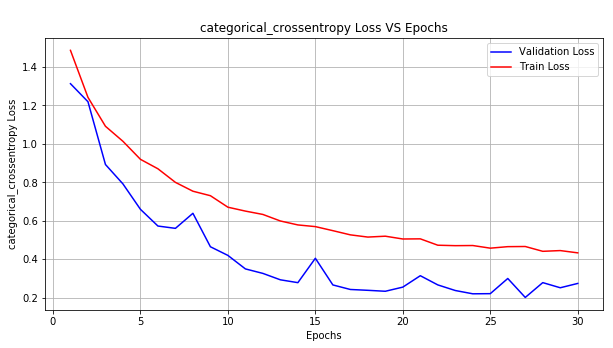

In [56]:
# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,31))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

In [57]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  6      327       140        0                   0   
STANDING                 0       45       487        0                   0   
WALKING                  0        0         0      471                  24   
WALKING_DOWNSTAIRS       0        0         0        2                 418   
WALKING_UPSTAIRS         0        4         0       18                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           18  
STANDING                           0  
WALKING                            1  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 442  


In [58]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 221us/step


In [59]:
score

[0.2743394161926277, 0.9100780454699695]

### 3. Trying 3x3 LSTM layer

In [61]:
def create_model(dropout_rate=0.0,n_hidden=32):
    # default values
    model = Sequential()
# Configuring the parameters
    model.add(CuDNNLSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
#Adding batch normnalization
    model.add(BatchNormalization())
# Adding a dropout layer
    model.add(Dropout(0.1))
#adding 2nd lstm layer
    model.add(CuDNNLSTM(16,return_sequences=True))
    model.add(Dropout(0.7))
    
#adding 3rd lstm layer  
    model.add(CuDNNLSTM(n_hidden))
    model.add(Dropout(dropout_rate))
# Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model,verbose=1)

# define the grid search parameters
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_hidden = [16,32,64,128]
epochs=[30,40,50]
batch_size = [32,64,128,256]

param_distributions  = dict(dropout_rate=dropout_rate,n_hidden=n_hidden,epochs=epochs,batch_size=batch_size)

grid = RandomizedSearchCV(estimator=model, param_distributions =param_distributions ,cv=3)
grid_result = grid.fit(X_train, Y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/50
4901/4901 [==============================] - ETA: 6:37 - loss: 1.8041 - acc: 0.109 - ETA: 1:36 - loss: 1.7314 - acc: 0.339 - ETA: 53s - loss: 1.6692 - acc: 0.446 - ETA: 36s - loss: 1.6049 - acc: 0.49 - ETA: 26s - loss: 1.5360 - acc: 0.51 - ETA: 21s - loss: 1.4774 - acc: 0.54 - ETA: 17s - loss: 1.4206 - acc: 0.57 - ETA: 14s - loss: 1.3925 - acc: 0.58 - ETA: 11s - loss: 1.3697 - acc: 0.58 - ETA: 10s - loss: 1.3340 - acc: 0.58 - ETA: 8s - loss: 1.3024 - acc: 0.5953 - ETA: 7s - loss: 1.2757 - acc: 0.597 - ETA: 6s - loss: 1.2483 - acc: 0.604 - ETA: 5s - loss: 1.2337 - acc: 0.602 - ETA: 4s - loss: 1.2109 - acc: 0.602 - ETA: 4s - loss: 1.1884 - acc: 0.607 - ETA: 3s - loss: 1.1690 - acc: 0.611 - ETA: 2s - loss: 1.1517 - acc: 0.611 - ETA: 2s - loss: 1.1352 - acc: 0.611 - ETA: 2s - loss: 1.1179 - acc: 0.613 - ETA: 1s - loss: 1.1021 - acc: 0.616 - ETA: 1s - loss: 1.0922 - acc: 0.616 - ETA: 0s - loss: 1.0804 - acc: 0.617 - ETA: 0s - loss: 1.0685 - acc: 0.616 - ETA: 0s - loss: 1.0575 - a

4901/4901 [==============================] - ETA: 1s - loss: 0.1619 - acc: 0.953 - ETA: 1s - loss: 0.1916 - acc: 0.941 - ETA: 1s - loss: 0.1619 - acc: 0.944 - ETA: 1s - loss: 0.1462 - acc: 0.948 - ETA: 1s - loss: 0.1422 - acc: 0.948 - ETA: 1s - loss: 0.1366 - acc: 0.951 - ETA: 1s - loss: 0.1548 - acc: 0.945 - ETA: 0s - loss: 0.1499 - acc: 0.944 - ETA: 0s - loss: 0.1427 - acc: 0.946 - ETA: 0s - loss: 0.1462 - acc: 0.944 - ETA: 0s - loss: 0.1482 - acc: 0.945 - ETA: 0s - loss: 0.1447 - acc: 0.946 - ETA: 0s - loss: 0.1491 - acc: 0.944 - ETA: 0s - loss: 0.1472 - acc: 0.945 - ETA: 0s - loss: 0.1449 - acc: 0.945 - ETA: 0s - loss: 0.1466 - acc: 0.945 - ETA: 0s - loss: 0.1462 - acc: 0.945 - ETA: 0s - loss: 0.1465 - acc: 0.944 - ETA: 0s - loss: 0.1451 - acc: 0.944 - ETA: 0s - loss: 0.1450 - acc: 0.944 - ETA: 0s - loss: 0.1473 - acc: 0.944 - ETA: 0s - loss: 0.1474 - acc: 0.944 - ETA: 0s - loss: 0.1453 - acc: 0.945 - ETA: 0s - loss: 0.1493 - acc: 0.944 - ETA: 0s - loss: 0.1485 - acc: 0.945 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0823 - acc: 0.984 - ETA: 1s - loss: 0.1369 - acc: 0.937 - ETA: 1s - loss: 0.1177 - acc: 0.948 - ETA: 1s - loss: 0.1108 - acc: 0.954 - ETA: 1s - loss: 0.1155 - acc: 0.953 - ETA: 1s - loss: 0.1209 - acc: 0.948 - ETA: 1s - loss: 0.1192 - acc: 0.953 - ETA: 0s - loss: 0.1159 - acc: 0.954 - ETA: 0s - loss: 0.1115 - acc: 0.955 - ETA: 0s - loss: 0.1082 - acc: 0.956 - ETA: 0s - loss: 0.1059 - acc: 0.957 - ETA: 0s - loss: 0.1054 - acc: 0.958 - ETA: 0s - loss: 0.1035 - acc: 0.959 - ETA: 0s - loss: 0.1088 - acc: 0.958 - ETA: 0s - loss: 0.1085 - acc: 0.957 - ETA: 0s - loss: 0.1148 - acc: 0.954 - ETA: 0s - loss: 0.1141 - acc: 0.954 - ETA: 0s - loss: 0.1122 - acc: 0.955 - ETA: 0s - loss: 0.1122 - acc: 0.956 - ETA: 0s - loss: 0.1112 - acc: 0.956 - ETA: 0s - loss: 0.1115 - acc: 0.955 - ETA: 0s - loss: 0.1114 - acc: 0.955 - ETA: 0s - loss: 0.1105 - acc: 0.956 - ETA: 0s - loss: 0.1134 - acc: 0.956 - ETA: 0s - loss: 0.1136 - acc: 0.956 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1316 - acc: 0.968 - ETA: 1s - loss: 0.1333 - acc: 0.960 - ETA: 1s - loss: 0.1191 - acc: 0.962 - ETA: 1s - loss: 0.1159 - acc: 0.959 - ETA: 1s - loss: 0.1267 - acc: 0.957 - ETA: 1s - loss: 0.1268 - acc: 0.957 - ETA: 1s - loss: 0.1304 - acc: 0.955 - ETA: 0s - loss: 0.1274 - acc: 0.955 - ETA: 0s - loss: 0.1237 - acc: 0.956 - ETA: 0s - loss: 0.1211 - acc: 0.955 - ETA: 0s - loss: 0.1161 - acc: 0.957 - ETA: 0s - loss: 0.1122 - acc: 0.958 - ETA: 0s - loss: 0.1084 - acc: 0.960 - ETA: 0s - loss: 0.1120 - acc: 0.959 - ETA: 0s - loss: 0.1107 - acc: 0.960 - ETA: 0s - loss: 0.1081 - acc: 0.960 - ETA: 0s - loss: 0.1068 - acc: 0.961 - ETA: 0s - loss: 0.1082 - acc: 0.960 - ETA: 0s - loss: 0.1107 - acc: 0.959 - ETA: 0s - loss: 0.1116 - acc: 0.959 - ETA: 0s - loss: 0.1103 - acc: 0.960 - ETA: 0s - loss: 0.1090 - acc: 0.960 - ETA: 0s - loss: 0.1076 - acc: 0.960 - ETA: 0s - loss: 0.1054 - acc: 0.961 - ETA: 0s - loss: 0.1039 - acc: 0.961 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1350 - acc: 0.921 - ETA: 1s - loss: 0.1518 - acc: 0.925 - ETA: 1s - loss: 0.1545 - acc: 0.942 - ETA: 1s - loss: 0.1518 - acc: 0.940 - ETA: 1s - loss: 0.1574 - acc: 0.933 - ETA: 1s - loss: 0.1535 - acc: 0.935 - ETA: 1s - loss: 0.1429 - acc: 0.941 - ETA: 0s - loss: 0.1378 - acc: 0.944 - ETA: 0s - loss: 0.1380 - acc: 0.945 - ETA: 0s - loss: 0.1372 - acc: 0.943 - ETA: 0s - loss: 0.1355 - acc: 0.944 - ETA: 0s - loss: 0.1369 - acc: 0.943 - ETA: 0s - loss: 0.1349 - acc: 0.945 - ETA: 0s - loss: 0.1369 - acc: 0.944 - ETA: 0s - loss: 0.1359 - acc: 0.945 - ETA: 0s - loss: 0.1366 - acc: 0.946 - ETA: 0s - loss: 0.1373 - acc: 0.946 - ETA: 0s - loss: 0.1438 - acc: 0.945 - ETA: 0s - loss: 0.1444 - acc: 0.944 - ETA: 0s - loss: 0.1482 - acc: 0.942 - ETA: 0s - loss: 0.1483 - acc: 0.942 - ETA: 0s - loss: 0.1463 - acc: 0.943 - ETA: 0s - loss: 0.1435 - acc: 0.944 - ETA: 0s - loss: 0.1458 - acc: 0.944 - ETA: 0s - loss: 0.1463 - acc: 0.944 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0968 - acc: 0.968 - ETA: 1s - loss: 0.0847 - acc: 0.976 - ETA: 1s - loss: 0.0969 - acc: 0.959 - ETA: 1s - loss: 0.1014 - acc: 0.959 - ETA: 1s - loss: 0.1020 - acc: 0.955 - ETA: 1s - loss: 0.1055 - acc: 0.956 - ETA: 1s - loss: 0.1043 - acc: 0.957 - ETA: 0s - loss: 0.1135 - acc: 0.955 - ETA: 0s - loss: 0.1146 - acc: 0.955 - ETA: 0s - loss: 0.1086 - acc: 0.957 - ETA: 0s - loss: 0.1114 - acc: 0.955 - ETA: 0s - loss: 0.1126 - acc: 0.955 - ETA: 0s - loss: 0.1106 - acc: 0.955 - ETA: 0s - loss: 0.1115 - acc: 0.955 - ETA: 0s - loss: 0.1085 - acc: 0.957 - ETA: 0s - loss: 0.1107 - acc: 0.956 - ETA: 0s - loss: 0.1098 - acc: 0.957 - ETA: 0s - loss: 0.1094 - acc: 0.957 - ETA: 0s - loss: 0.1138 - acc: 0.956 - ETA: 0s - loss: 0.1136 - acc: 0.956 - ETA: 0s - loss: 0.1154 - acc: 0.955 - ETA: 0s - loss: 0.1140 - acc: 0.955 - ETA: 0s - loss: 0.1167 - acc: 0.955 - ETA: 0s - loss: 0.1162 - acc: 0.955 - ETA: 0s - loss: 0.1162 - acc: 0.955 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0972 - acc: 0.968 - ETA: 1s - loss: 0.0993 - acc: 0.968 - ETA: 1s - loss: 0.1056 - acc: 0.962 - ETA: 1s - loss: 0.0949 - acc: 0.967 - ETA: 1s - loss: 0.0982 - acc: 0.965 - ETA: 1s - loss: 0.1012 - acc: 0.964 - ETA: 1s - loss: 0.0968 - acc: 0.965 - ETA: 0s - loss: 0.0938 - acc: 0.964 - ETA: 0s - loss: 0.0901 - acc: 0.966 - ETA: 0s - loss: 0.0931 - acc: 0.966 - ETA: 0s - loss: 0.0961 - acc: 0.964 - ETA: 0s - loss: 0.0952 - acc: 0.965 - ETA: 0s - loss: 0.0938 - acc: 0.964 - ETA: 0s - loss: 0.0948 - acc: 0.963 - ETA: 0s - loss: 0.0986 - acc: 0.963 - ETA: 0s - loss: 0.0988 - acc: 0.962 - ETA: 0s - loss: 0.0984 - acc: 0.962 - ETA: 0s - loss: 0.1001 - acc: 0.962 - ETA: 0s - loss: 0.1048 - acc: 0.961 - ETA: 0s - loss: 0.1053 - acc: 0.961 - ETA: 0s - loss: 0.1050 - acc: 0.961 - ETA: 0s - loss: 0.1030 - acc: 0.961 - ETA: 0s - loss: 0.1033 - acc: 0.962 - ETA: 0s - loss: 0.1036 - acc: 0.961 - ETA: 0s - loss: 0.1031 - acc: 0.961 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1730 - acc: 0.906 - ETA: 1s - loss: 0.1498 - acc: 0.921 - ETA: 1s - loss: 0.1249 - acc: 0.937 - ETA: 1s - loss: 0.1297 - acc: 0.946 - ETA: 1s - loss: 0.1186 - acc: 0.950 - ETA: 1s - loss: 0.1224 - acc: 0.952 - ETA: 1s - loss: 0.1273 - acc: 0.949 - ETA: 1s - loss: 0.1187 - acc: 0.952 - ETA: 0s - loss: 0.1107 - acc: 0.954 - ETA: 0s - loss: 0.1050 - acc: 0.957 - ETA: 0s - loss: 0.1035 - acc: 0.957 - ETA: 0s - loss: 0.1006 - acc: 0.959 - ETA: 0s - loss: 0.0992 - acc: 0.960 - ETA: 0s - loss: 0.0966 - acc: 0.960 - ETA: 0s - loss: 0.0960 - acc: 0.959 - ETA: 0s - loss: 0.0928 - acc: 0.962 - ETA: 0s - loss: 0.0944 - acc: 0.962 - ETA: 0s - loss: 0.0971 - acc: 0.961 - ETA: 0s - loss: 0.0947 - acc: 0.962 - ETA: 0s - loss: 0.0956 - acc: 0.961 - ETA: 0s - loss: 0.0931 - acc: 0.962 - ETA: 0s - loss: 0.0930 - acc: 0.962 - ETA: 0s - loss: 0.0918 - acc: 0.962 - ETA: 0s - loss: 0.0920 - acc: 0.962 - ETA: 0s - loss: 0.0936 - acc: 0.961 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1326 - acc: 0.921 - ETA: 1s - loss: 0.1223 - acc: 0.953 - ETA: 1s - loss: 0.1405 - acc: 0.946 - ETA: 1s - loss: 0.1396 - acc: 0.937 - ETA: 1s - loss: 0.1345 - acc: 0.939 - ETA: 1s - loss: 0.1269 - acc: 0.946 - ETA: 1s - loss: 0.1193 - acc: 0.947 - ETA: 0s - loss: 0.1223 - acc: 0.947 - ETA: 0s - loss: 0.1207 - acc: 0.947 - ETA: 0s - loss: 0.1185 - acc: 0.948 - ETA: 0s - loss: 0.1177 - acc: 0.950 - ETA: 0s - loss: 0.1231 - acc: 0.945 - ETA: 0s - loss: 0.1254 - acc: 0.943 - ETA: 0s - loss: 0.1257 - acc: 0.944 - ETA: 0s - loss: 0.1218 - acc: 0.946 - ETA: 0s - loss: 0.1246 - acc: 0.946 - ETA: 0s - loss: 0.1252 - acc: 0.945 - ETA: 0s - loss: 0.1225 - acc: 0.946 - ETA: 0s - loss: 0.1241 - acc: 0.945 - ETA: 0s - loss: 0.1217 - acc: 0.946 - ETA: 0s - loss: 0.1219 - acc: 0.947 - ETA: 0s - loss: 0.1212 - acc: 0.948 - ETA: 0s - loss: 0.1212 - acc: 0.947 - ETA: 0s - loss: 0.1233 - acc: 0.946 - ETA: 0s - loss: 0.1233 - acc: 0.946 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0669 - acc: 0.968 - ETA: 1s - loss: 0.0736 - acc: 0.960 - ETA: 1s - loss: 0.0805 - acc: 0.966 - ETA: 1s - loss: 0.0854 - acc: 0.960 - ETA: 1s - loss: 0.1077 - acc: 0.945 - ETA: 1s - loss: 0.1112 - acc: 0.945 - ETA: 1s - loss: 0.1097 - acc: 0.948 - ETA: 1s - loss: 0.1094 - acc: 0.950 - ETA: 0s - loss: 0.1081 - acc: 0.951 - ETA: 0s - loss: 0.1070 - acc: 0.952 - ETA: 0s - loss: 0.1042 - acc: 0.954 - ETA: 0s - loss: 0.1037 - acc: 0.955 - ETA: 0s - loss: 0.1047 - acc: 0.954 - ETA: 0s - loss: 0.1041 - acc: 0.955 - ETA: 0s - loss: 0.1034 - acc: 0.956 - ETA: 0s - loss: 0.1018 - acc: 0.956 - ETA: 0s - loss: 0.1000 - acc: 0.957 - ETA: 0s - loss: 0.1010 - acc: 0.956 - ETA: 0s - loss: 0.0996 - acc: 0.956 - ETA: 0s - loss: 0.0999 - acc: 0.956 - ETA: 0s - loss: 0.0990 - acc: 0.957 - ETA: 0s - loss: 0.0984 - acc: 0.957 - ETA: 0s - loss: 0.0992 - acc: 0.956 - ETA: 0s - loss: 0.0976 - acc: 0.957 - ETA: 0s - loss: 0.0991 - acc: 0.957 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.0766 - acc: 0.984 - ETA: 1s - loss: 0.0950 - acc: 0.960 - ETA: 1s - loss: 0.0765 - acc: 0.968 - ETA: 1s - loss: 0.0717 - acc: 0.971 - ETA: 1s - loss: 0.0725 - acc: 0.971 - ETA: 1s - loss: 0.0789 - acc: 0.965 - ETA: 1s - loss: 0.0761 - acc: 0.963 - ETA: 0s - loss: 0.0776 - acc: 0.962 - ETA: 0s - loss: 0.0760 - acc: 0.964 - ETA: 0s - loss: 0.0783 - acc: 0.963 - ETA: 0s - loss: 0.0781 - acc: 0.963 - ETA: 0s - loss: 0.0792 - acc: 0.961 - ETA: 0s - loss: 0.0796 - acc: 0.960 - ETA: 0s - loss: 0.0803 - acc: 0.959 - ETA: 0s - loss: 0.0815 - acc: 0.958 - ETA: 0s - loss: 0.0804 - acc: 0.959 - ETA: 0s - loss: 0.0806 - acc: 0.960 - ETA: 0s - loss: 0.0832 - acc: 0.960 - ETA: 0s - loss: 0.0841 - acc: 0.959 - ETA: 0s - loss: 0.0860 - acc: 0.957 - ETA: 0s - loss: 0.0857 - acc: 0.958 - ETA: 0s - loss: 0.0870 - acc: 0.956 - ETA: 0s - loss: 0.0885 - acc: 0.955 - ETA: 0s - loss: 0.0875 - acc: 0.956 - ETA: 0s - loss: 0.0864 - acc: 0.957 - ETA: 

4901/4901 [==============================] - ETA: 0s - loss: 0.8788 - acc: 0.628 - ETA: 0s - loss: 0.8745 - acc: 0.656 - ETA: 0s - loss: 0.8742 - acc: 0.643 - ETA: 0s - loss: 0.8681 - acc: 0.645 - ETA: 0s - loss: 0.8678 - acc: 0.646 - ETA: 0s - loss: 0.8732 - acc: 0.638 - ETA: 0s - loss: 0.8686 - acc: 0.638 - ETA: 0s - loss: 0.8677 - acc: 0.633 - ETA: 0s - loss: 0.8660 - acc: 0.635 - 1s 102us/step - loss: 0.8627 - acc: 0.6376
Epoch 12/50
4901/4901 [==============================] - ETA: 0s - loss: 0.8722 - acc: 0.656 - ETA: 0s - loss: 0.9122 - acc: 0.630 - ETA: 0s - loss: 0.8936 - acc: 0.635 - ETA: 0s - loss: 0.8810 - acc: 0.636 - ETA: 0s - loss: 0.8658 - acc: 0.649 - ETA: 0s - loss: 0.8600 - acc: 0.659 - ETA: 0s - loss: 0.8580 - acc: 0.658 - ETA: 0s - loss: 0.8562 - acc: 0.658 - 0s 101us/step - loss: 0.8552 - acc: 0.6578
Epoch 13/50
4901/4901 [==============================] - ETA: 0s - loss: 1.4041 - acc: 0.550 - ETA: 0s - loss: 1.0266 - acc: 0.630 - ETA: 0s - loss: 0.9676 - acc: 0.6

Epoch 30/50
4901/4901 [==============================] - ETA: 0s - loss: 0.5850 - acc: 0.796 - ETA: 0s - loss: 0.6177 - acc: 0.775 - ETA: 0s - loss: 0.6033 - acc: 0.773 - ETA: 0s - loss: 0.6085 - acc: 0.774 - ETA: 0s - loss: 0.6098 - acc: 0.778 - ETA: 0s - loss: 0.6127 - acc: 0.777 - ETA: 0s - loss: 0.6083 - acc: 0.778 - ETA: 0s - loss: 0.6100 - acc: 0.780 - 0s 101us/step - loss: 0.6167 - acc: 0.7792
Epoch 31/50
4901/4901 [==============================] - ETA: 0s - loss: 0.5637 - acc: 0.789 - ETA: 0s - loss: 0.5717 - acc: 0.783 - ETA: 0s - loss: 0.5913 - acc: 0.778 - ETA: 0s - loss: 0.5864 - acc: 0.781 - ETA: 0s - loss: 0.5910 - acc: 0.783 - ETA: 0s - loss: 0.5980 - acc: 0.781 - ETA: 0s - loss: 0.6022 - acc: 0.782 - ETA: 0s - loss: 0.6007 - acc: 0.780 - ETA: 0s - loss: 0.5988 - acc: 0.783 - 1s 103us/step - loss: 0.6004 - acc: 0.7829
Epoch 32/50
4901/4901 [==============================] - ETA: 0s - loss: 0.5616 - acc: 0.773 - ETA: 0s - loss: 0.5864 - acc: 0.772 - ETA: 0s - loss: 0.593

4901/4901 [==============================] - ETA: 0s - loss: 0.7110 - acc: 0.769 - ETA: 0s - loss: 0.7336 - acc: 0.778 - ETA: 0s - loss: 0.7085 - acc: 0.783 - ETA: 0s - loss: 0.7199 - acc: 0.776 - ETA: 0s - loss: 0.7098 - acc: 0.790 - ETA: 0s - loss: 0.6955 - acc: 0.797 - ETA: 0s - loss: 0.6933 - acc: 0.799 - ETA: 0s - loss: 0.6869 - acc: 0.804 - ETA: 0s - loss: 0.6839 - acc: 0.805 - 1s 102us/step - loss: 0.6795 - acc: 0.8060
Epoch 17/50
4901/4901 [==============================] - ETA: 0s - loss: 0.7036 - acc: 0.816 - ETA: 0s - loss: 0.6626 - acc: 0.820 - ETA: 0s - loss: 0.6602 - acc: 0.815 - ETA: 0s - loss: 0.6895 - acc: 0.808 - ETA: 0s - loss: 0.6887 - acc: 0.808 - ETA: 0s - loss: 0.6845 - acc: 0.809 - ETA: 0s - loss: 0.6794 - acc: 0.808 - ETA: 0s - loss: 0.6761 - acc: 0.808 - ETA: 0s - loss: 0.6719 - acc: 0.809 - 1s 102us/step - loss: 0.6736 - acc: 0.8090
Epoch 18/50
4901/4901 [==============================] - ETA: 0s - loss: 0.7026 - acc: 0.769 - ETA: 0s - loss: 0.6515 - acc: 0.8

4902/4902 [==============================] - ETA: 0s - loss: 1.4232 - acc: 0.441 - ETA: 0s - loss: 1.3749 - acc: 0.488 - ETA: 0s - loss: 1.3734 - acc: 0.481 - ETA: 0s - loss: 1.3556 - acc: 0.497 - ETA: 0s - loss: 1.3487 - acc: 0.496 - ETA: 0s - loss: 1.3316 - acc: 0.509 - ETA: 0s - loss: 1.3117 - acc: 0.516 - ETA: 0s - loss: 1.3043 - acc: 0.520 - 0s 102us/step - loss: 1.3032 - acc: 0.5188
Epoch 3/50
4902/4902 [==============================] - ETA: 0s - loss: 1.2026 - acc: 0.527 - ETA: 0s - loss: 1.1966 - acc: 0.557 - ETA: 0s - loss: 1.1961 - acc: 0.557 - ETA: 0s - loss: 1.1968 - acc: 0.557 - ETA: 0s - loss: 1.2096 - acc: 0.554 - ETA: 0s - loss: 1.2085 - acc: 0.554 - ETA: 0s - loss: 1.2015 - acc: 0.555 - ETA: 0s - loss: 1.1925 - acc: 0.564 - ETA: 0s - loss: 1.1855 - acc: 0.567 - 1s 103us/step - loss: 1.1850 - acc: 0.5667
Epoch 4/50
4902/4902 [==============================] - ETA: 0s - loss: 1.2037 - acc: 0.476 - ETA: 0s - loss: 1.2160 - acc: 0.520 - ETA: 0s - loss: 1.1946 - acc: 0.527

4902/4902 [==============================] - ETA: 0s - loss: 0.5743 - acc: 0.746 - ETA: 0s - loss: 0.6081 - acc: 0.734 - ETA: 0s - loss: 0.5933 - acc: 0.751 - ETA: 0s - loss: 0.5909 - acc: 0.756 - ETA: 0s - loss: 0.5900 - acc: 0.756 - ETA: 0s - loss: 0.6012 - acc: 0.755 - ETA: 0s - loss: 0.5948 - acc: 0.759 - ETA: 0s - loss: 0.5901 - acc: 0.759 - ETA: 0s - loss: 0.5871 - acc: 0.759 - ETA: 0s - loss: 0.5872 - acc: 0.760 - 1s 103us/step - loss: 0.5877 - acc: 0.7603
Epoch 39/50
4902/4902 [==============================] - ETA: 0s - loss: 0.6052 - acc: 0.753 - ETA: 0s - loss: 0.5842 - acc: 0.745 - ETA: 0s - loss: 0.6087 - acc: 0.743 - ETA: 0s - loss: 0.6042 - acc: 0.746 - ETA: 0s - loss: 0.5914 - acc: 0.752 - ETA: 0s - loss: 0.5839 - acc: 0.754 - ETA: 0s - loss: 0.5943 - acc: 0.750 - ETA: 0s - loss: 0.5933 - acc: 0.752 - ETA: 0s - loss: 0.5966 - acc: 0.751 - 0s 102us/step - loss: 0.5973 - acc: 0.7505
Epoch 40/50
4902/4902 [==============================] - ETA: 0s - loss: 0.6399 - acc: 0.7

4901/4901 [==============================] - ETA: 0s - loss: 0.4353 - acc: 0.882 - ETA: 0s - loss: 0.3284 - acc: 0.912 - ETA: 0s - loss: 0.3190 - acc: 0.913 - ETA: 0s - loss: 0.3056 - acc: 0.917 - ETA: 0s - loss: 0.2923 - acc: 0.923 - ETA: 0s - loss: 0.2883 - acc: 0.925 - ETA: 0s - loss: 0.2863 - acc: 0.928 - ETA: 0s - loss: 0.2882 - acc: 0.926 - ETA: 0s - loss: 0.2844 - acc: 0.927 - 1s 104us/step - loss: 0.2846 - acc: 0.9267
Epoch 24/40
4901/4901 [==============================] - ETA: 0s - loss: 0.2689 - acc: 0.925 - ETA: 0s - loss: 0.2723 - acc: 0.932 - ETA: 0s - loss: 0.2818 - acc: 0.927 - ETA: 0s - loss: 0.2783 - acc: 0.926 - ETA: 0s - loss: 0.2793 - acc: 0.926 - ETA: 0s - loss: 0.2793 - acc: 0.924 - ETA: 0s - loss: 0.2775 - acc: 0.926 - ETA: 0s - loss: 0.2715 - acc: 0.928 - ETA: 0s - loss: 0.3020 - acc: 0.923 - ETA: 0s - loss: 0.2968 - acc: 0.923 - 1s 107us/step - loss: 0.2972 - acc: 0.9235
Epoch 25/40
4901/4901 [==============================] - ETA: 0s - loss: 0.3494 - acc: 0.9

Epoch 1/40
4901/4901 [==============================] - ETA: 1:54 - loss: 1.8070 - acc: 0.144 - ETA: 34s - loss: 1.7686 - acc: 0.222 - ETA: 18s - loss: 1.7314 - acc: 0.28 - ETA: 11s - loss: 1.6990 - acc: 0.32 - ETA: 7s - loss: 1.6623 - acc: 0.3650 - ETA: 4s - loss: 1.6289 - acc: 0.384 - ETA: 3s - loss: 1.5949 - acc: 0.404 - ETA: 1s - loss: 1.5621 - acc: 0.421 - ETA: 0s - loss: 1.5285 - acc: 0.432 - ETA: 0s - loss: 1.4962 - acc: 0.448 - 7s 1ms/step - loss: 1.4945 - acc: 0.4491
Epoch 2/40
4901/4901 [==============================] - ETA: 0s - loss: 1.2295 - acc: 0.523 - ETA: 0s - loss: 1.1897 - acc: 0.520 - ETA: 0s - loss: 1.1844 - acc: 0.522 - ETA: 0s - loss: 1.1796 - acc: 0.514 - ETA: 0s - loss: 1.1654 - acc: 0.524 - ETA: 0s - loss: 1.1546 - acc: 0.524 - ETA: 0s - loss: 1.1476 - acc: 0.522 - ETA: 0s - loss: 1.1369 - acc: 0.530 - ETA: 0s - loss: 1.1293 - acc: 0.531 - 1s 104us/step - loss: 1.1259 - acc: 0.5305
Epoch 3/40
4901/4901 [==============================] - ETA: 0s - loss: 1.0598

4901/4901 [==============================] - ETA: 0s - loss: 0.1764 - acc: 0.953 - ETA: 0s - loss: 0.1947 - acc: 0.950 - ETA: 0s - loss: 0.1979 - acc: 0.944 - ETA: 0s - loss: 0.1961 - acc: 0.947 - ETA: 0s - loss: 0.1971 - acc: 0.943 - ETA: 0s - loss: 0.1975 - acc: 0.943 - ETA: 0s - loss: 0.1952 - acc: 0.944 - ETA: 0s - loss: 0.1982 - acc: 0.942 - ETA: 0s - loss: 0.1982 - acc: 0.942 - 1s 103us/step - loss: 0.1997 - acc: 0.9425
Epoch 38/40
4901/4901 [==============================] - ETA: 0s - loss: 0.2452 - acc: 0.902 - ETA: 0s - loss: 0.2126 - acc: 0.924 - ETA: 0s - loss: 0.2213 - acc: 0.921 - ETA: 0s - loss: 0.2229 - acc: 0.925 - ETA: 0s - loss: 0.2200 - acc: 0.928 - ETA: 0s - loss: 0.2143 - acc: 0.930 - ETA: 0s - loss: 0.2115 - acc: 0.931 - ETA: 0s - loss: 0.2136 - acc: 0.930 - 1s 103us/step - loss: 0.2126 - acc: 0.9316
Epoch 39/40
4901/4901 [==============================] - ETA: 0s - loss: 0.1813 - acc: 0.949 - ETA: 0s - loss: 0.1919 - acc: 0.953 - ETA: 0s - loss: 0.1899 - acc: 0.9

Epoch 15/40
4902/4902 [==============================] - ETA: 0s - loss: 0.5306 - acc: 0.828 - ETA: 0s - loss: 0.5159 - acc: 0.800 - ETA: 0s - loss: 0.4979 - acc: 0.806 - ETA: 0s - loss: 0.4825 - acc: 0.812 - ETA: 0s - loss: 0.4871 - acc: 0.808 - ETA: 0s - loss: 0.4829 - acc: 0.811 - ETA: 0s - loss: 0.4798 - acc: 0.817 - ETA: 0s - loss: 0.4735 - acc: 0.820 - ETA: 0s - loss: 0.4728 - acc: 0.821 - ETA: 0s - loss: 0.4751 - acc: 0.823 - 1s 103us/step - loss: 0.4746 - acc: 0.8233
Epoch 16/40
4902/4902 [==============================] - ETA: 0s - loss: 0.5391 - acc: 0.820 - ETA: 0s - loss: 0.4900 - acc: 0.814 - ETA: 0s - loss: 0.5050 - acc: 0.807 - ETA: 0s - loss: 0.4833 - acc: 0.821 - ETA: 0s - loss: 0.4691 - acc: 0.824 - ETA: 0s - loss: 0.4625 - acc: 0.829 - ETA: 0s - loss: 0.4768 - acc: 0.829 - ETA: 0s - loss: 0.4826 - acc: 0.825 - ETA: 0s - loss: 0.4753 - acc: 0.828 - 1s 102us/step - loss: 0.4756 - acc: 0.8278
Epoch 17/40
4902/4902 [==============================] - ETA: 0s - loss: 0.440

4901/4901 [==============================] - ETA: 2s - loss: 0.2580 - acc: 0.906 - ETA: 2s - loss: 0.4552 - acc: 0.781 - ETA: 2s - loss: 0.4419 - acc: 0.790 - ETA: 2s - loss: 0.4071 - acc: 0.831 - ETA: 2s - loss: 0.3950 - acc: 0.838 - ETA: 2s - loss: 0.3883 - acc: 0.841 - ETA: 2s - loss: 0.3823 - acc: 0.847 - ETA: 2s - loss: 0.3709 - acc: 0.853 - ETA: 2s - loss: 0.3663 - acc: 0.858 - ETA: 2s - loss: 0.3542 - acc: 0.863 - ETA: 2s - loss: 0.3414 - acc: 0.872 - ETA: 2s - loss: 0.3487 - acc: 0.870 - ETA: 2s - loss: 0.3789 - acc: 0.862 - ETA: 2s - loss: 0.3663 - acc: 0.869 - ETA: 2s - loss: 0.3634 - acc: 0.869 - ETA: 1s - loss: 0.3505 - acc: 0.876 - ETA: 1s - loss: 0.3512 - acc: 0.875 - ETA: 1s - loss: 0.3565 - acc: 0.875 - ETA: 1s - loss: 0.3515 - acc: 0.876 - ETA: 1s - loss: 0.3443 - acc: 0.878 - ETA: 1s - loss: 0.3402 - acc: 0.878 - ETA: 1s - loss: 0.3372 - acc: 0.878 - ETA: 1s - loss: 0.3434 - acc: 0.875 - ETA: 1s - loss: 0.3471 - acc: 0.877 - ETA: 1s - loss: 0.3489 - acc: 0.877 - ETA: 

4901/4901 [==============================] - ETA: 3s - loss: 0.1115 - acc: 0.937 - ETA: 2s - loss: 0.1351 - acc: 0.953 - ETA: 2s - loss: 0.1256 - acc: 0.959 - ETA: 2s - loss: 0.1269 - acc: 0.965 - ETA: 2s - loss: 0.1142 - acc: 0.968 - ETA: 2s - loss: 0.1069 - acc: 0.970 - ETA: 2s - loss: 0.1137 - acc: 0.963 - ETA: 2s - loss: 0.1075 - acc: 0.967 - ETA: 2s - loss: 0.1138 - acc: 0.962 - ETA: 2s - loss: 0.1191 - acc: 0.960 - ETA: 2s - loss: 0.1235 - acc: 0.959 - ETA: 2s - loss: 0.1550 - acc: 0.954 - ETA: 2s - loss: 0.1533 - acc: 0.951 - ETA: 2s - loss: 0.1502 - acc: 0.952 - ETA: 2s - loss: 0.1549 - acc: 0.949 - ETA: 1s - loss: 0.1492 - acc: 0.951 - ETA: 1s - loss: 0.1470 - acc: 0.952 - ETA: 1s - loss: 0.1455 - acc: 0.952 - ETA: 1s - loss: 0.1458 - acc: 0.951 - ETA: 1s - loss: 0.1434 - acc: 0.951 - ETA: 1s - loss: 0.1418 - acc: 0.951 - ETA: 1s - loss: 0.1440 - acc: 0.951 - ETA: 1s - loss: 0.1431 - acc: 0.951 - ETA: 1s - loss: 0.1412 - acc: 0.951 - ETA: 1s - loss: 0.1425 - acc: 0.949 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.0989 - acc: 0.937 - ETA: 2s - loss: 0.1018 - acc: 0.960 - ETA: 2s - loss: 0.0916 - acc: 0.955 - ETA: 2s - loss: 0.0975 - acc: 0.956 - ETA: 2s - loss: 0.0995 - acc: 0.956 - ETA: 2s - loss: 0.1043 - acc: 0.959 - ETA: 2s - loss: 0.1213 - acc: 0.953 - ETA: 2s - loss: 0.1221 - acc: 0.953 - ETA: 2s - loss: 0.1215 - acc: 0.953 - ETA: 2s - loss: 0.1204 - acc: 0.954 - ETA: 2s - loss: 0.1322 - acc: 0.951 - ETA: 2s - loss: 0.1355 - acc: 0.951 - ETA: 2s - loss: 0.1354 - acc: 0.951 - ETA: 2s - loss: 0.1374 - acc: 0.947 - ETA: 1s - loss: 0.1380 - acc: 0.946 - ETA: 1s - loss: 0.1340 - acc: 0.947 - ETA: 1s - loss: 0.1316 - acc: 0.947 - ETA: 1s - loss: 0.1319 - acc: 0.948 - ETA: 1s - loss: 0.1288 - acc: 0.948 - ETA: 1s - loss: 0.1326 - acc: 0.948 - ETA: 1s - loss: 0.1307 - acc: 0.948 - ETA: 1s - loss: 0.1299 - acc: 0.948 - ETA: 1s - loss: 0.1311 - acc: 0.946 - ETA: 1s - loss: 0.1294 - acc: 0.948 - ETA: 1s - loss: 0.1290 - acc: 0.949 - ETA: 

4901/4901 [==============================] - ETA: 3s - loss: 0.2242 - acc: 0.906 - ETA: 2s - loss: 0.1242 - acc: 0.960 - ETA: 2s - loss: 0.1136 - acc: 0.964 - ETA: 2s - loss: 0.0993 - acc: 0.965 - ETA: 2s - loss: 0.0976 - acc: 0.963 - ETA: 2s - loss: 0.1000 - acc: 0.964 - ETA: 2s - loss: 0.1091 - acc: 0.960 - ETA: 2s - loss: 0.1150 - acc: 0.957 - ETA: 2s - loss: 0.1184 - acc: 0.953 - ETA: 2s - loss: 0.1133 - acc: 0.957 - ETA: 2s - loss: 0.1151 - acc: 0.956 - ETA: 2s - loss: 0.1142 - acc: 0.955 - ETA: 2s - loss: 0.1209 - acc: 0.951 - ETA: 2s - loss: 0.1189 - acc: 0.950 - ETA: 1s - loss: 0.1202 - acc: 0.949 - ETA: 1s - loss: 0.1155 - acc: 0.951 - ETA: 1s - loss: 0.1201 - acc: 0.949 - ETA: 1s - loss: 0.1220 - acc: 0.948 - ETA: 1s - loss: 0.1210 - acc: 0.949 - ETA: 1s - loss: 0.1190 - acc: 0.949 - ETA: 1s - loss: 0.1210 - acc: 0.947 - ETA: 1s - loss: 0.1261 - acc: 0.946 - ETA: 1s - loss: 0.1251 - acc: 0.947 - ETA: 1s - loss: 0.1261 - acc: 0.947 - ETA: 1s - loss: 0.1276 - acc: 0.945 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.2440 - acc: 0.843 - ETA: 2s - loss: 0.1898 - acc: 0.906 - ETA: 2s - loss: 0.1678 - acc: 0.919 - ETA: 2s - loss: 0.1375 - acc: 0.937 - ETA: 2s - loss: 0.1274 - acc: 0.939 - ETA: 2s - loss: 0.1122 - acc: 0.947 - ETA: 2s - loss: 0.1027 - acc: 0.950 - ETA: 2s - loss: 0.1023 - acc: 0.953 - ETA: 2s - loss: 0.0969 - acc: 0.955 - ETA: 2s - loss: 0.0898 - acc: 0.958 - ETA: 2s - loss: 0.0932 - acc: 0.957 - ETA: 2s - loss: 0.0952 - acc: 0.957 - ETA: 2s - loss: 0.0960 - acc: 0.957 - ETA: 2s - loss: 0.0978 - acc: 0.956 - ETA: 1s - loss: 0.1015 - acc: 0.954 - ETA: 1s - loss: 0.1048 - acc: 0.953 - ETA: 1s - loss: 0.1069 - acc: 0.953 - ETA: 1s - loss: 0.1078 - acc: 0.952 - ETA: 1s - loss: 0.1061 - acc: 0.952 - ETA: 1s - loss: 0.1069 - acc: 0.953 - ETA: 1s - loss: 0.1075 - acc: 0.953 - ETA: 1s - loss: 0.1078 - acc: 0.954 - ETA: 1s - loss: 0.1117 - acc: 0.952 - ETA: 1s - loss: 0.1152 - acc: 0.950 - ETA: 1s - loss: 0.1150 - acc: 0.950 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.4397 - acc: 0.812 - ETA: 2s - loss: 0.6142 - acc: 0.687 - ETA: 2s - loss: 0.6389 - acc: 0.687 - ETA: 2s - loss: 0.6237 - acc: 0.696 - ETA: 2s - loss: 0.6093 - acc: 0.716 - ETA: 2s - loss: 0.6119 - acc: 0.724 - ETA: 2s - loss: 0.6111 - acc: 0.722 - ETA: 2s - loss: 0.5850 - acc: 0.738 - ETA: 2s - loss: 0.5727 - acc: 0.740 - ETA: 2s - loss: 0.5693 - acc: 0.743 - ETA: 2s - loss: 0.5712 - acc: 0.741 - ETA: 2s - loss: 0.5624 - acc: 0.747 - ETA: 2s - loss: 0.5568 - acc: 0.750 - ETA: 2s - loss: 0.5551 - acc: 0.747 - ETA: 1s - loss: 0.5674 - acc: 0.741 - ETA: 1s - loss: 0.5702 - acc: 0.740 - ETA: 1s - loss: 0.5724 - acc: 0.740 - ETA: 1s - loss: 0.5728 - acc: 0.741 - ETA: 1s - loss: 0.5683 - acc: 0.740 - ETA: 1s - loss: 0.5584 - acc: 0.747 - ETA: 1s - loss: 0.5519 - acc: 0.751 - ETA: 1s - loss: 0.5544 - acc: 0.751 - ETA: 1s - loss: 0.5535 - acc: 0.751 - ETA: 1s - loss: 0.5495 - acc: 0.752 - ETA: 1s - loss: 0.5455 - acc: 0.752 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.0795 - acc: 0.968 - ETA: 2s - loss: 0.0792 - acc: 0.984 - ETA: 2s - loss: 0.0877 - acc: 0.968 - ETA: 2s - loss: 0.1164 - acc: 0.962 - ETA: 2s - loss: 0.1515 - acc: 0.951 - ETA: 2s - loss: 0.1507 - acc: 0.951 - ETA: 2s - loss: 0.1507 - acc: 0.949 - ETA: 2s - loss: 0.1661 - acc: 0.943 - ETA: 2s - loss: 0.1821 - acc: 0.940 - ETA: 2s - loss: 0.1773 - acc: 0.939 - ETA: 2s - loss: 0.1753 - acc: 0.938 - ETA: 2s - loss: 0.1741 - acc: 0.940 - ETA: 2s - loss: 0.1704 - acc: 0.941 - ETA: 2s - loss: 0.1673 - acc: 0.942 - ETA: 2s - loss: 0.2025 - acc: 0.936 - ETA: 1s - loss: 0.1965 - acc: 0.938 - ETA: 1s - loss: 0.1940 - acc: 0.936 - ETA: 1s - loss: 0.1869 - acc: 0.938 - ETA: 1s - loss: 0.1820 - acc: 0.940 - ETA: 1s - loss: 0.1773 - acc: 0.941 - ETA: 1s - loss: 0.1801 - acc: 0.940 - ETA: 1s - loss: 0.1782 - acc: 0.940 - ETA: 1s - loss: 0.1735 - acc: 0.942 - ETA: 1s - loss: 0.1703 - acc: 0.943 - ETA: 1s - loss: 0.1666 - acc: 0.945 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.1358 - acc: 0.906 - ETA: 2s - loss: 0.1164 - acc: 0.953 - ETA: 2s - loss: 0.1556 - acc: 0.937 - ETA: 2s - loss: 0.1534 - acc: 0.931 - ETA: 2s - loss: 0.1376 - acc: 0.932 - ETA: 2s - loss: 0.1252 - acc: 0.937 - ETA: 2s - loss: 0.1183 - acc: 0.937 - ETA: 2s - loss: 0.1101 - acc: 0.940 - ETA: 2s - loss: 0.1115 - acc: 0.940 - ETA: 2s - loss: 0.1045 - acc: 0.944 - ETA: 2s - loss: 0.1045 - acc: 0.945 - ETA: 2s - loss: 0.1037 - acc: 0.948 - ETA: 2s - loss: 0.1000 - acc: 0.950 - ETA: 2s - loss: 0.1052 - acc: 0.949 - ETA: 1s - loss: 0.0999 - acc: 0.952 - ETA: 1s - loss: 0.1029 - acc: 0.951 - ETA: 1s - loss: 0.1077 - acc: 0.949 - ETA: 1s - loss: 0.1142 - acc: 0.948 - ETA: 1s - loss: 0.1123 - acc: 0.947 - ETA: 1s - loss: 0.1120 - acc: 0.947 - ETA: 1s - loss: 0.1097 - acc: 0.947 - ETA: 1s - loss: 0.1123 - acc: 0.947 - ETA: 1s - loss: 0.1117 - acc: 0.947 - ETA: 1s - loss: 0.1115 - acc: 0.948 - ETA: 1s - loss: 0.1083 - acc: 0.949 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.1108 - acc: 0.968 - ETA: 2s - loss: 0.1217 - acc: 0.953 - ETA: 2s - loss: 0.1003 - acc: 0.964 - ETA: 2s - loss: 0.1073 - acc: 0.968 - ETA: 2s - loss: 0.1085 - acc: 0.959 - ETA: 2s - loss: 0.1032 - acc: 0.960 - ETA: 2s - loss: 0.1079 - acc: 0.957 - ETA: 2s - loss: 0.0970 - acc: 0.961 - ETA: 2s - loss: 0.0889 - acc: 0.966 - ETA: 2s - loss: 0.0867 - acc: 0.966 - ETA: 2s - loss: 0.0847 - acc: 0.964 - ETA: 2s - loss: 0.0825 - acc: 0.966 - ETA: 2s - loss: 0.0810 - acc: 0.967 - ETA: 2s - loss: 0.0862 - acc: 0.965 - ETA: 2s - loss: 0.0851 - acc: 0.966 - ETA: 1s - loss: 0.0866 - acc: 0.966 - ETA: 1s - loss: 0.0843 - acc: 0.966 - ETA: 1s - loss: 0.0847 - acc: 0.966 - ETA: 1s - loss: 0.0830 - acc: 0.967 - ETA: 1s - loss: 0.0829 - acc: 0.967 - ETA: 1s - loss: 0.0858 - acc: 0.966 - ETA: 1s - loss: 0.0908 - acc: 0.963 - ETA: 1s - loss: 0.0905 - acc: 0.964 - ETA: 1s - loss: 0.0916 - acc: 0.963 - ETA: 1s - loss: 0.0917 - acc: 0.963 - ETA: 

4901/4901 [==============================] - ETA: 2s - loss: 0.0774 - acc: 0.968 - ETA: 2s - loss: 0.0471 - acc: 0.968 - ETA: 2s - loss: 0.1068 - acc: 0.955 - ETA: 2s - loss: 0.1111 - acc: 0.946 - ETA: 2s - loss: 0.1120 - acc: 0.951 - ETA: 2s - loss: 0.1053 - acc: 0.951 - ETA: 2s - loss: 0.0963 - acc: 0.955 - ETA: 2s - loss: 0.0954 - acc: 0.954 - ETA: 2s - loss: 0.0952 - acc: 0.953 - ETA: 2s - loss: 0.1107 - acc: 0.949 - ETA: 2s - loss: 0.1056 - acc: 0.952 - ETA: 2s - loss: 0.1013 - acc: 0.954 - ETA: 2s - loss: 0.0964 - acc: 0.956 - ETA: 2s - loss: 0.0970 - acc: 0.957 - ETA: 2s - loss: 0.0949 - acc: 0.956 - ETA: 1s - loss: 0.0949 - acc: 0.955 - ETA: 1s - loss: 0.0975 - acc: 0.954 - ETA: 1s - loss: 0.0953 - acc: 0.954 - ETA: 1s - loss: 0.0951 - acc: 0.955 - ETA: 1s - loss: 0.0945 - acc: 0.955 - ETA: 1s - loss: 0.0947 - acc: 0.955 - ETA: 1s - loss: 0.0949 - acc: 0.956 - ETA: 1s - loss: 0.0978 - acc: 0.956 - ETA: 1s - loss: 0.0996 - acc: 0.955 - ETA: 1s - loss: 0.0981 - acc: 0.957 - ETA: 

4902/4902 [==============================] - ETA: 17:10 - loss: 1.8034 - acc: 0.12 - ETA: 4:14 - loss: 1.7104 - acc: 0.3438 - ETA: 2:24 - loss: 1.6116 - acc: 0.392 - ETA: 1:39 - loss: 1.5293 - acc: 0.431 - ETA: 1:15 - loss: 1.4517 - acc: 0.451 - ETA: 1:00 - loss: 1.4038 - acc: 0.460 - ETA: 50s - loss: 1.3403 - acc: 0.486 - ETA: 42s - loss: 1.3081 - acc: 0.49 - ETA: 37s - loss: 1.2684 - acc: 0.49 - ETA: 32s - loss: 1.2408 - acc: 0.50 - ETA: 28s - loss: 1.2002 - acc: 0.52 - ETA: 25s - loss: 1.1735 - acc: 0.53 - ETA: 23s - loss: 1.1561 - acc: 0.53 - ETA: 21s - loss: 1.1309 - acc: 0.53 - ETA: 19s - loss: 1.1132 - acc: 0.54 - ETA: 17s - loss: 1.1001 - acc: 0.53 - ETA: 16s - loss: 1.0807 - acc: 0.54 - ETA: 15s - loss: 1.0581 - acc: 0.55 - ETA: 13s - loss: 1.0471 - acc: 0.55 - ETA: 12s - loss: 1.0276 - acc: 0.55 - ETA: 11s - loss: 1.0161 - acc: 0.56 - ETA: 11s - loss: 1.0023 - acc: 0.56 - ETA: 10s - loss: 0.9946 - acc: 0.56 - ETA: 9s - loss: 0.9872 - acc: 0.5696 - ETA: 8s - loss: 0.9784 - acc

4902/4902 [==============================] - ETA: 2s - loss: 0.0629 - acc: 0.968 - ETA: 2s - loss: 0.0532 - acc: 0.976 - ETA: 2s - loss: 0.0551 - acc: 0.973 - ETA: 2s - loss: 0.1163 - acc: 0.959 - ETA: 2s - loss: 0.1113 - acc: 0.963 - ETA: 2s - loss: 0.1174 - acc: 0.962 - ETA: 2s - loss: 0.1141 - acc: 0.960 - ETA: 2s - loss: 0.1227 - acc: 0.957 - ETA: 2s - loss: 0.1316 - acc: 0.953 - ETA: 2s - loss: 0.1283 - acc: 0.955 - ETA: 2s - loss: 0.1219 - acc: 0.956 - ETA: 2s - loss: 0.1225 - acc: 0.955 - ETA: 2s - loss: 0.1230 - acc: 0.955 - ETA: 2s - loss: 0.1266 - acc: 0.953 - ETA: 1s - loss: 0.1251 - acc: 0.954 - ETA: 1s - loss: 0.1206 - acc: 0.956 - ETA: 1s - loss: 0.1195 - acc: 0.956 - ETA: 1s - loss: 0.1261 - acc: 0.951 - ETA: 1s - loss: 0.1298 - acc: 0.949 - ETA: 1s - loss: 0.1349 - acc: 0.946 - ETA: 1s - loss: 0.1352 - acc: 0.945 - ETA: 1s - loss: 0.1321 - acc: 0.946 - ETA: 1s - loss: 0.1305 - acc: 0.947 - ETA: 1s - loss: 0.1292 - acc: 0.947 - ETA: 1s - loss: 0.1281 - acc: 0.948 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.1205 - acc: 0.937 - ETA: 2s - loss: 0.1305 - acc: 0.968 - ETA: 2s - loss: 0.1651 - acc: 0.955 - ETA: 2s - loss: 0.1254 - acc: 0.965 - ETA: 2s - loss: 0.1286 - acc: 0.961 - ETA: 2s - loss: 0.1290 - acc: 0.959 - ETA: 2s - loss: 0.1444 - acc: 0.955 - ETA: 2s - loss: 0.1407 - acc: 0.954 - ETA: 2s - loss: 0.1472 - acc: 0.951 - ETA: 2s - loss: 0.1430 - acc: 0.950 - ETA: 2s - loss: 0.1407 - acc: 0.951 - ETA: 2s - loss: 0.1370 - acc: 0.953 - ETA: 2s - loss: 0.1400 - acc: 0.950 - ETA: 2s - loss: 0.1410 - acc: 0.947 - ETA: 2s - loss: 0.1372 - acc: 0.949 - ETA: 1s - loss: 0.1425 - acc: 0.946 - ETA: 1s - loss: 0.1432 - acc: 0.946 - ETA: 1s - loss: 0.1433 - acc: 0.944 - ETA: 1s - loss: 0.1405 - acc: 0.946 - ETA: 1s - loss: 0.1384 - acc: 0.945 - ETA: 1s - loss: 0.1391 - acc: 0.943 - ETA: 1s - loss: 0.1372 - acc: 0.942 - ETA: 1s - loss: 0.1357 - acc: 0.943 - ETA: 1s - loss: 0.1340 - acc: 0.945 - ETA: 1s - loss: 0.1336 - acc: 0.945 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.0951 - acc: 0.968 - ETA: 2s - loss: 0.1509 - acc: 0.921 - ETA: 2s - loss: 0.1291 - acc: 0.928 - ETA: 2s - loss: 0.1595 - acc: 0.925 - ETA: 2s - loss: 0.1699 - acc: 0.932 - ETA: 2s - loss: 0.1674 - acc: 0.929 - ETA: 2s - loss: 0.1561 - acc: 0.935 - ETA: 2s - loss: 0.1466 - acc: 0.940 - ETA: 2s - loss: 0.1449 - acc: 0.940 - ETA: 2s - loss: 0.1371 - acc: 0.942 - ETA: 2s - loss: 0.1314 - acc: 0.943 - ETA: 2s - loss: 0.1290 - acc: 0.945 - ETA: 2s - loss: 0.1218 - acc: 0.949 - ETA: 2s - loss: 0.1180 - acc: 0.950 - ETA: 2s - loss: 0.1176 - acc: 0.949 - ETA: 1s - loss: 0.1150 - acc: 0.951 - ETA: 1s - loss: 0.1151 - acc: 0.950 - ETA: 1s - loss: 0.1141 - acc: 0.950 - ETA: 1s - loss: 0.1225 - acc: 0.949 - ETA: 1s - loss: 0.1209 - acc: 0.949 - ETA: 1s - loss: 0.1219 - acc: 0.948 - ETA: 1s - loss: 0.1207 - acc: 0.947 - ETA: 1s - loss: 0.1186 - acc: 0.948 - ETA: 1s - loss: 0.1185 - acc: 0.949 - ETA: 1s - loss: 0.1187 - acc: 0.950 - ETA: 

4902/4902 [==============================] - ETA: 2s - loss: 0.0715 - acc: 1.000 - ETA: 2s - loss: 0.0706 - acc: 0.984 - ETA: 2s - loss: 0.1061 - acc: 0.968 - ETA: 2s - loss: 0.1023 - acc: 0.968 - ETA: 2s - loss: 0.0907 - acc: 0.971 - ETA: 2s - loss: 0.0911 - acc: 0.970 - ETA: 2s - loss: 0.0945 - acc: 0.967 - ETA: 2s - loss: 0.0991 - acc: 0.965 - ETA: 2s - loss: 0.1016 - acc: 0.965 - ETA: 2s - loss: 0.1049 - acc: 0.964 - ETA: 2s - loss: 0.1124 - acc: 0.959 - ETA: 2s - loss: 0.1107 - acc: 0.958 - ETA: 2s - loss: 0.1141 - acc: 0.956 - ETA: 2s - loss: 0.1097 - acc: 0.956 - ETA: 2s - loss: 0.1086 - acc: 0.956 - ETA: 1s - loss: 0.1085 - acc: 0.954 - ETA: 1s - loss: 0.1083 - acc: 0.954 - ETA: 1s - loss: 0.1097 - acc: 0.953 - ETA: 1s - loss: 0.1109 - acc: 0.951 - ETA: 1s - loss: 0.1091 - acc: 0.951 - ETA: 1s - loss: 0.1130 - acc: 0.949 - ETA: 1s - loss: 0.1155 - acc: 0.947 - ETA: 1s - loss: 0.1209 - acc: 0.945 - ETA: 1s - loss: 0.1172 - acc: 0.947 - ETA: 1s - loss: 0.1154 - acc: 0.948 - ETA: 

4902/4902 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 290us/step
Epoch 1/50
4901/4901 [==============================] - ETA: 8:28 - loss: 1.7776 - acc: 0.140 - ETA: 2:03 - loss: 1.7341 - acc: 0.226 - ETA: 1:08 - loss: 1.7315 - acc: 0.221 - ETA: 46s - loss: 1.7198 - acc: 0.245 - ETA: 34s - loss: 1.6950 - acc: 0.28 - ETA: 26s - loss: 1.6848 - acc: 0.29 - ETA: 21s - loss: 1.6817 - acc: 0.29 - ETA: 17s - loss: 1.6769 - acc: 0.30 - ETA: 14s - loss: 1.6726 - acc: 0.30 - ETA: 12s - loss: 1.6659 - acc: 0.31 - ETA: 10s - loss: 1.6618 - acc: 0.31 - ETA: 9s - loss: 1.6534 - acc: 0.3267 - ETA: 7s - loss: 1.6471 - acc: 0.331 - ETA: 6s - loss: 1.6439 - acc: 0.330 - ETA: 5s - loss: 1.6376 - acc: 0.336 - ETA: 5s - loss: 1.6330 - acc: 0.340 - ETA: 4s - loss: 1.6252 - acc: 0.346 - ETA: 3s - loss: 1.6179 

4901/4901 [==============================] - ETA: 1s - loss: 0.8220 - acc: 0.687 - ETA: 1s - loss: 0.9126 - acc: 0.660 - ETA: 1s - loss: 0.9025 - acc: 0.631 - ETA: 1s - loss: 0.8837 - acc: 0.657 - ETA: 1s - loss: 0.8933 - acc: 0.658 - ETA: 1s - loss: 0.8847 - acc: 0.675 - ETA: 1s - loss: 0.8863 - acc: 0.679 - ETA: 1s - loss: 0.8843 - acc: 0.681 - ETA: 0s - loss: 0.8823 - acc: 0.680 - ETA: 0s - loss: 0.8800 - acc: 0.680 - ETA: 0s - loss: 0.8911 - acc: 0.673 - ETA: 0s - loss: 0.8903 - acc: 0.676 - ETA: 0s - loss: 0.8954 - acc: 0.677 - ETA: 0s - loss: 0.8943 - acc: 0.674 - ETA: 0s - loss: 0.8961 - acc: 0.673 - ETA: 0s - loss: 0.8969 - acc: 0.675 - ETA: 0s - loss: 0.8975 - acc: 0.674 - ETA: 0s - loss: 0.8963 - acc: 0.674 - ETA: 0s - loss: 0.8981 - acc: 0.671 - ETA: 0s - loss: 0.8998 - acc: 0.671 - ETA: 0s - loss: 0.9016 - acc: 0.670 - ETA: 0s - loss: 0.9024 - acc: 0.671 - ETA: 0s - loss: 0.9008 - acc: 0.673 - ETA: 0s - loss: 0.8998 - acc: 0.670 - ETA: 0s - loss: 0.8997 - acc: 0.671 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6328 - acc: 0.781 - ETA: 1s - loss: 0.7838 - acc: 0.707 - ETA: 1s - loss: 0.7554 - acc: 0.732 - ETA: 1s - loss: 0.7724 - acc: 0.726 - ETA: 1s - loss: 0.7718 - acc: 0.730 - ETA: 1s - loss: 0.7844 - acc: 0.717 - ETA: 1s - loss: 0.7798 - acc: 0.719 - ETA: 0s - loss: 0.7782 - acc: 0.718 - ETA: 0s - loss: 0.7756 - acc: 0.716 - ETA: 0s - loss: 0.7658 - acc: 0.727 - ETA: 0s - loss: 0.7617 - acc: 0.726 - ETA: 0s - loss: 0.7605 - acc: 0.729 - ETA: 0s - loss: 0.7678 - acc: 0.723 - ETA: 0s - loss: 0.7636 - acc: 0.724 - ETA: 0s - loss: 0.7615 - acc: 0.721 - ETA: 0s - loss: 0.7626 - acc: 0.720 - ETA: 0s - loss: 0.7671 - acc: 0.718 - ETA: 0s - loss: 0.7663 - acc: 0.720 - ETA: 0s - loss: 0.7663 - acc: 0.717 - ETA: 0s - loss: 0.7631 - acc: 0.717 - ETA: 0s - loss: 0.7639 - acc: 0.717 - ETA: 0s - loss: 0.7645 - acc: 0.717 - ETA: 0s - loss: 0.7626 - acc: 0.716 - ETA: 0s - loss: 0.7600 - acc: 0.718 - ETA: 0s - loss: 0.7613 - acc: 0.718 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.7230 - acc: 0.718 - ETA: 1s - loss: 0.7246 - acc: 0.718 - ETA: 1s - loss: 0.7280 - acc: 0.705 - ETA: 1s - loss: 0.7394 - acc: 0.717 - ETA: 1s - loss: 0.7547 - acc: 0.701 - ETA: 1s - loss: 0.7472 - acc: 0.704 - ETA: 1s - loss: 0.7376 - acc: 0.708 - ETA: 0s - loss: 0.7346 - acc: 0.710 - ETA: 0s - loss: 0.7256 - acc: 0.713 - ETA: 0s - loss: 0.7250 - acc: 0.714 - ETA: 0s - loss: 0.7146 - acc: 0.724 - ETA: 0s - loss: 0.7114 - acc: 0.729 - ETA: 0s - loss: 0.7161 - acc: 0.725 - ETA: 0s - loss: 0.7076 - acc: 0.729 - ETA: 0s - loss: 0.7059 - acc: 0.728 - ETA: 0s - loss: 0.7066 - acc: 0.730 - ETA: 0s - loss: 0.7072 - acc: 0.732 - ETA: 0s - loss: 0.7071 - acc: 0.733 - ETA: 0s - loss: 0.7071 - acc: 0.732 - ETA: 0s - loss: 0.7094 - acc: 0.731 - ETA: 0s - loss: 0.7119 - acc: 0.731 - ETA: 0s - loss: 0.7142 - acc: 0.732 - ETA: 0s - loss: 0.7102 - acc: 0.733 - ETA: 0s - loss: 0.7066 - acc: 0.735 - ETA: 0s - loss: 0.7054 - acc: 0.737 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 1.0968 - acc: 0.562 - ETA: 1s - loss: 1.0300 - acc: 0.668 - ETA: 1s - loss: 1.0207 - acc: 0.667 - ETA: 1s - loss: 1.0228 - acc: 0.651 - ETA: 1s - loss: 1.0236 - acc: 0.634 - ETA: 1s - loss: 1.0307 - acc: 0.626 - ETA: 1s - loss: 1.0295 - acc: 0.622 - ETA: 1s - loss: 1.0264 - acc: 0.620 - ETA: 0s - loss: 1.0325 - acc: 0.613 - ETA: 0s - loss: 1.0455 - acc: 0.608 - ETA: 0s - loss: 1.0481 - acc: 0.606 - ETA: 0s - loss: 1.0492 - acc: 0.610 - ETA: 0s - loss: 1.0435 - acc: 0.620 - ETA: 0s - loss: 1.0474 - acc: 0.618 - ETA: 0s - loss: 1.0470 - acc: 0.616 - ETA: 0s - loss: 1.0489 - acc: 0.609 - ETA: 0s - loss: 1.0480 - acc: 0.610 - ETA: 0s - loss: 1.0459 - acc: 0.614 - ETA: 0s - loss: 1.0467 - acc: 0.613 - ETA: 0s - loss: 1.0468 - acc: 0.613 - ETA: 0s - loss: 1.0446 - acc: 0.617 - ETA: 0s - loss: 1.0437 - acc: 0.618 - ETA: 0s - loss: 1.0423 - acc: 0.619 - ETA: 0s - loss: 1.0421 - acc: 0.621 - ETA: 0s - loss: 1.0419 - acc: 0.622 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8798 - acc: 0.625 - ETA: 1s - loss: 0.8184 - acc: 0.656 - ETA: 1s - loss: 0.8130 - acc: 0.658 - ETA: 1s - loss: 0.7960 - acc: 0.668 - ETA: 1s - loss: 0.7981 - acc: 0.673 - ETA: 1s - loss: 0.7997 - acc: 0.667 - ETA: 1s - loss: 0.8053 - acc: 0.659 - ETA: 0s - loss: 0.8030 - acc: 0.658 - ETA: 0s - loss: 0.8092 - acc: 0.659 - ETA: 0s - loss: 0.8053 - acc: 0.662 - ETA: 0s - loss: 0.8073 - acc: 0.665 - ETA: 0s - loss: 0.8057 - acc: 0.664 - ETA: 0s - loss: 0.8092 - acc: 0.663 - ETA: 0s - loss: 0.8091 - acc: 0.659 - ETA: 0s - loss: 0.8073 - acc: 0.662 - ETA: 0s - loss: 0.8085 - acc: 0.663 - ETA: 0s - loss: 0.8107 - acc: 0.660 - ETA: 0s - loss: 0.8126 - acc: 0.659 - ETA: 0s - loss: 0.8149 - acc: 0.662 - ETA: 0s - loss: 0.8150 - acc: 0.663 - ETA: 0s - loss: 0.8162 - acc: 0.661 - ETA: 0s - loss: 0.8186 - acc: 0.662 - ETA: 0s - loss: 0.8182 - acc: 0.661 - ETA: 0s - loss: 0.8154 - acc: 0.662 - ETA: 0s - loss: 0.8133 - acc: 0.663 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6693 - acc: 0.703 - ETA: 1s - loss: 0.7144 - acc: 0.707 - ETA: 1s - loss: 0.6998 - acc: 0.718 - ETA: 1s - loss: 0.7042 - acc: 0.723 - ETA: 1s - loss: 0.7049 - acc: 0.718 - ETA: 1s - loss: 0.7048 - acc: 0.723 - ETA: 1s - loss: 0.7079 - acc: 0.727 - ETA: 0s - loss: 0.7097 - acc: 0.725 - ETA: 0s - loss: 0.7125 - acc: 0.722 - ETA: 0s - loss: 0.7170 - acc: 0.718 - ETA: 0s - loss: 0.7224 - acc: 0.715 - ETA: 0s - loss: 0.7265 - acc: 0.713 - ETA: 0s - loss: 0.7311 - acc: 0.713 - ETA: 0s - loss: 0.7362 - acc: 0.710 - ETA: 0s - loss: 0.7365 - acc: 0.712 - ETA: 0s - loss: 0.7316 - acc: 0.717 - ETA: 0s - loss: 0.7337 - acc: 0.715 - ETA: 0s - loss: 0.7320 - acc: 0.716 - ETA: 0s - loss: 0.7347 - acc: 0.713 - ETA: 0s - loss: 0.7354 - acc: 0.710 - ETA: 0s - loss: 0.7338 - acc: 0.709 - ETA: 0s - loss: 0.7326 - acc: 0.710 - ETA: 0s - loss: 0.7343 - acc: 0.710 - ETA: 0s - loss: 0.7351 - acc: 0.710 - ETA: 0s - loss: 0.7375 - acc: 0.710 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.6463 - acc: 0.765 - ETA: 1s - loss: 0.6615 - acc: 0.761 - ETA: 1s - loss: 0.6248 - acc: 0.785 - ETA: 1s - loss: 0.6489 - acc: 0.771 - ETA: 1s - loss: 0.6617 - acc: 0.762 - ETA: 1s - loss: 0.6604 - acc: 0.761 - ETA: 1s - loss: 0.6656 - acc: 0.757 - ETA: 0s - loss: 0.6612 - acc: 0.755 - ETA: 0s - loss: 0.6638 - acc: 0.751 - ETA: 0s - loss: 0.6640 - acc: 0.751 - ETA: 0s - loss: 0.6650 - acc: 0.750 - ETA: 0s - loss: 0.6649 - acc: 0.745 - ETA: 0s - loss: 0.6642 - acc: 0.743 - ETA: 0s - loss: 0.6611 - acc: 0.746 - ETA: 0s - loss: 0.6609 - acc: 0.748 - ETA: 0s - loss: 0.6928 - acc: 0.742 - ETA: 0s - loss: 0.6901 - acc: 0.743 - ETA: 0s - loss: 0.6909 - acc: 0.740 - ETA: 0s - loss: 0.6954 - acc: 0.737 - ETA: 0s - loss: 0.6978 - acc: 0.738 - ETA: 0s - loss: 0.6948 - acc: 0.739 - ETA: 0s - loss: 0.6922 - acc: 0.739 - ETA: 0s - loss: 0.6903 - acc: 0.740 - ETA: 0s - loss: 0.6909 - acc: 0.739 - ETA: 0s - loss: 0.6891 - acc: 0.741 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.8687 - acc: 0.703 - ETA: 1s - loss: 0.9749 - acc: 0.601 - ETA: 1s - loss: 0.9485 - acc: 0.620 - ETA: 1s - loss: 0.9560 - acc: 0.615 - ETA: 1s - loss: 0.9547 - acc: 0.619 - ETA: 1s - loss: 0.9662 - acc: 0.608 - ETA: 1s - loss: 0.9714 - acc: 0.616 - ETA: 1s - loss: 0.9596 - acc: 0.615 - ETA: 0s - loss: 0.9577 - acc: 0.620 - ETA: 0s - loss: 0.9548 - acc: 0.622 - ETA: 0s - loss: 0.9497 - acc: 0.625 - ETA: 0s - loss: 0.9497 - acc: 0.624 - ETA: 0s - loss: 0.9429 - acc: 0.628 - ETA: 0s - loss: 0.9445 - acc: 0.629 - ETA: 0s - loss: 0.9506 - acc: 0.629 - ETA: 0s - loss: 0.9553 - acc: 0.629 - ETA: 0s - loss: 0.9573 - acc: 0.626 - ETA: 0s - loss: 0.9552 - acc: 0.628 - ETA: 0s - loss: 0.9549 - acc: 0.629 - ETA: 0s - loss: 0.9527 - acc: 0.633 - ETA: 0s - loss: 0.9529 - acc: 0.633 - ETA: 0s - loss: 0.9515 - acc: 0.633 - ETA: 0s - loss: 0.9504 - acc: 0.632 - ETA: 0s - loss: 0.9515 - acc: 0.632 - ETA: 0s - loss: 0.9469 - acc: 0.635 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.8565 - acc: 0.625 - ETA: 1s - loss: 0.7905 - acc: 0.668 - ETA: 1s - loss: 0.7921 - acc: 0.692 - ETA: 1s - loss: 0.8189 - acc: 0.671 - ETA: 1s - loss: 0.8030 - acc: 0.663 - ETA: 1s - loss: 0.8094 - acc: 0.654 - ETA: 1s - loss: 0.8121 - acc: 0.648 - ETA: 0s - loss: 0.8089 - acc: 0.654 - ETA: 0s - loss: 0.8073 - acc: 0.656 - ETA: 0s - loss: 0.8063 - acc: 0.652 - ETA: 0s - loss: 0.8043 - acc: 0.651 - ETA: 0s - loss: 0.8124 - acc: 0.651 - ETA: 0s - loss: 0.8074 - acc: 0.655 - ETA: 0s - loss: 0.8039 - acc: 0.656 - ETA: 0s - loss: 0.8020 - acc: 0.656 - ETA: 0s - loss: 0.8034 - acc: 0.653 - ETA: 0s - loss: 0.8037 - acc: 0.652 - ETA: 0s - loss: 0.7998 - acc: 0.655 - ETA: 0s - loss: 0.7997 - acc: 0.655 - ETA: 0s - loss: 0.7983 - acc: 0.655 - ETA: 0s - loss: 0.7980 - acc: 0.658 - ETA: 0s - loss: 0.7979 - acc: 0.659 - ETA: 0s - loss: 0.7994 - acc: 0.659 - ETA: 0s - loss: 0.7995 - acc: 0.661 - ETA: 0s - loss: 0.7967 - acc: 0.663 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.6525 - acc: 0.750 - ETA: 1s - loss: 0.6732 - acc: 0.710 - ETA: 1s - loss: 0.6971 - acc: 0.678 - ETA: 1s - loss: 0.7023 - acc: 0.690 - ETA: 1s - loss: 0.7126 - acc: 0.695 - ETA: 1s - loss: 0.7296 - acc: 0.690 - ETA: 1s - loss: 0.7431 - acc: 0.684 - ETA: 0s - loss: 0.7403 - acc: 0.688 - ETA: 0s - loss: 0.7473 - acc: 0.678 - ETA: 0s - loss: 0.7571 - acc: 0.675 - ETA: 0s - loss: 0.7556 - acc: 0.675 - ETA: 0s - loss: 0.7561 - acc: 0.675 - ETA: 0s - loss: 0.7478 - acc: 0.680 - ETA: 0s - loss: 0.7480 - acc: 0.682 - ETA: 0s - loss: 0.7419 - acc: 0.685 - ETA: 0s - loss: 0.7401 - acc: 0.684 - ETA: 0s - loss: 0.7362 - acc: 0.685 - ETA: 0s - loss: 0.7345 - acc: 0.688 - ETA: 0s - loss: 0.7347 - acc: 0.687 - ETA: 0s - loss: 0.7319 - acc: 0.691 - ETA: 0s - loss: 0.7326 - acc: 0.692 - ETA: 0s - loss: 0.7325 - acc: 0.692 - ETA: 0s - loss: 0.7348 - acc: 0.691 - ETA: 0s - loss: 0.7349 - acc: 0.690 - ETA: 0s - loss: 0.7347 - acc: 0.688 - ETA: 

4901/4901 [==============================] - ETA: 0s - loss: 0.8620 - acc: 0.718 - ETA: 0s - loss: 0.7543 - acc: 0.810 - ETA: 0s - loss: 0.7356 - acc: 0.835 - ETA: 0s - loss: 0.7263 - acc: 0.842 - ETA: 0s - loss: 0.7260 - acc: 0.840 - ETA: 0s - loss: 0.7242 - acc: 0.837 - ETA: 0s - loss: 0.7228 - acc: 0.839 - 0s 96us/step - loss: 0.7227 - acc: 0.8394
Epoch 14/40
4901/4901 [==============================] - ETA: 0s - loss: 0.6588 - acc: 0.878 - ETA: 0s - loss: 0.6800 - acc: 0.857 - ETA: 0s - loss: 0.6892 - acc: 0.848 - ETA: 0s - loss: 0.6863 - acc: 0.843 - ETA: 0s - loss: 0.6828 - acc: 0.846 - ETA: 0s - loss: 0.6820 - acc: 0.848 - ETA: 0s - loss: 0.6790 - acc: 0.850 - 0s 98us/step - loss: 0.6813 - acc: 0.8496
Epoch 15/40
4901/4901 [==============================] - ETA: 0s - loss: 0.6688 - acc: 0.843 - ETA: 0s - loss: 0.6736 - acc: 0.855 - ETA: 0s - loss: 0.6721 - acc: 0.859 - ETA: 0s - loss: 0.6745 - acc: 0.853 - ETA: 0s - loss: 0.6698 - acc: 0.853 - ETA: 0s - loss: 0.6637 - acc: 0.857

4901/4901 [==============================] - ETA: 0s - loss: 0.5100 - acc: 0.921 - ETA: 0s - loss: 0.5114 - acc: 0.925 - ETA: 0s - loss: 0.5079 - acc: 0.932 - ETA: 0s - loss: 0.5100 - acc: 0.930 - ETA: 0s - loss: 0.4995 - acc: 0.933 - ETA: 0s - loss: 0.5008 - acc: 0.929 - ETA: 0s - loss: 0.4982 - acc: 0.930 - 0s 96us/step - loss: 0.4987 - acc: 0.9306
Epoch 17/40
4901/4901 [==============================] - ETA: 0s - loss: 0.5276 - acc: 0.914 - ETA: 0s - loss: 0.4887 - acc: 0.923 - ETA: 0s - loss: 0.4928 - acc: 0.923 - ETA: 0s - loss: 0.4896 - acc: 0.925 - ETA: 0s - loss: 0.4833 - acc: 0.930 - ETA: 0s - loss: 0.4800 - acc: 0.929 - ETA: 0s - loss: 0.4757 - acc: 0.931 - 0s 96us/step - loss: 0.4756 - acc: 0.9312
Epoch 18/40
4901/4901 [==============================] - ETA: 0s - loss: 0.4701 - acc: 0.929 - ETA: 0s - loss: 0.4610 - acc: 0.929 - ETA: 0s - loss: 0.4705 - acc: 0.923 - ETA: 0s - loss: 0.4671 - acc: 0.927 - ETA: 0s - loss: 0.4640 - acc: 0.927 - ETA: 0s - loss: 0.4550 - acc: 0.930

4902/4902 [==============================] - ETA: 0s - loss: 0.6273 - acc: 0.800 - ETA: 0s - loss: 0.6455 - acc: 0.792 - ETA: 0s - loss: 0.6542 - acc: 0.781 - ETA: 0s - loss: 0.6538 - acc: 0.782 - ETA: 0s - loss: 0.6576 - acc: 0.779 - ETA: 0s - loss: 0.6510 - acc: 0.781 - ETA: 0s - loss: 0.6494 - acc: 0.780 - 0s 96us/step - loss: 0.6493 - acc: 0.7799
Epoch 20/40
4902/4902 [==============================] - ETA: 0s - loss: 0.6337 - acc: 0.757 - ETA: 0s - loss: 0.6200 - acc: 0.795 - ETA: 0s - loss: 0.6278 - acc: 0.790 - ETA: 0s - loss: 0.6295 - acc: 0.787 - ETA: 0s - loss: 0.6280 - acc: 0.784 - ETA: 0s - loss: 0.6237 - acc: 0.785 - ETA: 0s - loss: 0.6215 - acc: 0.789 - 0s 96us/step - loss: 0.6220 - acc: 0.7889
Epoch 21/40
4902/4902 [==============================] - ETA: 0s - loss: 0.6439 - acc: 0.750 - ETA: 0s - loss: 0.6410 - acc: 0.757 - ETA: 0s - loss: 0.6211 - acc: 0.779 - ETA: 0s - loss: 0.6108 - acc: 0.789 - ETA: 0s - loss: 0.6102 - acc: 0.793 - ETA: 0s - loss: 0.6168 - acc: 0.784

4901/4901 [==============================] - ETA: 1s - loss: 0.2009 - acc: 0.906 - ETA: 1s - loss: 0.1405 - acc: 0.937 - ETA: 1s - loss: 0.1370 - acc: 0.939 - ETA: 1s - loss: 0.1427 - acc: 0.937 - ETA: 1s - loss: 0.1594 - acc: 0.926 - ETA: 1s - loss: 0.1667 - acc: 0.931 - ETA: 1s - loss: 0.1671 - acc: 0.935 - ETA: 1s - loss: 0.1677 - acc: 0.935 - ETA: 1s - loss: 0.1614 - acc: 0.936 - ETA: 0s - loss: 0.1606 - acc: 0.934 - ETA: 0s - loss: 0.1588 - acc: 0.936 - ETA: 0s - loss: 0.1633 - acc: 0.935 - ETA: 0s - loss: 0.1619 - acc: 0.937 - ETA: 0s - loss: 0.1634 - acc: 0.937 - ETA: 0s - loss: 0.1580 - acc: 0.940 - ETA: 0s - loss: 0.1576 - acc: 0.940 - ETA: 0s - loss: 0.1598 - acc: 0.940 - ETA: 0s - loss: 0.1571 - acc: 0.942 - ETA: 0s - loss: 0.1603 - acc: 0.940 - ETA: 0s - loss: 0.1607 - acc: 0.940 - ETA: 0s - loss: 0.1608 - acc: 0.940 - ETA: 0s - loss: 0.1651 - acc: 0.938 - ETA: 0s - loss: 0.1637 - acc: 0.938 - ETA: 0s - loss: 0.1629 - acc: 0.939 - ETA: 0s - loss: 0.1642 - acc: 0.938 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1139 - acc: 0.953 - ETA: 1s - loss: 0.1362 - acc: 0.949 - ETA: 1s - loss: 0.1310 - acc: 0.946 - ETA: 1s - loss: 0.1112 - acc: 0.959 - ETA: 1s - loss: 0.1157 - acc: 0.953 - ETA: 1s - loss: 0.1127 - acc: 0.952 - ETA: 1s - loss: 0.1155 - acc: 0.953 - ETA: 1s - loss: 0.1109 - acc: 0.955 - ETA: 0s - loss: 0.1178 - acc: 0.952 - ETA: 0s - loss: 0.1204 - acc: 0.951 - ETA: 0s - loss: 0.1152 - acc: 0.954 - ETA: 0s - loss: 0.1147 - acc: 0.954 - ETA: 0s - loss: 0.1163 - acc: 0.955 - ETA: 0s - loss: 0.1211 - acc: 0.954 - ETA: 0s - loss: 0.1263 - acc: 0.952 - ETA: 0s - loss: 0.1228 - acc: 0.953 - ETA: 0s - loss: 0.1200 - acc: 0.955 - ETA: 0s - loss: 0.1175 - acc: 0.956 - ETA: 0s - loss: 0.1220 - acc: 0.955 - ETA: 0s - loss: 0.1220 - acc: 0.955 - ETA: 0s - loss: 0.1224 - acc: 0.954 - ETA: 0s - loss: 0.1203 - acc: 0.955 - ETA: 0s - loss: 0.1219 - acc: 0.954 - ETA: 0s - loss: 0.1220 - acc: 0.954 - ETA: 0s - loss: 0.1222 - acc: 0.955 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0542 - acc: 0.984 - ETA: 1s - loss: 0.1760 - acc: 0.918 - ETA: 1s - loss: 0.1676 - acc: 0.915 - ETA: 1s - loss: 0.1513 - acc: 0.923 - ETA: 1s - loss: 0.1484 - acc: 0.923 - ETA: 1s - loss: 0.1389 - acc: 0.929 - ETA: 1s - loss: 0.1287 - acc: 0.935 - ETA: 1s - loss: 0.1268 - acc: 0.937 - ETA: 1s - loss: 0.1278 - acc: 0.936 - ETA: 0s - loss: 0.1289 - acc: 0.936 - ETA: 0s - loss: 0.1383 - acc: 0.937 - ETA: 0s - loss: 0.1349 - acc: 0.938 - ETA: 0s - loss: 0.1358 - acc: 0.939 - ETA: 0s - loss: 0.1317 - acc: 0.941 - ETA: 0s - loss: 0.1273 - acc: 0.943 - ETA: 0s - loss: 0.1249 - acc: 0.943 - ETA: 0s - loss: 0.1244 - acc: 0.944 - ETA: 0s - loss: 0.1210 - acc: 0.945 - ETA: 0s - loss: 0.1204 - acc: 0.947 - ETA: 0s - loss: 0.1192 - acc: 0.947 - ETA: 0s - loss: 0.1182 - acc: 0.948 - ETA: 0s - loss: 0.1158 - acc: 0.950 - ETA: 0s - loss: 0.1137 - acc: 0.950 - ETA: 0s - loss: 0.1153 - acc: 0.950 - ETA: 0s - loss: 0.1153 - acc: 0.950 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8159 - acc: 0.703 - ETA: 1s - loss: 0.3053 - acc: 0.882 - ETA: 1s - loss: 0.2256 - acc: 0.912 - ETA: 1s - loss: 0.1879 - acc: 0.925 - ETA: 1s - loss: 0.1940 - acc: 0.926 - ETA: 1s - loss: 0.1832 - acc: 0.929 - ETA: 1s - loss: 0.1741 - acc: 0.933 - ETA: 1s - loss: 0.1653 - acc: 0.936 - ETA: 1s - loss: 0.1565 - acc: 0.940 - ETA: 0s - loss: 0.1572 - acc: 0.939 - ETA: 0s - loss: 0.1517 - acc: 0.941 - ETA: 0s - loss: 0.1448 - acc: 0.944 - ETA: 0s - loss: 0.1464 - acc: 0.944 - ETA: 0s - loss: 0.1433 - acc: 0.944 - ETA: 0s - loss: 0.1403 - acc: 0.945 - ETA: 0s - loss: 0.1431 - acc: 0.944 - ETA: 0s - loss: 0.1412 - acc: 0.944 - ETA: 0s - loss: 0.1403 - acc: 0.945 - ETA: 0s - loss: 0.1363 - acc: 0.946 - ETA: 0s - loss: 0.1346 - acc: 0.947 - ETA: 0s - loss: 0.1318 - acc: 0.948 - ETA: 0s - loss: 0.1348 - acc: 0.946 - ETA: 0s - loss: 0.1328 - acc: 0.947 - ETA: 0s - loss: 0.1317 - acc: 0.947 - ETA: 0s - loss: 0.1296 - acc: 0.948 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.1242 - acc: 0.953 - ETA: 1s - loss: 0.1248 - acc: 0.960 - ETA: 1s - loss: 0.1326 - acc: 0.955 - ETA: 1s - loss: 0.1293 - acc: 0.950 - ETA: 1s - loss: 0.1204 - acc: 0.953 - ETA: 1s - loss: 0.1126 - acc: 0.953 - ETA: 1s - loss: 0.1054 - acc: 0.958 - ETA: 1s - loss: 0.1090 - acc: 0.956 - ETA: 1s - loss: 0.1064 - acc: 0.957 - ETA: 0s - loss: 0.1109 - acc: 0.957 - ETA: 0s - loss: 0.1064 - acc: 0.959 - ETA: 0s - loss: 0.1040 - acc: 0.960 - ETA: 0s - loss: 0.0996 - acc: 0.962 - ETA: 0s - loss: 0.0951 - acc: 0.964 - ETA: 0s - loss: 0.0986 - acc: 0.963 - ETA: 0s - loss: 0.1040 - acc: 0.959 - ETA: 0s - loss: 0.1021 - acc: 0.960 - ETA: 0s - loss: 0.1031 - acc: 0.959 - ETA: 0s - loss: 0.1041 - acc: 0.959 - ETA: 0s - loss: 0.1047 - acc: 0.958 - ETA: 0s - loss: 0.1051 - acc: 0.958 - ETA: 0s - loss: 0.1048 - acc: 0.957 - ETA: 0s - loss: 0.1048 - acc: 0.957 - ETA: 0s - loss: 0.1041 - acc: 0.957 - ETA: 0s - loss: 0.1034 - acc: 0.957 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.0728 - acc: 0.968 - ETA: 1s - loss: 0.0699 - acc: 0.968 - ETA: 1s - loss: 0.1046 - acc: 0.959 - ETA: 1s - loss: 0.0858 - acc: 0.970 - ETA: 1s - loss: 0.1025 - acc: 0.963 - ETA: 1s - loss: 0.1092 - acc: 0.960 - ETA: 1s - loss: 0.1038 - acc: 0.961 - ETA: 1s - loss: 0.0977 - acc: 0.964 - ETA: 1s - loss: 0.0921 - acc: 0.966 - ETA: 0s - loss: 0.0905 - acc: 0.965 - ETA: 0s - loss: 0.0929 - acc: 0.962 - ETA: 0s - loss: 0.0988 - acc: 0.960 - ETA: 0s - loss: 0.1054 - acc: 0.959 - ETA: 0s - loss: 0.1048 - acc: 0.959 - ETA: 0s - loss: 0.1012 - acc: 0.960 - ETA: 0s - loss: 0.1002 - acc: 0.960 - ETA: 0s - loss: 0.0961 - acc: 0.961 - ETA: 0s - loss: 0.0973 - acc: 0.961 - ETA: 0s - loss: 0.0979 - acc: 0.961 - ETA: 0s - loss: 0.0987 - acc: 0.960 - ETA: 0s - loss: 0.0977 - acc: 0.960 - ETA: 0s - loss: 0.0975 - acc: 0.960 - ETA: 0s - loss: 0.0981 - acc: 0.960 - ETA: 0s - loss: 0.0993 - acc: 0.959 - ETA: 0s - loss: 0.1008 - acc: 0.958 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1126 - acc: 0.953 - ETA: 1s - loss: 0.1089 - acc: 0.945 - ETA: 1s - loss: 0.1136 - acc: 0.950 - ETA: 1s - loss: 0.1184 - acc: 0.946 - ETA: 1s - loss: 0.1310 - acc: 0.942 - ETA: 1s - loss: 0.1486 - acc: 0.939 - ETA: 1s - loss: 0.1452 - acc: 0.940 - ETA: 1s - loss: 0.1389 - acc: 0.942 - ETA: 1s - loss: 0.1325 - acc: 0.946 - ETA: 0s - loss: 0.1347 - acc: 0.945 - ETA: 0s - loss: 0.1336 - acc: 0.945 - ETA: 0s - loss: 0.1293 - acc: 0.947 - ETA: 0s - loss: 0.1354 - acc: 0.945 - ETA: 0s - loss: 0.1341 - acc: 0.945 - ETA: 0s - loss: 0.1366 - acc: 0.944 - ETA: 0s - loss: 0.1407 - acc: 0.944 - ETA: 0s - loss: 0.1372 - acc: 0.945 - ETA: 0s - loss: 0.1345 - acc: 0.947 - ETA: 0s - loss: 0.1344 - acc: 0.946 - ETA: 0s - loss: 0.1354 - acc: 0.945 - ETA: 0s - loss: 0.1343 - acc: 0.946 - ETA: 0s - loss: 0.1323 - acc: 0.947 - ETA: 0s - loss: 0.1314 - acc: 0.946 - ETA: 0s - loss: 0.1325 - acc: 0.947 - ETA: 0s - loss: 0.1322 - acc: 0.946 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.1250 - acc: 0.937 - ETA: 1s - loss: 0.1083 - acc: 0.945 - ETA: 1s - loss: 0.1228 - acc: 0.942 - ETA: 1s - loss: 0.1201 - acc: 0.951 - ETA: 1s - loss: 0.1180 - acc: 0.948 - ETA: 1s - loss: 0.1191 - acc: 0.946 - ETA: 1s - loss: 0.1202 - acc: 0.947 - ETA: 1s - loss: 0.1131 - acc: 0.951 - ETA: 1s - loss: 0.1130 - acc: 0.950 - ETA: 0s - loss: 0.1089 - acc: 0.952 - ETA: 0s - loss: 0.1087 - acc: 0.953 - ETA: 0s - loss: 0.1055 - acc: 0.955 - ETA: 0s - loss: 0.1053 - acc: 0.954 - ETA: 0s - loss: 0.1015 - acc: 0.956 - ETA: 0s - loss: 0.1018 - acc: 0.955 - ETA: 0s - loss: 0.1020 - acc: 0.954 - ETA: 0s - loss: 0.1017 - acc: 0.954 - ETA: 0s - loss: 0.1011 - acc: 0.954 - ETA: 0s - loss: 0.1018 - acc: 0.954 - ETA: 0s - loss: 0.1027 - acc: 0.953 - ETA: 0s - loss: 0.1043 - acc: 0.952 - ETA: 0s - loss: 0.1049 - acc: 0.951 - ETA: 0s - loss: 0.1040 - acc: 0.951 - ETA: 0s - loss: 0.1030 - acc: 0.951 - ETA: 0s - loss: 0.1009 - acc: 0.952 - ETA: 

4902/4902 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 168us/step
Epoch 1/40
4901/4901 [==============================] - ETA: 5:09 - loss: 1.7870 - acc: 0.203 - ETA: 1:11 - loss: 1.6918 - acc: 0.371 - ETA: 37s - loss: 1.6386 - acc: 0.426 - ETA: 24s - loss: 1.5950 - acc: 0.44 - ETA: 16s - loss: 1.5582 - acc: 0.46 - ETA: 12s - loss: 1.5195 - acc: 0.48 - ETA: 8s - loss: 1.4809 - acc: 0.4942 - ETA: 6s - loss: 1.4450 - acc: 0.510 - ETA: 4s - loss: 1.4211 - acc: 0.514 - ETA: 3s - loss: 1.3955 - acc: 0.523 - ETA: 2s - loss: 1.3696 - acc: 0.532 - ETA: 1s - loss: 1.3448 - acc: 0.541 - ETA: 0s - loss: 1.3242 - acc: 0.544 - 9s 2ms/step - loss: 1.3137 - acc: 0.5483
Epoch 2/40
4901/4901 [==============================] - ETA: 0s - loss: 1.0633 - acc: 0.632 - ETA: 0s - loss: 1.0629 - acc: 0.597 - ETA: 0s - loss: 1.0344 - acc: 0.603 - ETA: 0s - loss: 0.9987 - acc: 0.618 - ETA: 0s 

4901/4901 [==============================] - ETA: 0s - loss: 0.2777 - acc: 0.945 - ETA: 0s - loss: 0.1719 - acc: 0.953 - ETA: 0s - loss: 0.1581 - acc: 0.949 - ETA: 0s - loss: 0.1433 - acc: 0.953 - ETA: 0s - loss: 0.1475 - acc: 0.947 - ETA: 0s - loss: 0.1427 - acc: 0.948 - ETA: 0s - loss: 0.1380 - acc: 0.951 - ETA: 0s - loss: 0.1466 - acc: 0.949 - ETA: 0s - loss: 0.1495 - acc: 0.948 - ETA: 0s - loss: 0.1483 - acc: 0.948 - ETA: 0s - loss: 0.1492 - acc: 0.948 - ETA: 0s - loss: 0.1526 - acc: 0.946 - ETA: 0s - loss: 0.1489 - acc: 0.948 - 1s 169us/step - loss: 0.1477 - acc: 0.9488
Epoch 26/40
4901/4901 [==============================] - ETA: 0s - loss: 0.1031 - acc: 0.960 - ETA: 0s - loss: 0.1154 - acc: 0.947 - ETA: 0s - loss: 0.1066 - acc: 0.955 - ETA: 0s - loss: 0.1355 - acc: 0.949 - ETA: 0s - loss: 0.1390 - acc: 0.947 - ETA: 0s - loss: 0.1490 - acc: 0.945 - ETA: 0s - loss: 0.1474 - acc: 0.947 - ETA: 0s - loss: 0.1462 - acc: 0.947 - ETA: 0s - loss: 0.1401 - acc: 0.950 - ETA: 0s - loss: 0.1

4901/4901 [==============================] - ETA: 0s - loss: 0.2208 - acc: 0.937 - ETA: 0s - loss: 0.2100 - acc: 0.951 - ETA: 0s - loss: 0.2117 - acc: 0.954 - ETA: 0s - loss: 0.2340 - acc: 0.948 - ETA: 0s - loss: 0.2246 - acc: 0.946 - ETA: 0s - loss: 0.2242 - acc: 0.944 - ETA: 0s - loss: 0.2187 - acc: 0.944 - ETA: 0s - loss: 0.2199 - acc: 0.941 - ETA: 0s - loss: 0.2280 - acc: 0.936 - ETA: 0s - loss: 0.2250 - acc: 0.937 - ETA: 0s - loss: 0.2295 - acc: 0.934 - ETA: 0s - loss: 0.2280 - acc: 0.934 - ETA: 0s - loss: 0.2297 - acc: 0.933 - 1s 167us/step - loss: 0.2284 - acc: 0.9341
Epoch 12/40
4901/4901 [==============================] - ETA: 0s - loss: 0.2043 - acc: 0.921 - ETA: 0s - loss: 0.1712 - acc: 0.943 - ETA: 0s - loss: 0.1819 - acc: 0.944 - ETA: 0s - loss: 0.1917 - acc: 0.945 - ETA: 0s - loss: 0.2100 - acc: 0.938 - ETA: 0s - loss: 0.2113 - acc: 0.938 - ETA: 0s - loss: 0.2042 - acc: 0.943 - ETA: 0s - loss: 0.2013 - acc: 0.943 - ETA: 0s - loss: 0.1993 - acc: 0.943 - ETA: 0s - loss: 0.1

4901/4901 [==============================] - ETA: 0s - loss: 0.1124 - acc: 0.953 - ETA: 0s - loss: 0.1396 - acc: 0.945 - ETA: 0s - loss: 0.1300 - acc: 0.944 - ETA: 0s - loss: 0.1095 - acc: 0.950 - ETA: 0s - loss: 0.1046 - acc: 0.953 - ETA: 0s - loss: 0.0984 - acc: 0.958 - ETA: 0s - loss: 0.0978 - acc: 0.957 - ETA: 0s - loss: 0.0958 - acc: 0.957 - ETA: 0s - loss: 0.0961 - acc: 0.957 - ETA: 0s - loss: 0.0959 - acc: 0.958 - ETA: 0s - loss: 0.1025 - acc: 0.957 - ETA: 0s - loss: 0.1031 - acc: 0.956 - ETA: 0s - loss: 0.1033 - acc: 0.956 - 1s 166us/step - loss: 0.1028 - acc: 0.9569
Epoch 38/40
4901/4901 [==============================] - ETA: 0s - loss: 0.0522 - acc: 0.976 - ETA: 0s - loss: 0.0985 - acc: 0.962 - ETA: 0s - loss: 0.0931 - acc: 0.962 - ETA: 0s - loss: 0.0888 - acc: 0.964 - ETA: 0s - loss: 0.0915 - acc: 0.963 - ETA: 0s - loss: 0.0909 - acc: 0.962 - ETA: 0s - loss: 0.0890 - acc: 0.964 - ETA: 0s - loss: 0.0948 - acc: 0.960 - ETA: 0s - loss: 0.0954 - acc: 0.960 - ETA: 0s - loss: 0.0

4902/4902 [==============================] - ETA: 0s - loss: 0.1442 - acc: 0.937 - ETA: 0s - loss: 0.1131 - acc: 0.947 - ETA: 0s - loss: 0.1310 - acc: 0.944 - ETA: 0s - loss: 0.1303 - acc: 0.946 - ETA: 0s - loss: 0.1347 - acc: 0.943 - ETA: 0s - loss: 0.1302 - acc: 0.943 - ETA: 0s - loss: 0.1346 - acc: 0.943 - ETA: 0s - loss: 0.1366 - acc: 0.943 - ETA: 0s - loss: 0.1377 - acc: 0.940 - ETA: 0s - loss: 0.1357 - acc: 0.941 - ETA: 0s - loss: 0.1348 - acc: 0.941 - ETA: 0s - loss: 0.1314 - acc: 0.943 - ETA: 0s - loss: 0.1300 - acc: 0.943 - 1s 169us/step - loss: 0.1301 - acc: 0.9427
Epoch 24/40
4902/4902 [==============================] - ETA: 0s - loss: 0.2091 - acc: 0.898 - ETA: 0s - loss: 0.1378 - acc: 0.931 - ETA: 0s - loss: 0.1286 - acc: 0.934 - ETA: 0s - loss: 0.1225 - acc: 0.938 - ETA: 0s - loss: 0.1265 - acc: 0.939 - ETA: 0s - loss: 0.1264 - acc: 0.940 - ETA: 0s - loss: 0.1266 - acc: 0.940 - ETA: 0s - loss: 0.1241 - acc: 0.943 - ETA: 0s - loss: 0.1213 - acc: 0.944 - ETA: 0s - loss: 0.1

4901/4901 [==============================] - ETA: 1s - loss: 1.1037 - acc: 0.609 - ETA: 1s - loss: 1.1881 - acc: 0.492 - ETA: 1s - loss: 1.1643 - acc: 0.513 - ETA: 1s - loss: 1.1469 - acc: 0.531 - ETA: 1s - loss: 1.1511 - acc: 0.530 - ETA: 1s - loss: 1.1433 - acc: 0.546 - ETA: 1s - loss: 1.1431 - acc: 0.545 - ETA: 1s - loss: 1.1438 - acc: 0.550 - ETA: 0s - loss: 1.1389 - acc: 0.558 - ETA: 0s - loss: 1.1356 - acc: 0.560 - ETA: 0s - loss: 1.1338 - acc: 0.560 - ETA: 0s - loss: 1.1300 - acc: 0.560 - ETA: 0s - loss: 1.1323 - acc: 0.558 - ETA: 0s - loss: 1.1351 - acc: 0.559 - ETA: 0s - loss: 1.1363 - acc: 0.560 - ETA: 0s - loss: 1.1392 - acc: 0.559 - ETA: 0s - loss: 1.1378 - acc: 0.561 - ETA: 0s - loss: 1.1344 - acc: 0.565 - ETA: 0s - loss: 1.1328 - acc: 0.567 - ETA: 0s - loss: 1.1293 - acc: 0.568 - ETA: 0s - loss: 1.1312 - acc: 0.566 - ETA: 0s - loss: 1.1286 - acc: 0.570 - ETA: 0s - loss: 1.1295 - acc: 0.568 - ETA: 0s - loss: 1.1276 - acc: 0.567 - ETA: 0s - loss: 1.1263 - acc: 0.567 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8749 - acc: 0.578 - ETA: 1s - loss: 0.8614 - acc: 0.593 - ETA: 1s - loss: 0.8566 - acc: 0.611 - ETA: 1s - loss: 0.8499 - acc: 0.612 - ETA: 1s - loss: 0.8551 - acc: 0.631 - ETA: 1s - loss: 0.8460 - acc: 0.631 - ETA: 1s - loss: 0.8430 - acc: 0.627 - ETA: 1s - loss: 0.8477 - acc: 0.628 - ETA: 0s - loss: 0.8540 - acc: 0.628 - ETA: 0s - loss: 0.8562 - acc: 0.622 - ETA: 0s - loss: 0.8583 - acc: 0.625 - ETA: 0s - loss: 0.8531 - acc: 0.632 - ETA: 0s - loss: 0.8528 - acc: 0.633 - ETA: 0s - loss: 0.8491 - acc: 0.635 - ETA: 0s - loss: 0.8531 - acc: 0.633 - ETA: 0s - loss: 0.8520 - acc: 0.633 - ETA: 0s - loss: 0.8539 - acc: 0.634 - ETA: 0s - loss: 0.8525 - acc: 0.636 - ETA: 0s - loss: 0.8494 - acc: 0.634 - ETA: 0s - loss: 0.8506 - acc: 0.636 - ETA: 0s - loss: 0.8500 - acc: 0.635 - ETA: 0s - loss: 0.8499 - acc: 0.631 - ETA: 0s - loss: 0.8501 - acc: 0.629 - ETA: 0s - loss: 0.8515 - acc: 0.627 - ETA: 0s - loss: 0.8535 - acc: 0.624 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.8875 - acc: 0.718 - ETA: 1s - loss: 0.7530 - acc: 0.683 - ETA: 1s - loss: 0.7184 - acc: 0.696 - ETA: 1s - loss: 0.7321 - acc: 0.689 - ETA: 1s - loss: 0.7519 - acc: 0.667 - ETA: 1s - loss: 0.7577 - acc: 0.664 - ETA: 1s - loss: 0.7604 - acc: 0.659 - ETA: 1s - loss: 0.7712 - acc: 0.649 - ETA: 0s - loss: 0.7726 - acc: 0.647 - ETA: 0s - loss: 0.7794 - acc: 0.639 - ETA: 0s - loss: 0.7762 - acc: 0.642 - ETA: 0s - loss: 0.7716 - acc: 0.646 - ETA: 0s - loss: 0.7708 - acc: 0.644 - ETA: 0s - loss: 0.7664 - acc: 0.646 - ETA: 0s - loss: 0.7670 - acc: 0.648 - ETA: 0s - loss: 0.7665 - acc: 0.648 - ETA: 0s - loss: 0.7699 - acc: 0.648 - ETA: 0s - loss: 0.7703 - acc: 0.648 - ETA: 0s - loss: 0.7755 - acc: 0.642 - ETA: 0s - loss: 0.7739 - acc: 0.642 - ETA: 0s - loss: 0.7733 - acc: 0.642 - ETA: 0s - loss: 0.7736 - acc: 0.643 - ETA: 0s - loss: 0.7755 - acc: 0.641 - ETA: 0s - loss: 0.7758 - acc: 0.639 - ETA: 0s - loss: 0.7753 - acc: 0.638 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 1.1438 - acc: 0.406 - ETA: 1s - loss: 1.1446 - acc: 0.441 - ETA: 1s - loss: 1.1447 - acc: 0.491 - ETA: 1s - loss: 1.1460 - acc: 0.489 - ETA: 1s - loss: 1.1489 - acc: 0.489 - ETA: 1s - loss: 1.1491 - acc: 0.497 - ETA: 1s - loss: 1.1490 - acc: 0.490 - ETA: 1s - loss: 1.1483 - acc: 0.487 - ETA: 0s - loss: 1.1453 - acc: 0.491 - ETA: 0s - loss: 1.1412 - acc: 0.493 - ETA: 0s - loss: 1.1401 - acc: 0.494 - ETA: 0s - loss: 1.1405 - acc: 0.492 - ETA: 0s - loss: 1.1372 - acc: 0.497 - ETA: 0s - loss: 1.1415 - acc: 0.494 - ETA: 0s - loss: 1.1412 - acc: 0.496 - ETA: 0s - loss: 1.1391 - acc: 0.496 - ETA: 0s - loss: 1.1411 - acc: 0.494 - ETA: 0s - loss: 1.1388 - acc: 0.494 - ETA: 0s - loss: 1.1398 - acc: 0.496 - ETA: 0s - loss: 1.1380 - acc: 0.497 - ETA: 0s - loss: 1.1361 - acc: 0.495 - ETA: 0s - loss: 1.1342 - acc: 0.496 - ETA: 0s - loss: 1.1339 - acc: 0.499 - ETA: 0s - loss: 1.1332 - acc: 0.502 - ETA: 0s - loss: 1.1341 - acc: 0.502 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.9818 - acc: 0.515 - ETA: 1s - loss: 0.9346 - acc: 0.582 - ETA: 1s - loss: 0.9496 - acc: 0.567 - ETA: 1s - loss: 0.9569 - acc: 0.562 - ETA: 1s - loss: 0.9567 - acc: 0.554 - ETA: 1s - loss: 0.9568 - acc: 0.559 - ETA: 1s - loss: 0.9589 - acc: 0.560 - ETA: 1s - loss: 0.9610 - acc: 0.562 - ETA: 0s - loss: 0.9578 - acc: 0.558 - ETA: 0s - loss: 0.9581 - acc: 0.558 - ETA: 0s - loss: 0.9583 - acc: 0.561 - ETA: 0s - loss: 0.9589 - acc: 0.555 - ETA: 0s - loss: 0.9633 - acc: 0.560 - ETA: 0s - loss: 0.9613 - acc: 0.558 - ETA: 0s - loss: 0.9594 - acc: 0.556 - ETA: 0s - loss: 0.9593 - acc: 0.553 - ETA: 0s - loss: 0.9568 - acc: 0.554 - ETA: 0s - loss: 0.9611 - acc: 0.554 - ETA: 0s - loss: 0.9612 - acc: 0.555 - ETA: 0s - loss: 0.9566 - acc: 0.556 - ETA: 0s - loss: 0.9582 - acc: 0.553 - ETA: 0s - loss: 0.9579 - acc: 0.553 - ETA: 0s - loss: 0.9576 - acc: 0.552 - ETA: 0s - loss: 0.9576 - acc: 0.551 - ETA: 0s - loss: 0.9594 - acc: 0.550 - ETA: 

4901/4901 [==============================] - ETA: 1s - loss: 0.9470 - acc: 0.562 - ETA: 1s - loss: 0.8565 - acc: 0.609 - ETA: 1s - loss: 0.8885 - acc: 0.569 - ETA: 1s - loss: 0.9016 - acc: 0.567 - ETA: 1s - loss: 0.8782 - acc: 0.586 - ETA: 1s - loss: 0.8855 - acc: 0.596 - ETA: 1s - loss: 0.8852 - acc: 0.590 - ETA: 1s - loss: 0.8888 - acc: 0.584 - ETA: 0s - loss: 0.8821 - acc: 0.587 - ETA: 0s - loss: 0.8865 - acc: 0.580 - ETA: 0s - loss: 0.8917 - acc: 0.578 - ETA: 0s - loss: 0.8906 - acc: 0.585 - ETA: 0s - loss: 0.8886 - acc: 0.584 - ETA: 0s - loss: 0.8856 - acc: 0.588 - ETA: 0s - loss: 0.8828 - acc: 0.588 - ETA: 0s - loss: 0.8824 - acc: 0.590 - ETA: 0s - loss: 0.8846 - acc: 0.590 - ETA: 0s - loss: 0.8826 - acc: 0.591 - ETA: 0s - loss: 0.8861 - acc: 0.591 - ETA: 0s - loss: 0.8869 - acc: 0.590 - ETA: 0s - loss: 0.8842 - acc: 0.591 - ETA: 0s - loss: 0.8872 - acc: 0.586 - ETA: 0s - loss: 0.8894 - acc: 0.584 - ETA: 0s - loss: 0.8890 - acc: 0.584 - ETA: 0s - loss: 0.8868 - acc: 0.586 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 1.0623 - acc: 0.625 - ETA: 1s - loss: 1.0002 - acc: 0.668 - ETA: 1s - loss: 1.0181 - acc: 0.647 - ETA: 1s - loss: 1.0461 - acc: 0.625 - ETA: 1s - loss: 1.0371 - acc: 0.632 - ETA: 1s - loss: 1.0357 - acc: 0.633 - ETA: 1s - loss: 1.0344 - acc: 0.635 - ETA: 1s - loss: 1.0395 - acc: 0.627 - ETA: 0s - loss: 1.0390 - acc: 0.625 - ETA: 0s - loss: 1.0359 - acc: 0.622 - ETA: 0s - loss: 1.0351 - acc: 0.618 - ETA: 0s - loss: 1.0361 - acc: 0.617 - ETA: 0s - loss: 1.0357 - acc: 0.614 - ETA: 0s - loss: 1.0388 - acc: 0.618 - ETA: 0s - loss: 1.0393 - acc: 0.620 - ETA: 0s - loss: 1.0383 - acc: 0.621 - ETA: 0s - loss: 1.0346 - acc: 0.621 - ETA: 0s - loss: 1.0330 - acc: 0.623 - ETA: 0s - loss: 1.0317 - acc: 0.626 - ETA: 0s - loss: 1.0311 - acc: 0.628 - ETA: 0s - loss: 1.0293 - acc: 0.628 - ETA: 0s - loss: 1.0304 - acc: 0.627 - ETA: 0s - loss: 1.0296 - acc: 0.627 - ETA: 0s - loss: 1.0295 - acc: 0.628 - ETA: 0s - loss: 1.0323 - acc: 0.625 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.8918 - acc: 0.718 - ETA: 1s - loss: 0.8559 - acc: 0.660 - ETA: 1s - loss: 0.8508 - acc: 0.658 - ETA: 1s - loss: 0.8385 - acc: 0.684 - ETA: 1s - loss: 0.8394 - acc: 0.692 - ETA: 1s - loss: 0.8277 - acc: 0.687 - ETA: 1s - loss: 0.8210 - acc: 0.694 - ETA: 1s - loss: 0.8182 - acc: 0.697 - ETA: 0s - loss: 0.8168 - acc: 0.700 - ETA: 0s - loss: 0.8173 - acc: 0.698 - ETA: 0s - loss: 0.8155 - acc: 0.701 - ETA: 0s - loss: 0.8198 - acc: 0.697 - ETA: 0s - loss: 0.8195 - acc: 0.696 - ETA: 0s - loss: 0.8202 - acc: 0.699 - ETA: 0s - loss: 0.8211 - acc: 0.699 - ETA: 0s - loss: 0.8219 - acc: 0.698 - ETA: 0s - loss: 0.8250 - acc: 0.696 - ETA: 0s - loss: 0.8231 - acc: 0.699 - ETA: 0s - loss: 0.8262 - acc: 0.696 - ETA: 0s - loss: 0.8260 - acc: 0.700 - ETA: 0s - loss: 0.8268 - acc: 0.697 - ETA: 0s - loss: 0.8269 - acc: 0.695 - ETA: 0s - loss: 0.8282 - acc: 0.694 - ETA: 0s - loss: 0.8254 - acc: 0.696 - ETA: 0s - loss: 0.8226 - acc: 0.697 - ETA: 

4902/4902 [==============================] - ETA: 1s - loss: 0.8348 - acc: 0.640 - ETA: 1s - loss: 0.7103 - acc: 0.738 - ETA: 1s - loss: 0.7078 - acc: 0.734 - ETA: 1s - loss: 0.7149 - acc: 0.725 - ETA: 1s - loss: 0.6932 - acc: 0.735 - ETA: 1s - loss: 0.7004 - acc: 0.734 - ETA: 1s - loss: 0.7124 - acc: 0.727 - ETA: 1s - loss: 0.7162 - acc: 0.727 - ETA: 0s - loss: 0.7164 - acc: 0.727 - ETA: 0s - loss: 0.7234 - acc: 0.728 - ETA: 0s - loss: 0.7201 - acc: 0.731 - ETA: 0s - loss: 0.7190 - acc: 0.733 - ETA: 0s - loss: 0.7151 - acc: 0.734 - ETA: 0s - loss: 0.7188 - acc: 0.732 - ETA: 0s - loss: 0.7150 - acc: 0.731 - ETA: 0s - loss: 0.7152 - acc: 0.731 - ETA: 0s - loss: 0.7121 - acc: 0.733 - ETA: 0s - loss: 0.7101 - acc: 0.733 - ETA: 0s - loss: 0.7166 - acc: 0.729 - ETA: 0s - loss: 0.7154 - acc: 0.731 - ETA: 0s - loss: 0.7188 - acc: 0.728 - ETA: 0s - loss: 0.7203 - acc: 0.729 - ETA: 0s - loss: 0.7178 - acc: 0.732 - ETA: 0s - loss: 0.7168 - acc: 0.733 - ETA: 0s - loss: 0.7175 - acc: 0.732 - ETA: 

4901/4901 [==============================] - ETA: 0s - loss: 0.6258 - acc: 0.699 - ETA: 0s - loss: 0.6786 - acc: 0.716 - ETA: 0s - loss: 0.6503 - acc: 0.738 - ETA: 0s - loss: 0.7375 - acc: 0.727 - ETA: 0s - loss: 0.7264 - acc: 0.728 - ETA: 0s - loss: 0.7096 - acc: 0.728 - ETA: 0s - loss: 0.7021 - acc: 0.727 - ETA: 0s - loss: 0.7025 - acc: 0.725 - ETA: 0s - loss: 0.6935 - acc: 0.726 - 1s 103us/step - loss: 0.6937 - acc: 0.7264
Epoch 27/30
4901/4901 [==============================] - ETA: 0s - loss: 0.6903 - acc: 0.718 - ETA: 0s - loss: 0.6668 - acc: 0.717 - ETA: 0s - loss: 0.6654 - acc: 0.710 - ETA: 0s - loss: 0.6547 - acc: 0.723 - ETA: 0s - loss: 0.6541 - acc: 0.727 - ETA: 0s - loss: 0.6488 - acc: 0.730 - ETA: 0s - loss: 0.6501 - acc: 0.726 - ETA: 0s - loss: 0.6462 - acc: 0.731 - ETA: 0s - loss: 0.6504 - acc: 0.734 - 1s 104us/step - loss: 0.6519 - acc: 0.7352
Epoch 28/30
4901/4901 [==============================] - ETA: 0s - loss: 0.6468 - acc: 0.757 - ETA: 0s - loss: 0.6411 - acc: 0.7

4901/4901 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 54us/step
Epoch 1/30
4902/4902 [==============================] - ETA: 3:02 - loss: 1.8256 - acc: 0.136 - ETA: 54s - loss: 1.7707 - acc: 0.199 - ETA: 28s - loss: 1.7379 - acc: 0.23 - ETA: 17s - loss: 1.7014 - acc: 0.27 - ETA: 11s - loss: 1.6786 - acc: 0.29 - ETA: 7s - loss: 1.6575 - acc: 0.3114 - ETA: 4s - loss: 1.6371 - acc: 0.325 - ETA: 2s - loss: 1.6160 - acc: 0.345 - ETA: 1s - loss: 1.5981 - acc: 0.358 - ETA: 0s - loss: 1.5807 - acc: 0.366 - 11s 2ms/step - loss: 1.5800 - acc: 0.3668
Epoch 2/30
4902/4902 [==============================] - ETA: 0s - loss: 1.3841 - acc: 0.480 - ETA: 0s - loss: 1.3911 - acc: 0.468 - ETA: 0s - loss: 1.3648 - acc: 0.498 - ETA: 0s - loss: 1.3608 - acc: 0.500 - ETA: 0s - loss: 1.3479 - acc: 0.503 - ETA: 0s - loss: 1.3438 - acc: 0.499 - ETA: 0s - loss: 1.3420 - acc: 0.507 - ETA: 0s - loss: 1.3298 - acc: 0.511 - ETA: 0s - loss: 1.3310 - acc: 0.506 - ETA: 0s - loss: 1.3240

7352/7352 [==============================] - ETA: 38:55 - loss: 1.7732 - acc: 0.25 - ETA: 9:39 - loss: 1.6932 - acc: 0.4531 - ETA: 5:29 - loss: 1.6125 - acc: 0.410 - ETA: 3:48 - loss: 1.5350 - acc: 0.425 - ETA: 2:54 - loss: 1.4835 - acc: 0.447 - ETA: 2:20 - loss: 1.4386 - acc: 0.445 - ETA: 1:57 - loss: 1.4027 - acc: 0.463 - ETA: 1:40 - loss: 1.3583 - acc: 0.490 - ETA: 1:27 - loss: 1.3191 - acc: 0.503 - ETA: 1:17 - loss: 1.2979 - acc: 0.498 - ETA: 1:09 - loss: 1.2561 - acc: 0.509 - ETA: 1:02 - loss: 1.2294 - acc: 0.518 - ETA: 57s - loss: 1.2102 - acc: 0.525 - ETA: 52s - loss: 1.1853 - acc: 0.53 - ETA: 48s - loss: 1.1591 - acc: 0.54 - ETA: 44s - loss: 1.1417 - acc: 0.54 - ETA: 41s - loss: 1.1239 - acc: 0.54 - ETA: 38s - loss: 1.1103 - acc: 0.55 - ETA: 36s - loss: 1.1041 - acc: 0.55 - ETA: 33s - loss: 1.0916 - acc: 0.55 - ETA: 31s - loss: 1.0718 - acc: 0.56 - ETA: 29s - loss: 1.0586 - acc: 0.56 - ETA: 28s - loss: 1.0384 - acc: 0.57 - ETA: 26s - loss: 1.0274 - acc: 0.57 - ETA: 25s - loss: 

7352/7352 [==============================] - ETA: 4s - loss: 0.1354 - acc: 0.937 - ETA: 4s - loss: 0.1212 - acc: 0.953 - ETA: 4s - loss: 0.1779 - acc: 0.924 - ETA: 4s - loss: 0.1504 - acc: 0.937 - ETA: 4s - loss: 0.1436 - acc: 0.939 - ETA: 4s - loss: 0.1463 - acc: 0.939 - ETA: 4s - loss: 0.1557 - acc: 0.937 - ETA: 4s - loss: 0.1534 - acc: 0.937 - ETA: 4s - loss: 0.1496 - acc: 0.938 - ETA: 4s - loss: 0.1422 - acc: 0.943 - ETA: 4s - loss: 0.1492 - acc: 0.939 - ETA: 4s - loss: 0.1438 - acc: 0.942 - ETA: 3s - loss: 0.1417 - acc: 0.942 - ETA: 3s - loss: 0.1383 - acc: 0.944 - ETA: 3s - loss: 0.1389 - acc: 0.946 - ETA: 3s - loss: 0.1361 - acc: 0.947 - ETA: 3s - loss: 0.1349 - acc: 0.946 - ETA: 3s - loss: 0.1354 - acc: 0.944 - ETA: 3s - loss: 0.1326 - acc: 0.946 - ETA: 3s - loss: 0.1394 - acc: 0.944 - ETA: 3s - loss: 0.1429 - acc: 0.941 - ETA: 3s - loss: 0.1456 - acc: 0.941 - ETA: 3s - loss: 0.1458 - acc: 0.939 - ETA: 3s - loss: 0.1478 - acc: 0.939 - ETA: 3s - loss: 0.1446 - acc: 0.940 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.0579 - acc: 0.968 - ETA: 4s - loss: 0.1113 - acc: 0.953 - ETA: 4s - loss: 0.1692 - acc: 0.933 - ETA: 4s - loss: 0.1415 - acc: 0.943 - ETA: 4s - loss: 0.1508 - acc: 0.944 - ETA: 4s - loss: 0.1718 - acc: 0.937 - ETA: 4s - loss: 0.1675 - acc: 0.939 - ETA: 4s - loss: 0.1861 - acc: 0.936 - ETA: 4s - loss: 0.1928 - acc: 0.935 - ETA: 4s - loss: 0.1931 - acc: 0.934 - ETA: 4s - loss: 0.1881 - acc: 0.933 - ETA: 4s - loss: 0.1773 - acc: 0.936 - ETA: 3s - loss: 0.1683 - acc: 0.939 - ETA: 3s - loss: 0.1659 - acc: 0.939 - ETA: 3s - loss: 0.1637 - acc: 0.940 - ETA: 3s - loss: 0.1602 - acc: 0.941 - ETA: 3s - loss: 0.1635 - acc: 0.939 - ETA: 3s - loss: 0.1565 - acc: 0.942 - ETA: 3s - loss: 0.1534 - acc: 0.944 - ETA: 3s - loss: 0.1497 - acc: 0.946 - ETA: 3s - loss: 0.1504 - acc: 0.945 - ETA: 3s - loss: 0.1483 - acc: 0.945 - ETA: 3s - loss: 0.1488 - acc: 0.945 - ETA: 3s - loss: 0.1573 - acc: 0.942 - ETA: 3s - loss: 0.1559 - acc: 0.943 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0881 - acc: 0.968 - ETA: 4s - loss: 0.0864 - acc: 0.968 - ETA: 4s - loss: 0.1238 - acc: 0.950 - ETA: 4s - loss: 0.1036 - acc: 0.962 - ETA: 4s - loss: 0.1133 - acc: 0.954 - ETA: 4s - loss: 0.1149 - acc: 0.953 - ETA: 4s - loss: 0.1052 - acc: 0.953 - ETA: 4s - loss: 0.1088 - acc: 0.956 - ETA: 4s - loss: 0.1033 - acc: 0.958 - ETA: 4s - loss: 0.1069 - acc: 0.955 - ETA: 4s - loss: 0.1071 - acc: 0.955 - ETA: 4s - loss: 0.1087 - acc: 0.958 - ETA: 3s - loss: 0.1065 - acc: 0.958 - ETA: 3s - loss: 0.1168 - acc: 0.952 - ETA: 3s - loss: 0.1242 - acc: 0.949 - ETA: 3s - loss: 0.1314 - acc: 0.947 - ETA: 3s - loss: 0.1303 - acc: 0.947 - ETA: 3s - loss: 0.1360 - acc: 0.946 - ETA: 3s - loss: 0.1333 - acc: 0.947 - ETA: 3s - loss: 0.1323 - acc: 0.947 - ETA: 3s - loss: 0.1371 - acc: 0.946 - ETA: 3s - loss: 0.1341 - acc: 0.947 - ETA: 3s - loss: 0.1309 - acc: 0.948 - ETA: 3s - loss: 0.1312 - acc: 0.947 - ETA: 3s - loss: 0.1325 - acc: 0.947 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0745 - acc: 0.968 - ETA: 4s - loss: 0.0454 - acc: 0.984 - ETA: 4s - loss: 0.0936 - acc: 0.964 - ETA: 4s - loss: 0.0834 - acc: 0.968 - ETA: 4s - loss: 0.0908 - acc: 0.961 - ETA: 4s - loss: 0.0903 - acc: 0.962 - ETA: 4s - loss: 0.0878 - acc: 0.965 - ETA: 4s - loss: 0.0936 - acc: 0.958 - ETA: 4s - loss: 0.1150 - acc: 0.952 - ETA: 4s - loss: 0.1282 - acc: 0.946 - ETA: 4s - loss: 0.1269 - acc: 0.945 - ETA: 4s - loss: 0.1237 - acc: 0.944 - ETA: 3s - loss: 0.1254 - acc: 0.944 - ETA: 3s - loss: 0.1315 - acc: 0.943 - ETA: 3s - loss: 0.1321 - acc: 0.941 - ETA: 3s - loss: 0.1360 - acc: 0.938 - ETA: 3s - loss: 0.1390 - acc: 0.939 - ETA: 3s - loss: 0.1375 - acc: 0.941 - ETA: 3s - loss: 0.1438 - acc: 0.942 - ETA: 3s - loss: 0.1426 - acc: 0.942 - ETA: 3s - loss: 0.1395 - acc: 0.944 - ETA: 3s - loss: 0.1387 - acc: 0.945 - ETA: 3s - loss: 0.1412 - acc: 0.945 - ETA: 3s - loss: 0.1403 - acc: 0.944 - ETA: 3s - loss: 0.1415 - acc: 0.943 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.2149 - acc: 0.937 - ETA: 4s - loss: 0.1377 - acc: 0.945 - ETA: 4s - loss: 0.1187 - acc: 0.959 - ETA: 4s - loss: 0.1062 - acc: 0.962 - ETA: 4s - loss: 0.0968 - acc: 0.961 - ETA: 4s - loss: 0.1132 - acc: 0.951 - ETA: 4s - loss: 0.1099 - acc: 0.952 - ETA: 4s - loss: 0.1088 - acc: 0.954 - ETA: 4s - loss: 0.1139 - acc: 0.950 - ETA: 4s - loss: 0.1273 - acc: 0.948 - ETA: 4s - loss: 0.1226 - acc: 0.949 - ETA: 4s - loss: 0.1263 - acc: 0.947 - ETA: 3s - loss: 0.1235 - acc: 0.950 - ETA: 3s - loss: 0.1207 - acc: 0.950 - ETA: 3s - loss: 0.1161 - acc: 0.951 - ETA: 3s - loss: 0.1147 - acc: 0.951 - ETA: 3s - loss: 0.1103 - acc: 0.953 - ETA: 3s - loss: 0.1109 - acc: 0.953 - ETA: 3s - loss: 0.1147 - acc: 0.951 - ETA: 3s - loss: 0.1148 - acc: 0.951 - ETA: 3s - loss: 0.1161 - acc: 0.951 - ETA: 3s - loss: 0.1147 - acc: 0.952 - ETA: 3s - loss: 0.1265 - acc: 0.951 - ETA: 3s - loss: 0.1256 - acc: 0.952 - ETA: 3s - loss: 0.1257 - acc: 0.952 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.1357 - acc: 0.937 - ETA: 4s - loss: 0.0947 - acc: 0.960 - ETA: 4s - loss: 0.1142 - acc: 0.959 - ETA: 4s - loss: 0.1113 - acc: 0.956 - ETA: 4s - loss: 0.1085 - acc: 0.956 - ETA: 4s - loss: 0.1177 - acc: 0.947 - ETA: 4s - loss: 0.1173 - acc: 0.947 - ETA: 4s - loss: 0.1181 - acc: 0.948 - ETA: 4s - loss: 0.1143 - acc: 0.950 - ETA: 4s - loss: 0.1163 - acc: 0.948 - ETA: 4s - loss: 0.1176 - acc: 0.946 - ETA: 4s - loss: 0.1251 - acc: 0.946 - ETA: 4s - loss: 0.1239 - acc: 0.946 - ETA: 3s - loss: 0.1174 - acc: 0.950 - ETA: 3s - loss: 0.1144 - acc: 0.952 - ETA: 3s - loss: 0.1170 - acc: 0.952 - ETA: 3s - loss: 0.1147 - acc: 0.953 - ETA: 3s - loss: 0.1127 - acc: 0.953 - ETA: 3s - loss: 0.1101 - acc: 0.955 - ETA: 3s - loss: 0.1121 - acc: 0.953 - ETA: 3s - loss: 0.1103 - acc: 0.953 - ETA: 3s - loss: 0.1098 - acc: 0.955 - ETA: 3s - loss: 0.1092 - acc: 0.954 - ETA: 3s - loss: 0.1117 - acc: 0.954 - ETA: 3s - loss: 0.1094 - acc: 0.955 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.0490 - acc: 0.968 - ETA: 4s - loss: 0.0753 - acc: 0.953 - ETA: 4s - loss: 0.0703 - acc: 0.959 - ETA: 4s - loss: 0.0859 - acc: 0.956 - ETA: 4s - loss: 0.0796 - acc: 0.963 - ETA: 4s - loss: 0.0818 - acc: 0.962 - ETA: 4s - loss: 0.0865 - acc: 0.962 - ETA: 4s - loss: 0.0910 - acc: 0.960 - ETA: 4s - loss: 0.0998 - acc: 0.956 - ETA: 4s - loss: 0.1058 - acc: 0.954 - ETA: 4s - loss: 0.1060 - acc: 0.951 - ETA: 3s - loss: 0.1131 - acc: 0.948 - ETA: 3s - loss: 0.1093 - acc: 0.951 - ETA: 3s - loss: 0.1047 - acc: 0.953 - ETA: 3s - loss: 0.1053 - acc: 0.953 - ETA: 3s - loss: 0.1065 - acc: 0.952 - ETA: 3s - loss: 0.1094 - acc: 0.951 - ETA: 3s - loss: 0.1066 - acc: 0.951 - ETA: 3s - loss: 0.1081 - acc: 0.950 - ETA: 3s - loss: 0.1130 - acc: 0.949 - ETA: 3s - loss: 0.1177 - acc: 0.949 - ETA: 3s - loss: 0.1154 - acc: 0.950 - ETA: 3s - loss: 0.1155 - acc: 0.951 - ETA: 3s - loss: 0.1143 - acc: 0.951 - ETA: 3s - loss: 0.1140 - acc: 0.952 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0710 - acc: 0.968 - ETA: 4s - loss: 0.1060 - acc: 0.937 - ETA: 4s - loss: 0.0851 - acc: 0.955 - ETA: 4s - loss: 0.1365 - acc: 0.940 - ETA: 4s - loss: 0.1296 - acc: 0.942 - ETA: 4s - loss: 0.1194 - acc: 0.945 - ETA: 4s - loss: 0.1146 - acc: 0.944 - ETA: 4s - loss: 0.1152 - acc: 0.944 - ETA: 4s - loss: 0.1183 - acc: 0.943 - ETA: 4s - loss: 0.1128 - acc: 0.947 - ETA: 4s - loss: 0.1112 - acc: 0.948 - ETA: 3s - loss: 0.1100 - acc: 0.951 - ETA: 3s - loss: 0.1151 - acc: 0.951 - ETA: 3s - loss: 0.1175 - acc: 0.950 - ETA: 3s - loss: 0.1161 - acc: 0.950 - ETA: 3s - loss: 0.1151 - acc: 0.951 - ETA: 3s - loss: 0.1125 - acc: 0.952 - ETA: 3s - loss: 0.1088 - acc: 0.954 - ETA: 3s - loss: 0.1064 - acc: 0.956 - ETA: 3s - loss: 0.1082 - acc: 0.956 - ETA: 3s - loss: 0.1062 - acc: 0.956 - ETA: 3s - loss: 0.1070 - acc: 0.955 - ETA: 3s - loss: 0.1050 - acc: 0.956 - ETA: 3s - loss: 0.1040 - acc: 0.956 - ETA: 3s - loss: 0.1045 - acc: 0.954 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.2022 - acc: 0.937 - ETA: 4s - loss: 0.1743 - acc: 0.937 - ETA: 4s - loss: 0.1227 - acc: 0.959 - ETA: 4s - loss: 0.1330 - acc: 0.950 - ETA: 4s - loss: 0.1294 - acc: 0.951 - ETA: 4s - loss: 0.1176 - acc: 0.953 - ETA: 4s - loss: 0.1139 - acc: 0.953 - ETA: 4s - loss: 0.1072 - acc: 0.958 - ETA: 4s - loss: 0.1073 - acc: 0.956 - ETA: 4s - loss: 0.1171 - acc: 0.952 - ETA: 4s - loss: 0.1141 - acc: 0.954 - ETA: 3s - loss: 0.1131 - acc: 0.955 - ETA: 3s - loss: 0.1155 - acc: 0.954 - ETA: 3s - loss: 0.1123 - acc: 0.955 - ETA: 3s - loss: 0.1171 - acc: 0.954 - ETA: 3s - loss: 0.1171 - acc: 0.953 - ETA: 3s - loss: 0.1172 - acc: 0.953 - ETA: 3s - loss: 0.1131 - acc: 0.954 - ETA: 3s - loss: 0.1104 - acc: 0.955 - ETA: 3s - loss: 0.1090 - acc: 0.956 - ETA: 3s - loss: 0.1092 - acc: 0.956 - ETA: 3s - loss: 0.1304 - acc: 0.953 - ETA: 3s - loss: 0.1273 - acc: 0.954 - ETA: 3s - loss: 0.1264 - acc: 0.954 - ETA: 3s - loss: 0.1253 - acc: 0.955 - ETA: 

In [67]:
epochs=40
batch_size=32

In [68]:
model = Sequential()
# Configuring the parameters
model.add(CuDNNLSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
#Adding batch normnalization
model.add(BatchNormalization())
# Adding a dropout layer
model.add(Dropout(0.1))
#adding 2nd lstm layer
model.add(CuDNNLSTM(16,return_sequences=True))
model.add(Dropout(0.7))
    
#adding 3rd lstm layer  
model.add(CuDNNLSTM(128))
model.add(Dropout(0.3))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_200 (CuDNNLSTM)   (None, 128, 64)           19200     
_________________________________________________________________
batch_normalization_103 (Bat (None, 128, 64)           256       
_________________________________________________________________
dropout_203 (Dropout)        (None, 128, 64)           0         
_________________________________________________________________
cu_dnnlstm_201 (CuDNNLSTM)   (None, 128, 16)           5248      
_________________________________________________________________
dropout_204 (Dropout)        (None, 128, 16)           0         
_________________________________________________________________
cu_dnnlstm_202 (CuDNNLSTM)   (None, 128)               74752     
_________________________________________________________________
dropout_205 (Dropout)        (None, 128)               0         
__________

In [69]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

In [70]:
# Training the model
history=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - ETA: 41:51 - loss: 1.8064 - acc: 0.12 - ETA: 10:23 - loss: 1.6779 - acc: 0.45 - ETA: 5:53 - loss: 1.6072 - acc: 0.4777 - ETA: 4:05 - loss: 1.5281 - acc: 0.481 - ETA: 3:07 - loss: 1.4563 - acc: 0.495 - ETA: 2:31 - loss: 1.4139 - acc: 0.502 - ETA: 2:06 - loss: 1.3587 - acc: 0.523 - ETA: 1:48 - loss: 1.3281 - acc: 0.524 - ETA: 1:34 - loss: 1.2945 - acc: 0.533 - ETA: 1:23 - loss: 1.2624 - acc: 0.540 - ETA: 1:14 - loss: 1.2215 - acc: 0.550 - ETA: 1:07 - loss: 1.2018 - acc: 0.556 - ETA: 1:01 - loss: 1.1723 - acc: 0.564 - ETA: 56s - loss: 1.1463 - acc: 0.571 - ETA: 51s - loss: 1.1207 - acc: 0.57 - ETA: 47s - loss: 1.1025 - acc: 0.57 - ETA: 44s - loss: 1.0807 - acc: 0.58 - ETA: 41s - loss: 1.0607 - acc: 0.58 - ETA: 38s - loss: 1.0553 - acc: 0.58 - ETA: 36s - loss: 1.0474 - acc: 0.58 - ETA: 33s - loss: 1.0303 - acc: 0.59 - ETA: 31s - loss: 1.0167 - acc: 0.59 - ETA: 30s - loss: 1.0082 - acc: 0

7352/7352 [==============================] - ETA: 5s - loss: 0.0655 - acc: 1.000 - ETA: 4s - loss: 0.1264 - acc: 0.960 - ETA: 4s - loss: 0.1125 - acc: 0.964 - ETA: 4s - loss: 0.1226 - acc: 0.962 - ETA: 4s - loss: 0.1192 - acc: 0.961 - ETA: 4s - loss: 0.1558 - acc: 0.949 - ETA: 4s - loss: 0.1579 - acc: 0.949 - ETA: 4s - loss: 0.1531 - acc: 0.947 - ETA: 4s - loss: 0.1434 - acc: 0.950 - ETA: 4s - loss: 0.1530 - acc: 0.946 - ETA: 4s - loss: 0.1529 - acc: 0.945 - ETA: 4s - loss: 0.1654 - acc: 0.942 - ETA: 4s - loss: 0.1640 - acc: 0.942 - ETA: 3s - loss: 0.1679 - acc: 0.940 - ETA: 3s - loss: 0.1631 - acc: 0.941 - ETA: 3s - loss: 0.1762 - acc: 0.937 - ETA: 3s - loss: 0.1869 - acc: 0.933 - ETA: 3s - loss: 0.1842 - acc: 0.935 - ETA: 3s - loss: 0.1800 - acc: 0.936 - ETA: 3s - loss: 0.1801 - acc: 0.935 - ETA: 3s - loss: 0.1822 - acc: 0.934 - ETA: 3s - loss: 0.1804 - acc: 0.936 - ETA: 3s - loss: 0.1813 - acc: 0.934 - ETA: 3s - loss: 0.1795 - acc: 0.935 - ETA: 3s - loss: 0.1792 - acc: 0.936 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.1098 - acc: 0.968 - ETA: 4s - loss: 0.1536 - acc: 0.945 - ETA: 4s - loss: 0.1357 - acc: 0.955 - ETA: 4s - loss: 0.1261 - acc: 0.959 - ETA: 4s - loss: 0.1200 - acc: 0.959 - ETA: 4s - loss: 0.1179 - acc: 0.962 - ETA: 4s - loss: 0.1168 - acc: 0.962 - ETA: 4s - loss: 0.1278 - acc: 0.958 - ETA: 4s - loss: 0.1220 - acc: 0.960 - ETA: 4s - loss: 0.1262 - acc: 0.955 - ETA: 4s - loss: 0.1204 - acc: 0.957 - ETA: 4s - loss: 0.1364 - acc: 0.951 - ETA: 4s - loss: 0.1363 - acc: 0.949 - ETA: 3s - loss: 0.1353 - acc: 0.950 - ETA: 3s - loss: 0.1331 - acc: 0.952 - ETA: 3s - loss: 0.1295 - acc: 0.951 - ETA: 3s - loss: 0.1313 - acc: 0.950 - ETA: 3s - loss: 0.1332 - acc: 0.948 - ETA: 3s - loss: 0.1298 - acc: 0.949 - ETA: 3s - loss: 0.1292 - acc: 0.949 - ETA: 3s - loss: 0.1273 - acc: 0.949 - ETA: 3s - loss: 0.1277 - acc: 0.949 - ETA: 3s - loss: 0.1254 - acc: 0.950 - ETA: 3s - loss: 0.1256 - acc: 0.950 - ETA: 3s - loss: 0.1277 - acc: 0.948 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.1389 - acc: 0.906 - ETA: 4s - loss: 0.1168 - acc: 0.929 - ETA: 4s - loss: 0.0854 - acc: 0.950 - ETA: 4s - loss: 0.0905 - acc: 0.946 - ETA: 4s - loss: 0.1125 - acc: 0.944 - ETA: 4s - loss: 0.1044 - acc: 0.949 - ETA: 4s - loss: 0.0999 - acc: 0.950 - ETA: 4s - loss: 0.1042 - acc: 0.950 - ETA: 4s - loss: 0.1058 - acc: 0.948 - ETA: 4s - loss: 0.1020 - acc: 0.949 - ETA: 4s - loss: 0.1059 - acc: 0.950 - ETA: 4s - loss: 0.1137 - acc: 0.949 - ETA: 3s - loss: 0.1176 - acc: 0.945 - ETA: 3s - loss: 0.1232 - acc: 0.944 - ETA: 3s - loss: 0.1228 - acc: 0.944 - ETA: 3s - loss: 0.1216 - acc: 0.947 - ETA: 3s - loss: 0.1273 - acc: 0.942 - ETA: 3s - loss: 0.1261 - acc: 0.944 - ETA: 3s - loss: 0.1256 - acc: 0.943 - ETA: 3s - loss: 0.1253 - acc: 0.944 - ETA: 3s - loss: 0.1246 - acc: 0.944 - ETA: 3s - loss: 0.1236 - acc: 0.944 - ETA: 3s - loss: 0.1212 - acc: 0.945 - ETA: 3s - loss: 0.1202 - acc: 0.946 - ETA: 3s - loss: 0.1194 - acc: 0.946 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0984 - acc: 0.937 - ETA: 4s - loss: 0.1002 - acc: 0.953 - ETA: 4s - loss: 0.0841 - acc: 0.964 - ETA: 4s - loss: 0.0897 - acc: 0.959 - ETA: 4s - loss: 0.0917 - acc: 0.959 - ETA: 4s - loss: 0.1001 - acc: 0.953 - ETA: 4s - loss: 0.1019 - acc: 0.952 - ETA: 4s - loss: 0.1004 - acc: 0.951 - ETA: 4s - loss: 0.0951 - acc: 0.955 - ETA: 4s - loss: 0.1046 - acc: 0.950 - ETA: 4s - loss: 0.1074 - acc: 0.949 - ETA: 4s - loss: 0.1122 - acc: 0.947 - ETA: 4s - loss: 0.1106 - acc: 0.947 - ETA: 3s - loss: 0.1125 - acc: 0.946 - ETA: 3s - loss: 0.1135 - acc: 0.944 - ETA: 3s - loss: 0.1171 - acc: 0.944 - ETA: 3s - loss: 0.1183 - acc: 0.944 - ETA: 3s - loss: 0.1167 - acc: 0.945 - ETA: 3s - loss: 0.1187 - acc: 0.943 - ETA: 3s - loss: 0.1178 - acc: 0.945 - ETA: 3s - loss: 0.1158 - acc: 0.947 - ETA: 3s - loss: 0.1192 - acc: 0.946 - ETA: 3s - loss: 0.1190 - acc: 0.946 - ETA: 3s - loss: 0.1180 - acc: 0.947 - ETA: 3s - loss: 0.1185 - acc: 0.946 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.0860 - acc: 0.968 - ETA: 4s - loss: 0.1373 - acc: 0.937 - ETA: 4s - loss: 0.1573 - acc: 0.937 - ETA: 4s - loss: 0.1434 - acc: 0.934 - ETA: 4s - loss: 0.1449 - acc: 0.935 - ETA: 4s - loss: 0.1408 - acc: 0.943 - ETA: 4s - loss: 0.1424 - acc: 0.942 - ETA: 4s - loss: 0.1355 - acc: 0.946 - ETA: 4s - loss: 0.1393 - acc: 0.946 - ETA: 4s - loss: 0.1373 - acc: 0.944 - ETA: 4s - loss: 0.1327 - acc: 0.945 - ETA: 4s - loss: 0.1282 - acc: 0.948 - ETA: 4s - loss: 0.1253 - acc: 0.950 - ETA: 3s - loss: 0.1220 - acc: 0.951 - ETA: 3s - loss: 0.1215 - acc: 0.952 - ETA: 3s - loss: 0.1200 - acc: 0.951 - ETA: 3s - loss: 0.1288 - acc: 0.949 - ETA: 3s - loss: 0.1280 - acc: 0.949 - ETA: 3s - loss: 0.1261 - acc: 0.950 - ETA: 3s - loss: 0.1261 - acc: 0.949 - ETA: 3s - loss: 0.1290 - acc: 0.949 - ETA: 3s - loss: 0.1274 - acc: 0.949 - ETA: 3s - loss: 0.1276 - acc: 0.948 - ETA: 3s - loss: 0.1240 - acc: 0.950 - ETA: 3s - loss: 0.1234 - acc: 0.950 - ETA: 

7352/7352 [==============================] - ETA: 5s - loss: 0.1149 - acc: 0.968 - ETA: 5s - loss: 0.0776 - acc: 0.976 - ETA: 5s - loss: 0.0961 - acc: 0.964 - ETA: 4s - loss: 0.0935 - acc: 0.965 - ETA: 4s - loss: 0.1106 - acc: 0.956 - ETA: 4s - loss: 0.1068 - acc: 0.955 - ETA: 4s - loss: 0.1085 - acc: 0.953 - ETA: 4s - loss: 0.1077 - acc: 0.954 - ETA: 4s - loss: 0.1203 - acc: 0.956 - ETA: 4s - loss: 0.1180 - acc: 0.954 - ETA: 4s - loss: 0.1273 - acc: 0.952 - ETA: 4s - loss: 0.1255 - acc: 0.952 - ETA: 4s - loss: 0.1223 - acc: 0.953 - ETA: 3s - loss: 0.1200 - acc: 0.953 - ETA: 3s - loss: 0.1191 - acc: 0.952 - ETA: 3s - loss: 0.1152 - acc: 0.954 - ETA: 3s - loss: 0.1103 - acc: 0.956 - ETA: 3s - loss: 0.1091 - acc: 0.956 - ETA: 3s - loss: 0.1088 - acc: 0.956 - ETA: 3s - loss: 0.1108 - acc: 0.954 - ETA: 3s - loss: 0.1144 - acc: 0.952 - ETA: 3s - loss: 0.1143 - acc: 0.952 - ETA: 3s - loss: 0.1133 - acc: 0.952 - ETA: 3s - loss: 0.1166 - acc: 0.950 - ETA: 3s - loss: 0.1184 - acc: 0.947 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.2162 - acc: 0.906 - ETA: 4s - loss: 0.1411 - acc: 0.953 - ETA: 4s - loss: 0.1663 - acc: 0.933 - ETA: 4s - loss: 0.1537 - acc: 0.937 - ETA: 4s - loss: 0.1377 - acc: 0.939 - ETA: 4s - loss: 0.1274 - acc: 0.941 - ETA: 4s - loss: 0.1158 - acc: 0.947 - ETA: 4s - loss: 0.1136 - acc: 0.950 - ETA: 4s - loss: 0.1126 - acc: 0.948 - ETA: 4s - loss: 0.1205 - acc: 0.945 - ETA: 4s - loss: 0.1199 - acc: 0.946 - ETA: 4s - loss: 0.1178 - acc: 0.947 - ETA: 4s - loss: 0.1189 - acc: 0.950 - ETA: 3s - loss: 0.1255 - acc: 0.947 - ETA: 3s - loss: 0.1238 - acc: 0.948 - ETA: 3s - loss: 0.1211 - acc: 0.949 - ETA: 3s - loss: 0.1236 - acc: 0.948 - ETA: 3s - loss: 0.1197 - acc: 0.950 - ETA: 3s - loss: 0.1254 - acc: 0.949 - ETA: 3s - loss: 0.1253 - acc: 0.951 - ETA: 3s - loss: 0.1238 - acc: 0.951 - ETA: 3s - loss: 0.1222 - acc: 0.953 - ETA: 3s - loss: 0.1214 - acc: 0.952 - ETA: 3s - loss: 0.1199 - acc: 0.953 - ETA: 3s - loss: 0.1191 - acc: 0.952 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0249 - acc: 1.000 - ETA: 4s - loss: 0.0893 - acc: 0.968 - ETA: 4s - loss: 0.1097 - acc: 0.964 - ETA: 4s - loss: 0.1035 - acc: 0.965 - ETA: 4s - loss: 0.1058 - acc: 0.961 - ETA: 4s - loss: 0.0930 - acc: 0.966 - ETA: 4s - loss: 0.0944 - acc: 0.967 - ETA: 4s - loss: 0.0991 - acc: 0.963 - ETA: 4s - loss: 0.1075 - acc: 0.958 - ETA: 4s - loss: 0.1056 - acc: 0.960 - ETA: 4s - loss: 0.1145 - acc: 0.958 - ETA: 4s - loss: 0.1171 - acc: 0.955 - ETA: 4s - loss: 0.1241 - acc: 0.954 - ETA: 3s - loss: 0.1257 - acc: 0.952 - ETA: 3s - loss: 0.1240 - acc: 0.953 - ETA: 3s - loss: 0.1251 - acc: 0.951 - ETA: 3s - loss: 0.1212 - acc: 0.953 - ETA: 3s - loss: 0.1192 - acc: 0.954 - ETA: 3s - loss: 0.1177 - acc: 0.954 - ETA: 3s - loss: 0.1190 - acc: 0.954 - ETA: 3s - loss: 0.1188 - acc: 0.954 - ETA: 3s - loss: 0.1173 - acc: 0.955 - ETA: 3s - loss: 0.1179 - acc: 0.954 - ETA: 3s - loss: 0.1175 - acc: 0.954 - ETA: 3s - loss: 0.1195 - acc: 0.954 - ETA: 

7352/7352 [==============================] - ETA: 4s - loss: 0.0474 - acc: 1.000 - ETA: 4s - loss: 0.0837 - acc: 0.960 - ETA: 4s - loss: 0.0775 - acc: 0.955 - ETA: 4s - loss: 0.0802 - acc: 0.956 - ETA: 4s - loss: 0.0957 - acc: 0.949 - ETA: 4s - loss: 0.0915 - acc: 0.955 - ETA: 4s - loss: 0.1058 - acc: 0.953 - ETA: 4s - loss: 0.1012 - acc: 0.956 - ETA: 4s - loss: 0.1129 - acc: 0.953 - ETA: 4s - loss: 0.1123 - acc: 0.953 - ETA: 4s - loss: 0.1081 - acc: 0.954 - ETA: 4s - loss: 0.1058 - acc: 0.955 - ETA: 3s - loss: 0.1100 - acc: 0.955 - ETA: 3s - loss: 0.1115 - acc: 0.955 - ETA: 3s - loss: 0.1219 - acc: 0.954 - ETA: 3s - loss: 0.1197 - acc: 0.954 - ETA: 3s - loss: 0.1193 - acc: 0.952 - ETA: 3s - loss: 0.1170 - acc: 0.953 - ETA: 3s - loss: 0.1150 - acc: 0.954 - ETA: 3s - loss: 0.1127 - acc: 0.955 - ETA: 3s - loss: 0.1110 - acc: 0.954 - ETA: 3s - loss: 0.1100 - acc: 0.955 - ETA: 3s - loss: 0.1081 - acc: 0.955 - ETA: 3s - loss: 0.1097 - acc: 0.954 - ETA: 3s - loss: 0.1079 - acc: 0.954 - ETA: 

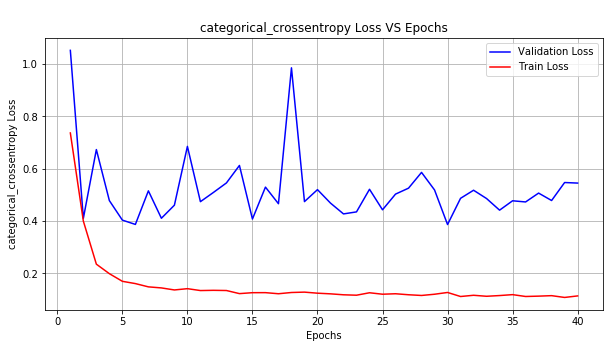

In [71]:
# Plotting Train and Test Loss VS no. of epochs
# list of epoch numbers
x = list(range(1,41))

# Validation loss
vy = history.history['val_loss']
# Training loss
ty = history.history['loss']

# Calling the function to draw the plot
plt_dynamic(x, vy, ty)

In [72]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 537        0         0        0                   0   
SITTING                  0      428        39        1                   0   
STANDING                 0      107       425        0                   0   
WALKING                  0        0         0      464                  23   
WALKING_DOWNSTAIRS       0        0         0        0                 420   
WALKING_UPSTAIRS         0        1         0        1                  52   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                           23  
STANDING                           0  
WALKING                            9  
WALKING_DOWNSTAIRS                 0  
WALKING_UPSTAIRS                 417  


In [73]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 351us/step


In [74]:
score

[0.5453052728528218, 0.9131319986426875]

### Summary

In [2]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names = ["Lstm layer","Train_acc","Test_acc"]
x.add_row(['1 layer','0.9542','0.9155'])
x.add_row(['2 layer','0.8689','0.9101'])
x.add_row(['3 layer','0.9544','0.9131'])

print(x)

+------------+-----------+----------+
| Lstm layer | Train_acc | Test_acc |
+------------+-----------+----------+
|  1 layer   |   0.9542  |  0.9155  |
|  2 layer   |   0.8689  |  0.9101  |
|  3 layer   |   0.9544  |  0.9131  |
+------------+-----------+----------+
